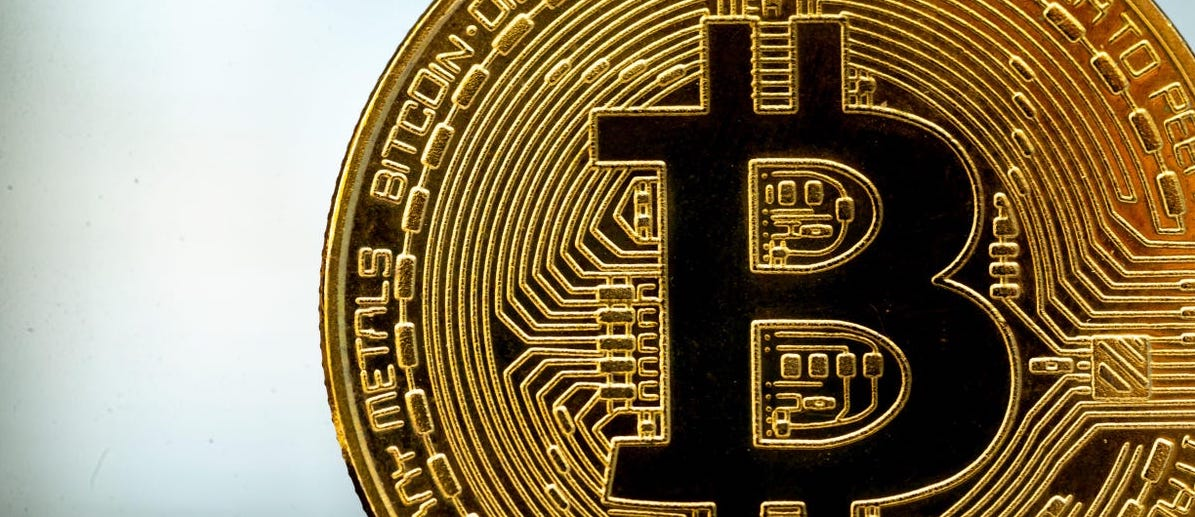
<div align="center">Source: <b> forbes.com </b></div>

# Bitcoin's Realized Volatility Forecasting with GARCH and Multivariate LSTM

Author: **Chi Bui**

## Overview

Volatility is generally accepted as the best measure of market risk and volatility forecasting is used in many different applications across the industry including risk management, value-at-risk, portfolio construction and optimisation, active fund management, risk-parity investing, and derivatives trading. 

Volatility attempts to measure magnitude of price movements that a financial instrument experiences over a certain period of time. The more dramatic the price swings are in that instrument, the higher the level of volatility, and vice versa.

The purpose of this project is to take a sneak peek into the future by **forecasting the next 7 days' average daily realized volatility of BTC-USD** using 2 different approaches - the traditional econometric approach to volatility prediction of financial time series **GARCH** and state-of-the-art **LSTM Neural Networks**.

## Business Problem

Since Bitcoin's first appearance in 2009, it has changed the world's financial landscape substantially. The decentralized cryptocurrency has established itself as an asset class recognized by many asset managers, large investment banks and hedge funds. As the speed of mainstream adoption continues to soar, it is also leading investors to explore a new venture, such as crypto options.

Bitcoin has been historically known to be more volatile than regulated stocks and commodities. Its most recent surge in late December 2020, early January 2021 has brought about a lot of questions and uncertainties about the future financial landscape. At the point of writing this report (August 2021), Bitcoin is traded at slightly above US$ 50,000, which is no small feat considering its traded price at the beginning of 2020 was only US$ 7,200. 

Although the forecasting and modeling of volatility has been the focus of many empirical studies and theoretical investigations in academia, forecasting volatility accurately remains a crucial challenge for scholars. On top of that, since crypto option trading is relatively new, there has not been as much research done on this Bitcoin volatility forecasting. Crytocurrencies carry certain nuances that differ themselves from traditional regulated stocks and commodities, which would also need to be accounted for.

## Dataset

The historical dataset of Bitcoin Open/Close/High/Low prices were obtained using the Yahoo Finance API **`yfinance`**. This API is free, very easy to set up, but yet still contains a wide range of data and offerings. 

I will be downloading BTC-USD prices using ticker `BTC-USD` at 1-day interval. Yahoo did not add Bitcoin until 2014; and therefore although it was first traded in 2009, **`yfinance`** only contains data from September 2014 until now (August 2021). I would therefore be working with over 2,500 datapoints covering about 7 years of trading days.

### Installing & Importing Libraries 

In [10]:
# !pip install arch

In [11]:
# !pip3 install yfinance

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [2]:
directory_to_img = os.path.join('..', '..', 'images')

In [17]:
start = datetime(2014, 1, 1)
end = datetime.today()

tckr = 'BTC-USD'

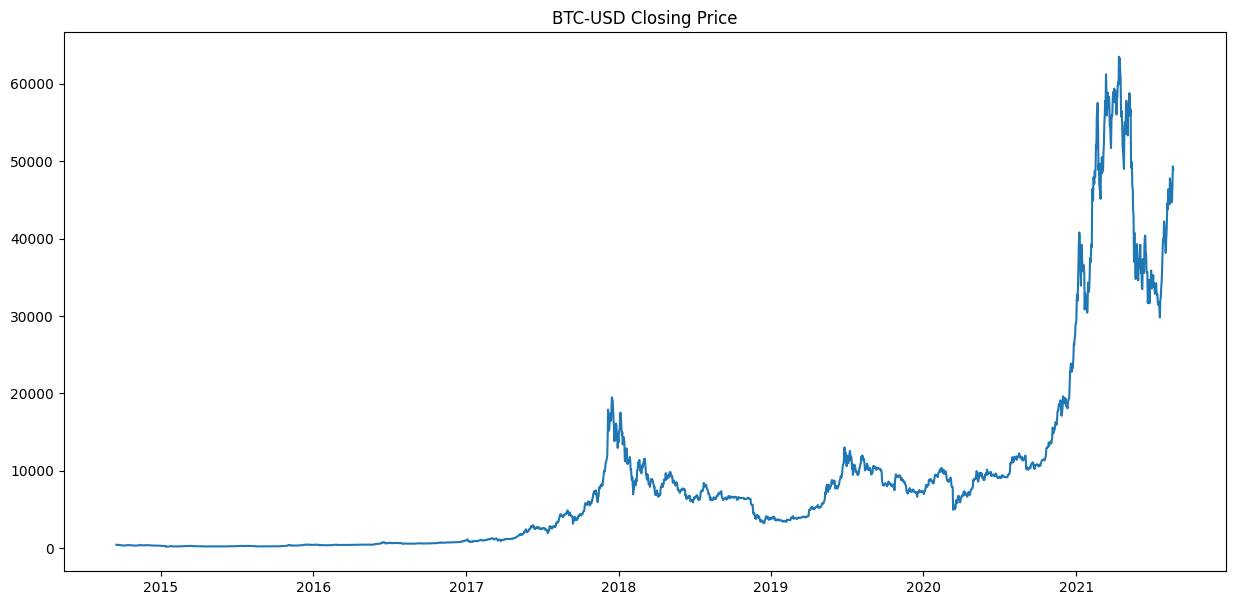

In [456]:
ticker = yf.Ticker(tckr)

plt.figure(figsize=(15,7))
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")
plt.title('BTC-USD Closing Price')

plt.plot(df.Close)
plt.savefig(os.path.join(directory_to_img, 'close.jpg'), dpi=300, bbox_inches='tight');

### **Types of Volatility and How They are Measured**

(Source: https://www.investopedia.com/terms/v/vix.asp)  

Volatility does not measure the direction of price changes of a financial instrument, merely its dispersions over a certain period of time. The more dramatic the price swings are in that instrument, the higher the level of volatility, and vice versa. High volatility is associated with higher risk, and low volatility low risk.

Volatility can either be historical or implied; both are usually expressed in percentage terms. 

- **Historical Volatility** (HV) or **Realized Volatility** is the actual volatility demonstrated by the underlying over a period of time. Realized Volatility is commonly calculated as the standard deviation of price returns,
which is the dollar change in price as a percentage of previous day's price.
- **Implied volatility** (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price.

(The main focus of this project is **NOT implied volatility**, which traditionally can be derived from option pricing models such as the Black Scholes Model). 

In [460]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

Further research indicates that for practicality purposes it's preferable to use the log returns especially in mathematic modeling, because it helps eliminate non-stationary properties of time series data, and makes it more stable:


LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

There's another advantage to log returns, which is that they're additive across time: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$


In [461]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [462]:
df.head()

Open        High  ...   returns  log_returns
Date                                ...                       
2014-09-17  465.864014  468.174011  ...       NaN          NaN
2014-09-18  456.859985  456.859985  ... -7.192558    -0.074643
2014-09-19  424.102997  427.834991  ... -6.984265    -0.072402
2014-09-20  394.673004  423.295990  ...  3.573492     0.035111
2014-09-21  408.084991  412.425995  ... -2.465854    -0.024968

[5 rows x 9 columns]

In [14]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

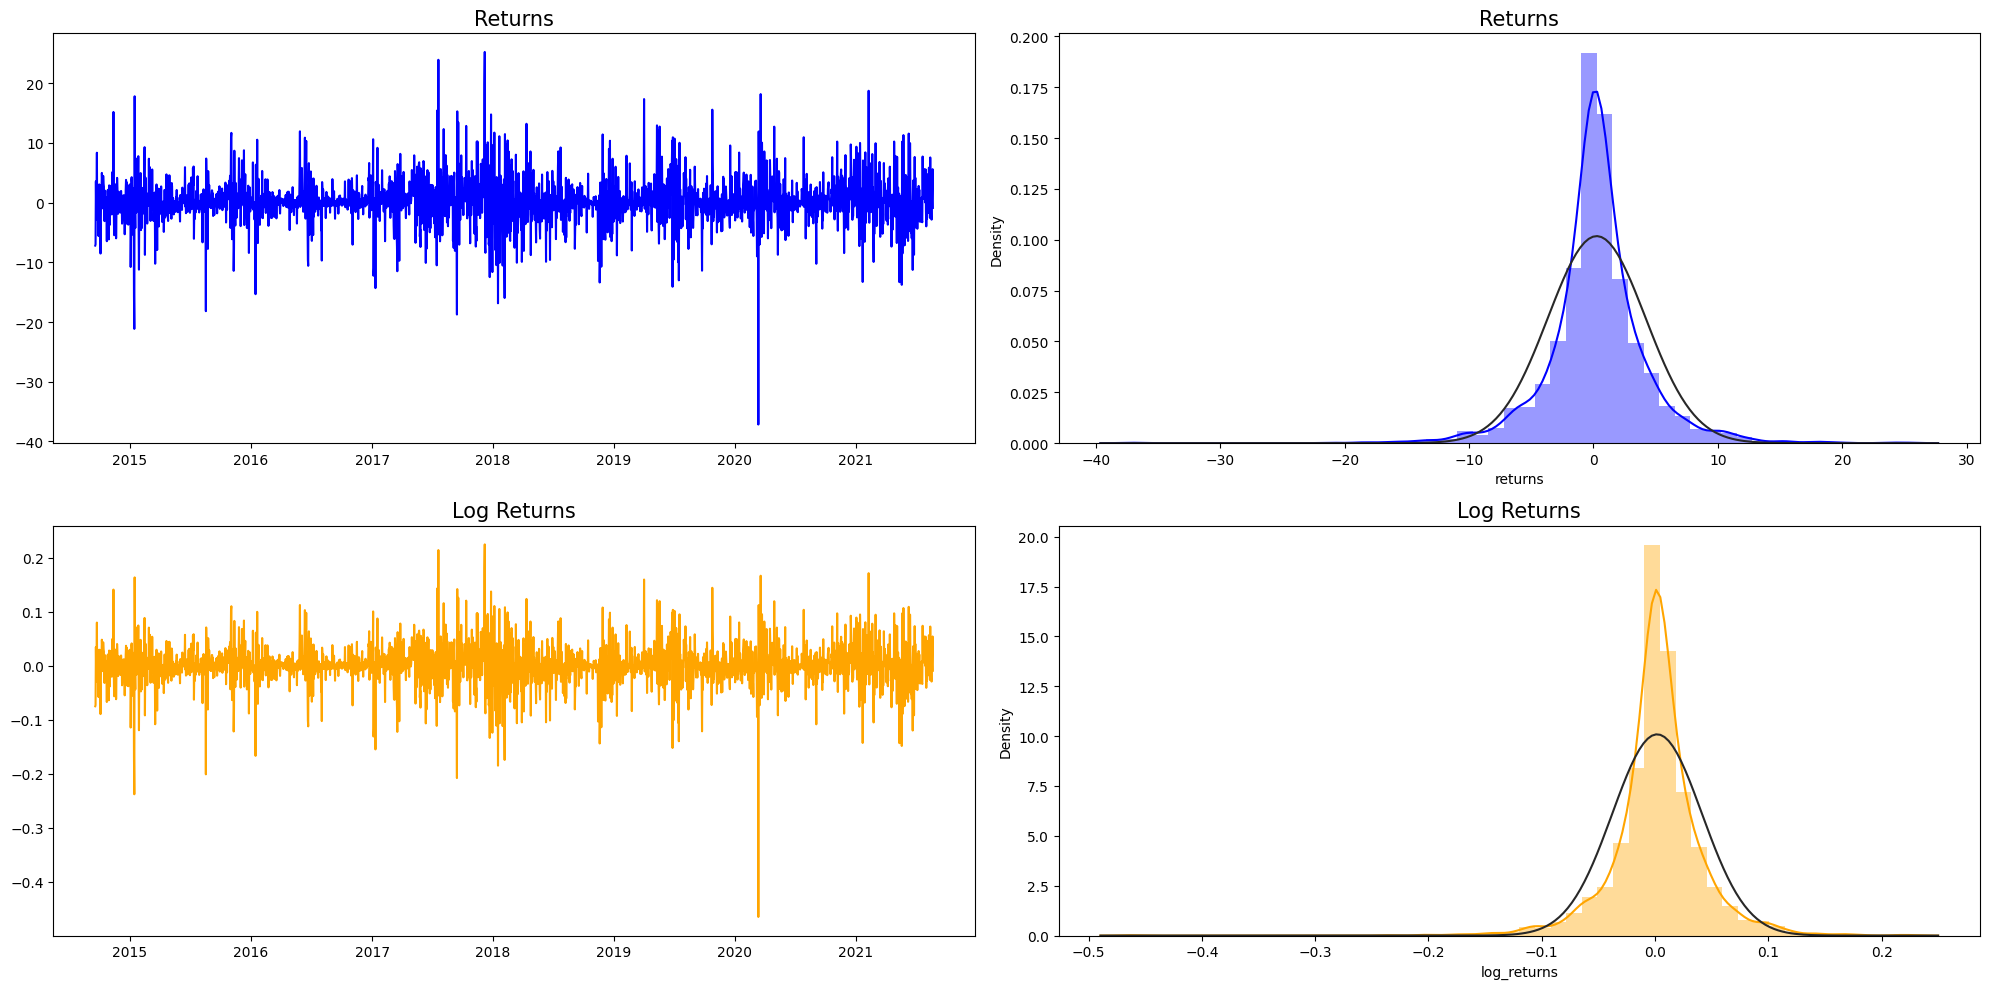

In [463]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df.returns, color='blue')
axes[0][0].set_title('Returns', fontsize=15)

sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns', fontsize=15)

axes[1][0].plot(df.log_returns, color='orange')
axes[1][0].set_title('Log Returns', fontsize=15)

sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(directory_to_img, 'returns_logreturns.jpg'), dpi=300, bbox_inches='tight')
fig.show();

Both Returns & Log Returns show some:
- slight negative skewness
- positive kurtosis (leptokurtic) - higher peak with thicker tails than the standard normal distribution.


In [23]:
df.returns.describe()

count    2527.000000
mean        0.262320
std         3.919310
min       -37.169539
25%        -1.280782
50%         0.199896
75%         1.826197
max        25.247169
Name: returns, dtype: float64

In [24]:
df.log_returns.describe()

count    2527.000000
mean        0.001846
std         0.039533
min        -0.464730
25%        -0.012891
50%         0.001997
75%         0.018097
max         0.225119
Name: log_returns, dtype: float64

(Source: https://www.investopedia.com/articles/investing/102715/computing-historical-volatility-excel.asp)

The standard deviation will be different for log returns computed over longer or shorter intervals. For this specific project, the volatility would be for a certain fixed interval window (`INTERVAL_WINDOW`) is the standard deviation of log returns, or the square root of the sum of squares of log returns:

$\sigma_{interval} = \sqrt{\sum_{t} r_{t-1, t}^2}$

And then to scale the daily volatility by a certain frequency (weekly, monthly, yearly), we can multiply the daily volatility by the square root of that frequency in terms of day divided by the interval minus 1 (`INTERVAL_WINDOW - 1`). For example:

$\sigma_{daily} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{1}{interval-1}}$

$\sigma_{annualized} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{365}{interval-1}}$

$\sigma_{monthly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{30}{interval-1}}$

$\sigma_{weekly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{7}{interval-1}}$


In [33]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

For this specific project I'll experiment with an interval window of 30 days (equivalent to roughly 1 month of trading for cryptocurrencies). The goal here is to forecast the average realized volatility of the next `n_future` 7 days using a number of immediate past/historical datapoints (`n_past`). 


In [464]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

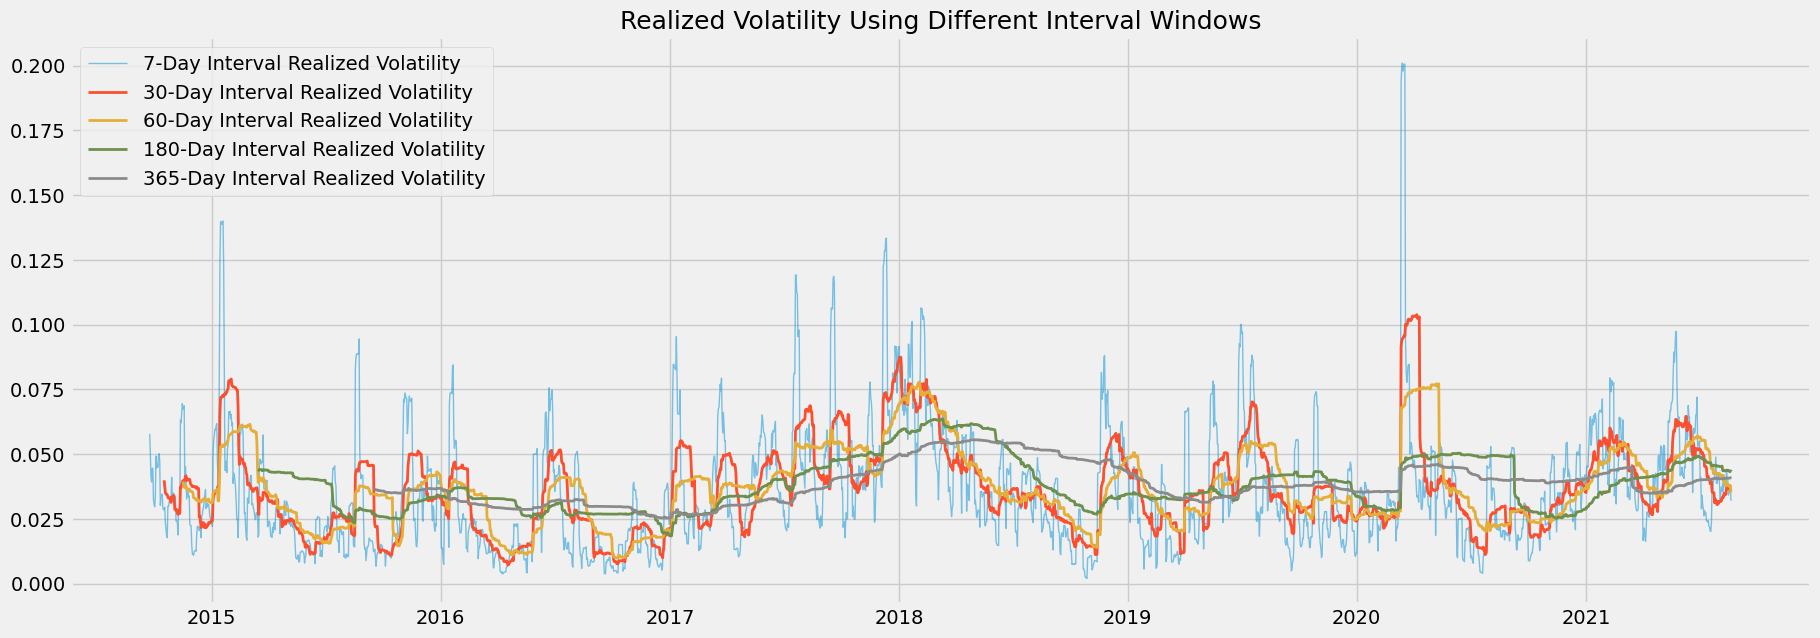

In [466]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(20,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=18)

plt.legend(loc='best', prop={'size': 14})
plt.savefig(os.path.join(directory_to_img, 'diff_intervals.jpg'), dpi=300, bbox_inches='tight')
plt.show();

The reason I selected 30 days is because 7 days seems too noisy to observe meaningful patterns, while longer intervals seem to smooth the volatility down significantly and tend to mean-revert. 

Using interval window of 30 days would also help avoid wasting too many datapoints at the beginning of the dataset.

In [467]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [468]:
df.describe()

Open          High  ...  vol_current   vol_future
count   2527.000000   2527.000000  ...  2497.000000  2491.000000
mean    8532.978327   8778.737194  ...     0.036373     0.036374
std    12602.755096  12997.653865  ...     0.017243     0.017263
min      176.897003    211.731003  ...     0.007228     0.007228
25%      571.451996    577.051483  ...     0.024470     0.024461
50%     5062.793945   5238.945312  ...     0.034074     0.033957
75%     9446.590332   9633.276855  ...     0.046047     0.046099
max    63523.753906  64863.097656  ...     0.103878     0.103878

[8 rows x 11 columns]

The 2 columns `Dividends` and `Stock Splits` don't store any information, all rows are `0.0`. So I'll remove them.

In [469]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [470]:
df.describe()

Open          High  ...  vol_current   vol_future
count   2527.000000   2527.000000  ...  2497.000000  2491.000000
mean    8532.978327   8778.737194  ...     0.036373     0.036374
std    12602.755096  12997.653865  ...     0.017243     0.017263
min      176.897003    211.731003  ...     0.007228     0.007228
25%      571.451996    577.051483  ...     0.024470     0.024461
50%     5062.793945   5238.945312  ...     0.034074     0.033957
75%     9446.590332   9633.276855  ...     0.046047     0.046099
max    63523.753906  64863.097656  ...     0.103878     0.103878

[8 rows x 9 columns]

Since I am currently using aN `INTERVAL_WINDOW` of 30 and a horizon `n_future` of  7, the volatilty of first 30 values as well as the last 7 values of the dataframe would be `NaN`, and therefore need to be dropped from the dataset.

In [471]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

In [90]:
# print(plt.style.available)

## **Exploratory Data Analysis**

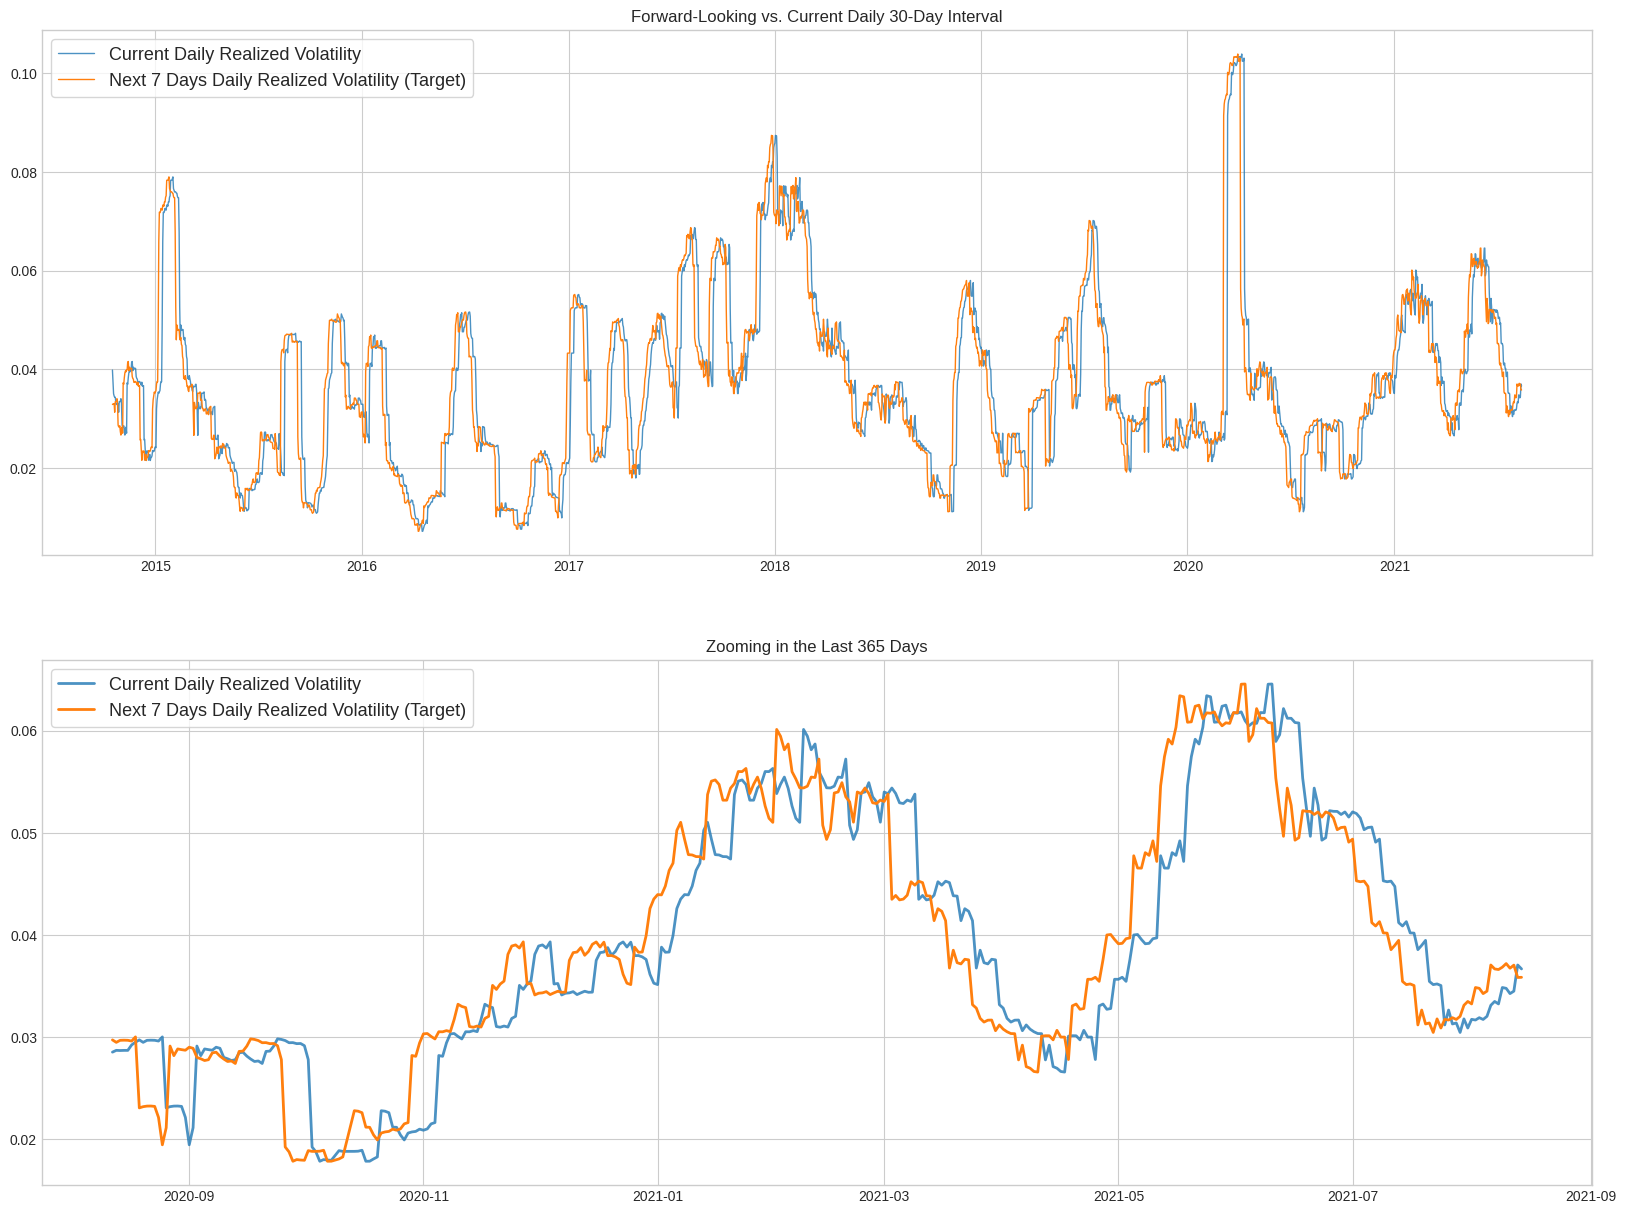

In [475]:
plt.style.use(['seaborn-whitegrid'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,15))

ax1.plot(df.vol_current, alpha=.8, lw=1,
         label='Current Daily Realized Volatility')
ax1.plot(df.vol_future, lw=1,
         label=f'Next {n_future} Days Daily Realized Volatility (Target)')

ax2.plot(df.vol_current[-365:], alpha=.8, lw=2,
         label='Current Daily Realized Volatility')
ax2.plot(df.vol_future[-365:], lw=2,
         label=f'Next {n_future} Days Daily Realized Volatility (Target)')

ax1.title.set_text(f'Forward-Looking vs. Current Daily {INTERVAL_WINDOW}-Day Interval')
ax2.title.set_text('Zooming in the Last 365 Days')

ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
plt.savefig(os.path.join(directory_to_img, 'daily_vol.jpg'), dpi=300, bbox_inches='tight')
plt.show();

### **Daily Volatility Grouped by Month**

In [473]:
# RESETTING MATPLOTLIB STYLE TO DEFAULT
plt.rcParams.update(plt.rcParamsDefault)

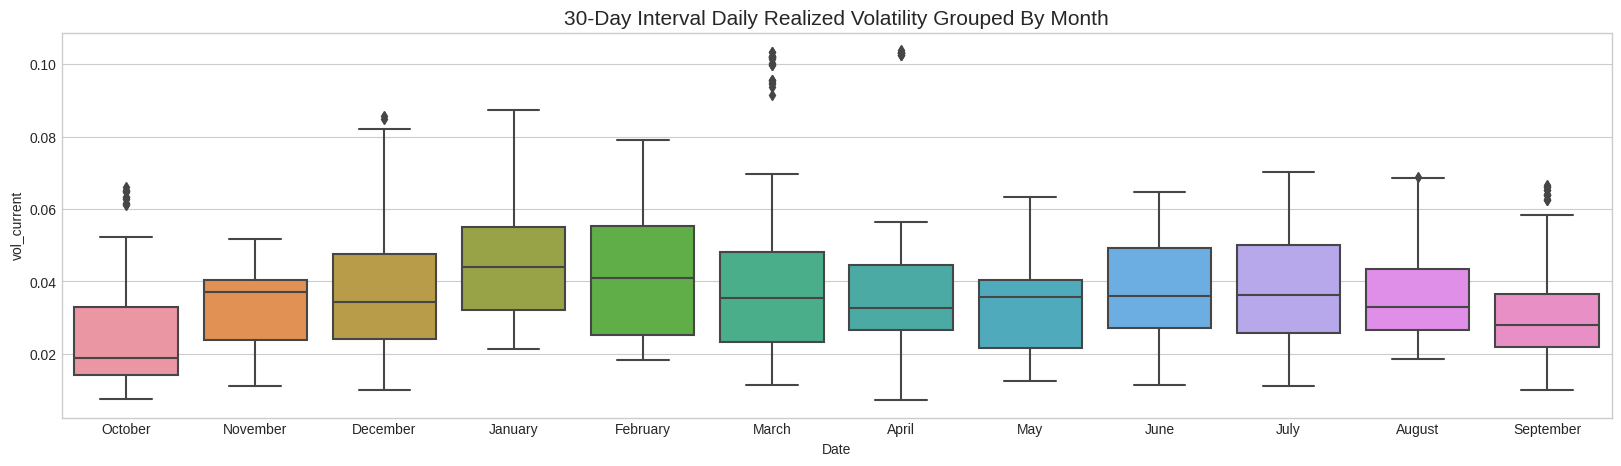

In [476]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x=df.index.month_name(), y=df.vol_current, ax=ax)
ax.set_title(f'{INTERVAL_WINDOW}-Day Interval Daily Realized Volatility Grouped By Month', 
             fontsize=15)
plt.savefig(os.path.join(directory_to_img, 'vol_by_month.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [97]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06    0.103878
2020-04-03    0.103330
2020-04-02    0.103319
2020-03-30    0.103302
2020-03-31    0.103300
2020-04-01    0.103203
2020-04-05    0.103192
2020-04-04    0.103175
2020-04-10    0.103052
2020-04-07    0.102421
2020-04-09    0.102414
2020-04-08    0.102411
2020-03-29    0.102179
2020-03-24    0.102140
2020-03-25    0.102018
2020-03-23    0.101864
2020-03-26    0.101844
2020-03-28    0.101738
2020-03-27    0.101523
2020-03-22    0.100300
2020-03-19    0.100166
2020-03-20    0.099710
2020-03-21    0.099709
2020-03-17    0.095724
2020-03-18    0.095614
2020-03-16    0.095421
2020-03-15    0.094782
2020-03-14    0.094559
2020-03-13    0.093746
2020-03-12    0.091405
2018-01-02    0.087396
2018-01-04    0.087307
2018-01-03    0.087271
2018-01-01    0.085787
2017-12-31    0.085544
2017-12-30    0.084937
2018-01-05    0.083116
2017-12-28    0.082083
2017-12-29    0.082024
2017-12-26    0.081314
2017-12-27    0.080819
2015-02-01    0.078996
2018-02-14    0.078846
2017-1

It can be observed that:
- volatility has consistently reached some of its higher points in the in the months of December/January historically 
- March and April has the most amount of large outliers 

- while August and September (which are the upcoming months I am going to forecast) historically has been relatively quiet

### **Daily Volatility Grouped by Year**

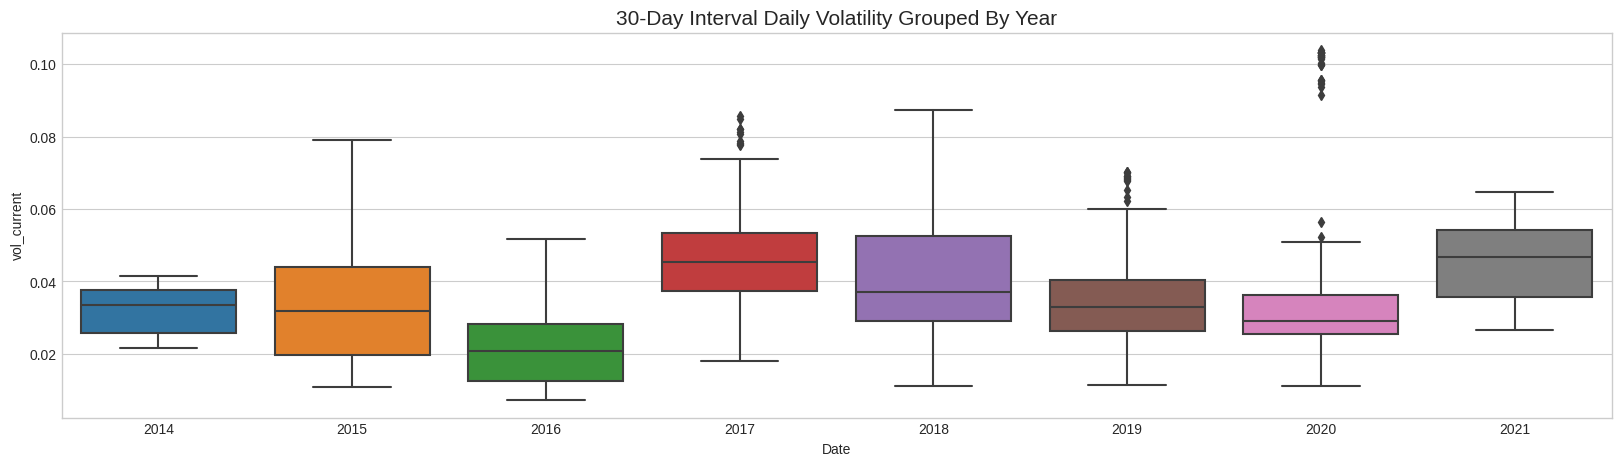

In [477]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x=df.index.year, y=df.vol_current, ax=ax)
ax.set_title(f'{INTERVAL_WINDOW}-Day Interval Daily Volatility Grouped By Year', 
             fontsize=15)
plt.savefig(os.path.join(directory_to_img, 'vol_by_year.jpg'), dpi=300, bbox_inches='tight')
plt.show();

This plot does reflect Bitcoin's first record peak in 2017 (around US$19,800 towards the end of December). And the outliers in 2020 corresponded with its over 200% surge in 2020 (Bitcoin started at US$7,200 at the beginning of 2020). It reached US$20,000 on most exchanges on 12/15/2020, and then proceeded to hit US$30,000 just 17 days later, which is very impressive considering it took the Dow Jones close to 3 years to make the same move. And then, on 01/07/2021 it broke US$40,000.

And based on this, 2021's daily volatiliy overall has been on the higher side as well. 


### **Daily Volatility Distribution**

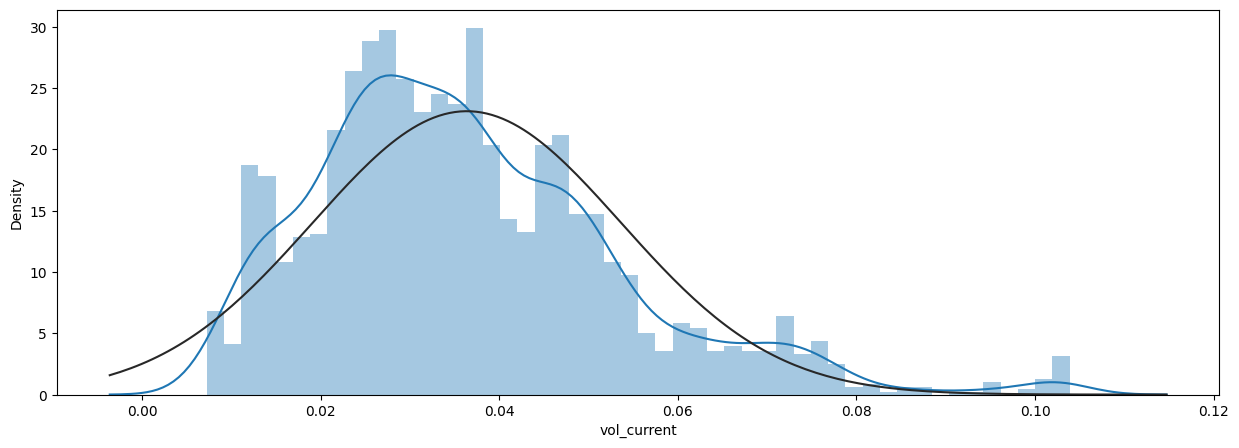

In [99]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
             bins=50, ax=ax)
plt.show();

The distribution of daily realized volatility is lightly right skewed, with a small number of larger values spreaded thinly on the right.

A skewed right distribution would have smaller median compared to mean, and mode smaller than median (mode < median < mean).

### **Returns/Log Returns Stationarity Checking**



In [100]:
from statsmodels.tsa.stattools import adfuller

In [101]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -14.978231769702106
p-value: 1.1725708055627357e-27
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


In [102]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -14.92190448526039
p-value: 1.4074966614829491e-27
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


Using a significant level alpha of 0.05, `p-value` for both Returns and Log Returns are significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis. 

--> Returns and Log returns are both not dependent on time/trend

## **Train-Validation-Test Splits**

There're a total of 2491 usable datapoints in this dataset which covers a period of almost 7 years from October 2014 until today (August 2021). Since cryptocurrencies are not traded on a regulated exchange, the Bitcoin market is open 24/7, 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

I would split the dataset into 3 parts as follows:
- the most recent 30 usable datapoints would be used for final testing - approx. 1.2%
- 1 full year (365 days) for validation and model tuning during training - approx. 14.7%
- and the remaining for training - approx. 84.1%




In [104]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [109]:
print(f'Training \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2014-10-17 00:00:00 	to: 2020-07-13 00:00:00 	2096 days
Validation 	From: 2020-07-14 00:00:00 	to: 2021-07-16 00:00:00 	365 days
Test 		From: 2021-07-17 00:00:00 	to: 2021-08-15 00:00:00 	30 days


The target here would be `vol_future` which represents the daily realized volatility of the next `n_future` days from today (average daily volatility from `t + n_future - INTERVAL_WINDOW` to time step `t + n_future`). 

For example, using an `n_future` value of 7 and an `INTERVAL_WINDOW` of 30, the value that I want to predict at time step `t` would be the average daily realized volatility from time step `t-23` to time step `t+7`.

In [110]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [112]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [113]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [114]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

### **Feature Normalization**

As I am going to build various types of models based on different algorithms with slightly different assumptions using different types of parameters, it's probably better to normalize the volatilities using `MinMaxScaler` to standardize performance comparison among different models.

In [115]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [116]:
# TRANSFORM TRAINING VOLATILITIES 
x_train_scaled = pd.Series(scaler_vol.transform(x_train.values.reshape(-1,1))[:,0],
                           index=train_idx)
y_train_scaled = pd.Series(scaler_vol.transform(y_train.values.reshape(-1,1))[:,0],
                           index=train_idx)

# TRANSFORMING VALIDATION VOLATILITIES
x_val_scaled = pd.Series(scaler_vol.transform(x_val.values.reshape(-1,1))[:,0],
                           index=val_idx)
y_val_scaled = pd.Series(scaler_vol.transform(y_val.values.reshape(-1,1))[:,0],
                           index=val_idx)

# TRANSFORMING TEST VOLATILITIES
x_test_scaled = pd.Series(scaler_vol.transform(x_test.values.reshape(-1,1))[:,0],
                           index=test_idx)
y_test_scaled = pd.Series(scaler_vol.transform(y_test.values.reshape(-1,1))[:,0],
                           index=test_idx)

### **Train-Validation-Test Visualization**

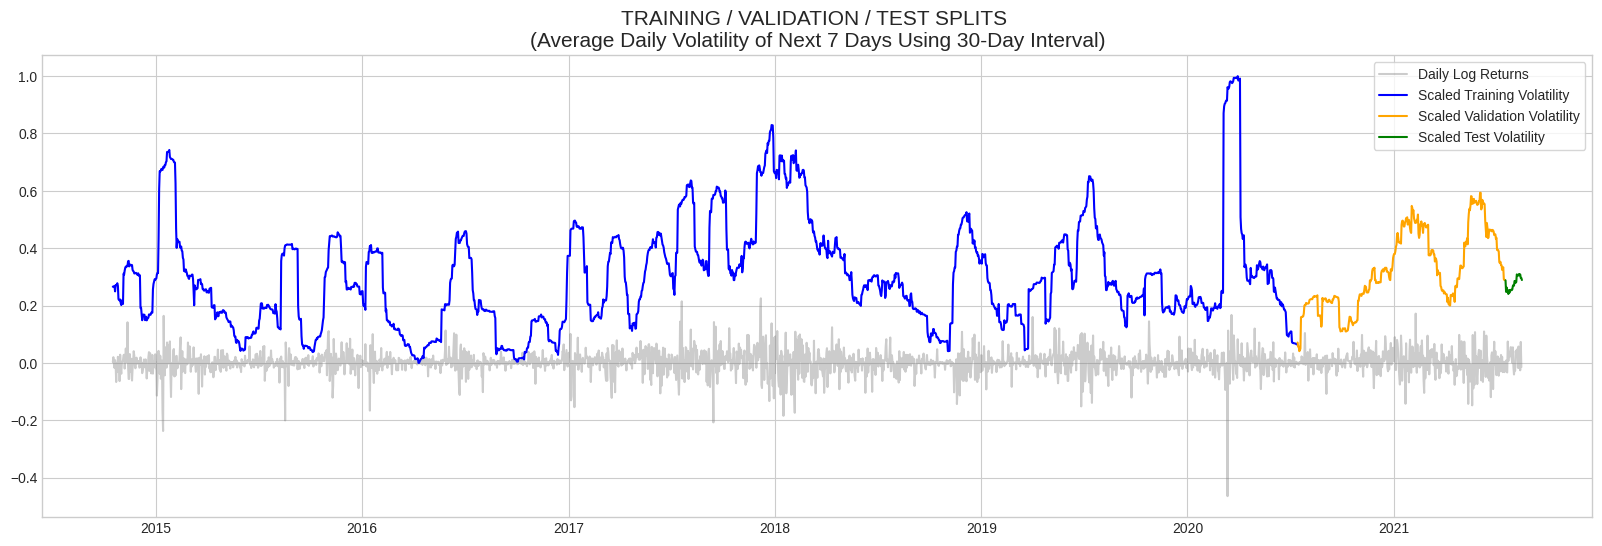

In [479]:
plt.figure(figsize=(20,6))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(y_train_scaled, color='blue', label='Scaled Training Volatility')
plt.plot(y_val_scaled, color='orange', label='Scaled Validation Volatility')
plt.plot(y_test_scaled, color='green', label='Scaled Test Volatility')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS \n(Average Daily Volatility of Next {n_future} Days Using {INTERVAL_WINDOW}-Day Interval)', 
          fontsize=15)
plt.legend(frameon=True)
plt.savefig(os.path.join(directory_to_img, 'train_val_test.jpg'), dpi=300, bbox_inches='tight')
plt.show();

# **Modeling**

## **Performance Metrics**

Usually with financial time series, if we just shift through the historic data trying different methods, parameters and timescales, it's almost certain to find to some strategy with in-sample profitability at some point. However the whole purpose of "forecasting" is to predict the future based on currently available information, and a model that performs best on training data might not be the best when it comes to out-of-sample generalization (or **overfitting**). Avoiding/Minimizing overfitting is even more important in the constantly evolving financial markets where the stake is high.

The 2 main metrics I'd be using are **RMSPE (Root Mean Squared Percentage Error)** and **RMSE (Root Mean Square Errors)** with RMSPE prioritized. Timescaling is very important in the calculation of volatility due to the level of freedom in frequency/interval window selection. Therefore I think RMSPE would help capture degree of errors compared to desired target values better than other metrics. Also RMSPE would punish large errors more than regular MAPE (Mean Absolute Percentage Error), which is what I want to do here.

RMSE and RMSPE would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [126]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [127]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [128]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [129]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [486]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    plt.rcParams["axes.grid"] = False
    plt.figure(figsize=(20,7))
    plt.plot(y_true, color='blue', 
             label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
    plt.plot(x_val_scaled, color='gray',  ls='--',
             label=f"Scaled Current Daily Volatility")
    plt.plot(y_pred, color='orange', lw=2.5,
             label=f'Forecasted Volatility')
    
    plt.plot(lr_val, color='gray', alpha=0.4,
             label='Daily Log Returns')

    plt.title(f'{model_name} \non Validation Data', fontsize=15)
    plt.legend(loc='best', frameon=True)

## **Model #1 - Baseline Model**

One of the essential characteristics of Volatility is it's **mean-revert** over the long term. Therfore my first baseline model his would be a very simple one that only outputs the average current realized volatility of the whole training set as predictions everything.

In [119]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2986620024847935

In [120]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

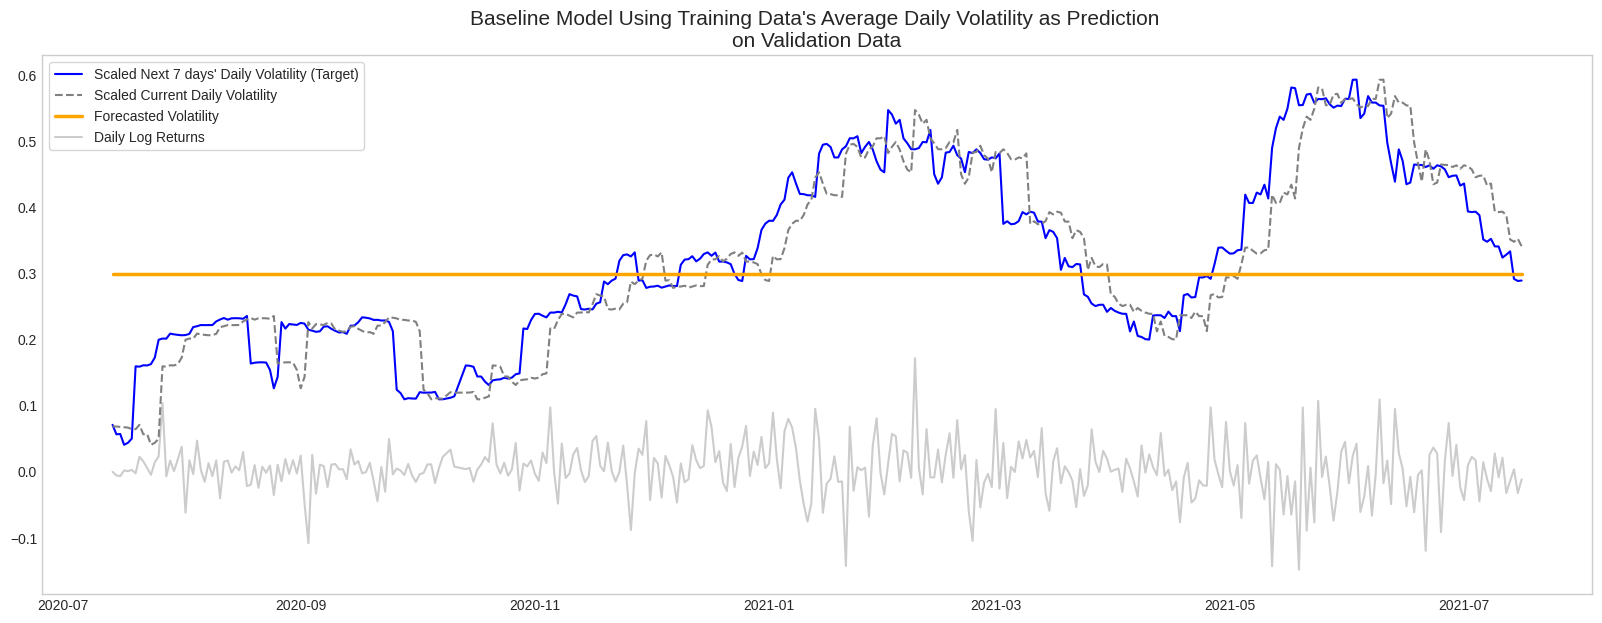

In [487]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.savefig(os.path.join(directory_to_img, 'baseline.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [130]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          0.812957         0.136064

## **Model #2 - Random Walk Naive Forecasting**

A commonly known fact about volatility is that it tends to be **autocorrelated**, and **clusters** in the short-term. This property can be used to implement a naive model that just "predicts" future volatility by using whatever the daily volatility was at the immediate previous time step.

In this case, I'll use the average daily volatility of the most recent `INTERVAL_WINDOW` as predictions for the next 7 days, which is essentially using `vol_current` at time step `t` and prediction for `vol_future` at time step `t`.

In [131]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

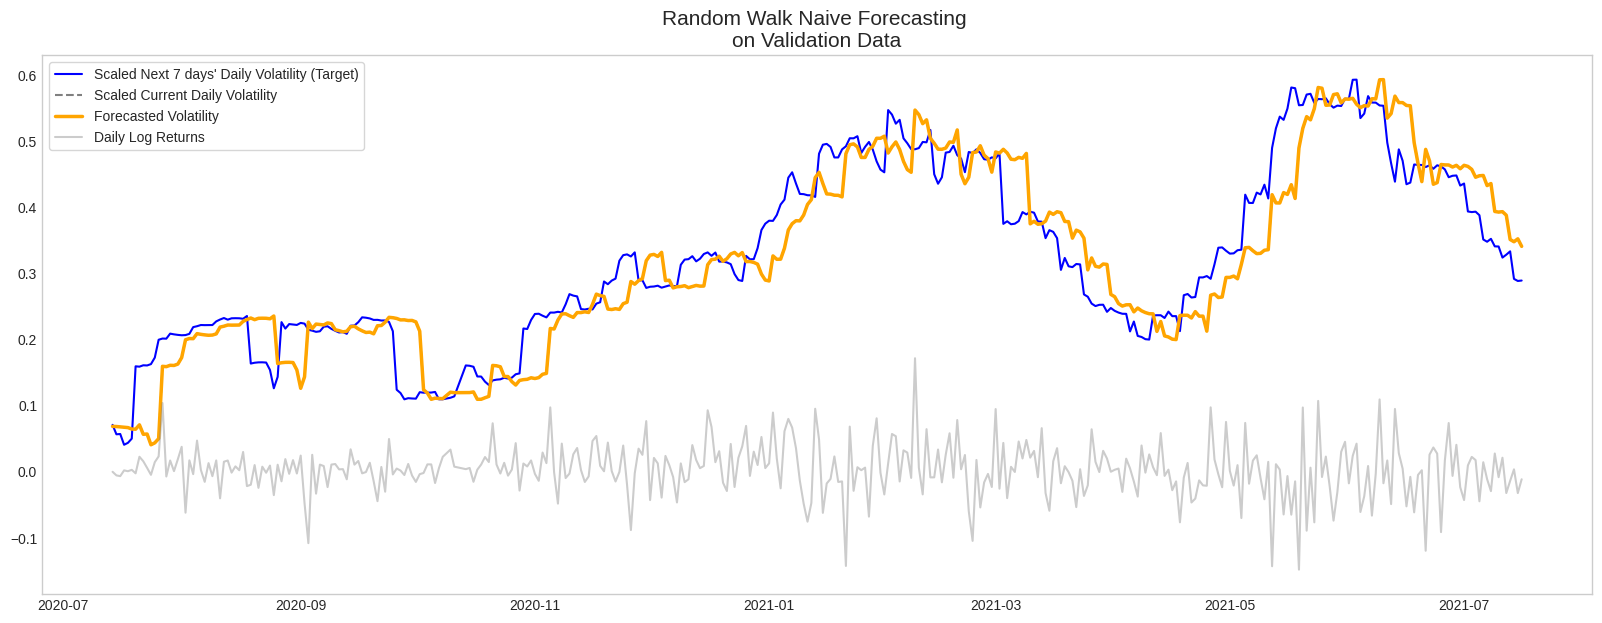

In [488]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.savefig(os.path.join(directory_to_img, 'naive.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [133]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline          0.812957         0.136064
1  Random Walk Naive Forecasting          0.233755         0.052586

So the both error mertrics have gone down by a decent amount. Naive forecasting in time series is sometimes surprisingly difficult to outperform.

## **Model #3 - GARCH**

(Reference: http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html)

GARCH stands for **Generalized Autoregressive Conditional Heteroskedasticity**, which is an extension of the ARCH model (Autoregressive Conditional Heteroskedasticity). 

GARCH includes lag variance terms with lag residual errors from a mean process, and is the traditional econometric approach to volatility prediction of financial time series.

Mathematically, GARCH can be represented as follows:

\begin{align*}
\sigma_{t}^2 = \omega + \sum_{i}^{q}\alpha_{i}\epsilon_{t-i}^2 + \sum_{1}^{p}\beta_{i}\sigma_{t-i}^2
\end{align*}

in which $\sigma_{t}^2$ is variance at time step `t` and $\epsilon_{t-i}^2$ is the model residuals at time step `t-1`

GARCH(1,1) only contains first-order lagged terms and the mathematic equation for it is: 

\begin{align*}
\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}
\end{align*}

where $\alpha$, $\beta$ and $\omega$ sum up to 1, and $\omega$ is the long term variance.

---

(Reference: **Positional Option Trading** - Euan Sinclair)

GARCH is generally regarded as an insightful improvement on naively assuming future volatility will be like the past, but also considered widely overrated as predictor by some experts in the field of volatility. GARCH models capture the essential characteristics of volatility: volatility tomorrow will be close to what it is today (**clustering**), and volatility in the long term will probably **mean revert** (meaning it'd be close to whatever the historical long-term average has been).

### **Basic GARCH**

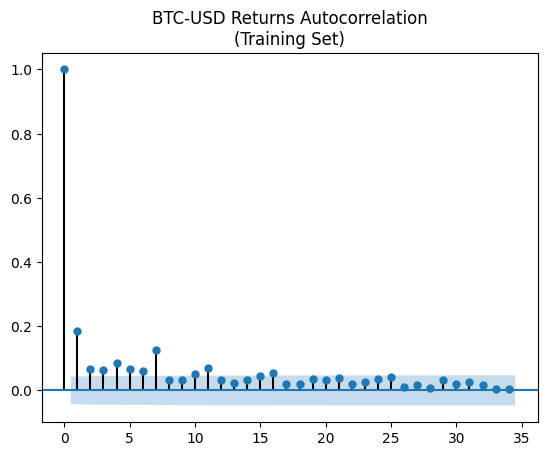

In [134]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

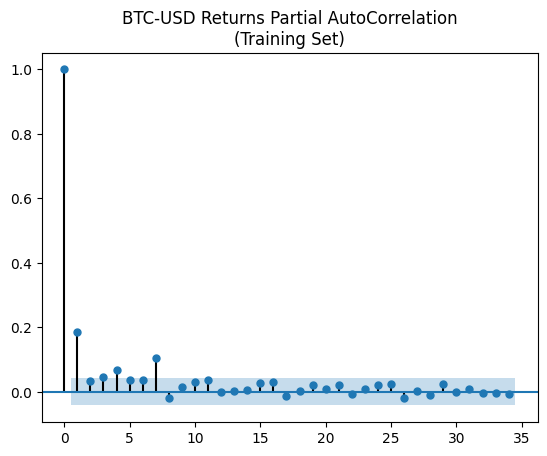

In [135]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

The autocorrelation plots seem to indicate that there's only significant correlation up to the 7th lags, and the ones following don't seem to be too significant.

GARCH models are trained on percent returns. (One of the reasons I decided to normalize the volatilities across the board is because I am still not 100% sure which timescale GARCH conditional volatility is calculated in (likely daily), and still haven't figured out why the outputs here seem to be on a totally different scale compared to the volatilities previously calculated. Once I scale them, they match up much more nicely).

In [136]:
from arch import arch_model

In [137]:
gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5589.96
Distribution:                  Normal   AIC:                           11211.9
Method:            Maximum Likelihood   BIC:                           11302.3
                                        No. Observations:                 2096
Date:                Sun, Aug 22 2021   Df Residuals:                     2095
Time:                        17:55:22   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1776      0.109      1.628      0.104 [-3.6

Using a significance level of 0.05, none of the coefficients seems to be statistically significant (because their p-values `P > |t|` are all greater than 0.05). Therefore, I'll reduce the values of `p` and `q` to 1 to see if that helps.

In [138]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5606.07
Distribution:                  Normal   AIC:                           11220.1
Method:            Maximum Likelihood   BIC:                           11242.7
                                        No. Observations:                 2096
Date:                Sun, Aug 22 2021   Df Residuals:                     2095
Time:                        17:57:32   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1995  6.699e-02      2.978  2.898e-03 [6.822e-

All coefficients look statistically significant now.

After being fitted to the training data (percent returns), the GARCH model forecast contains an estimated conditional volatility attribute for the training portion of the time series. I am going to scale the fitted conditional volatility arrays, plot it out and compare it to the realized volatility calculated above (also scaled) `x_train_scaled`.

In [139]:
# INITIATE SCALER
scaler_garch_vol = MinMaxScaler()

# GET ESTIMATED CONDITIONAL VOLATILITY FROM FITTED MODEL
cond_vol_arr = result_1.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
scaler_garch_vol = scaler_garch_vol.fit(cond_vol_arr)
scaled_cond_vol = pd.Series(scaler_garch_vol.transform(cond_vol_arr)[:,0],
                            index=train_idx)

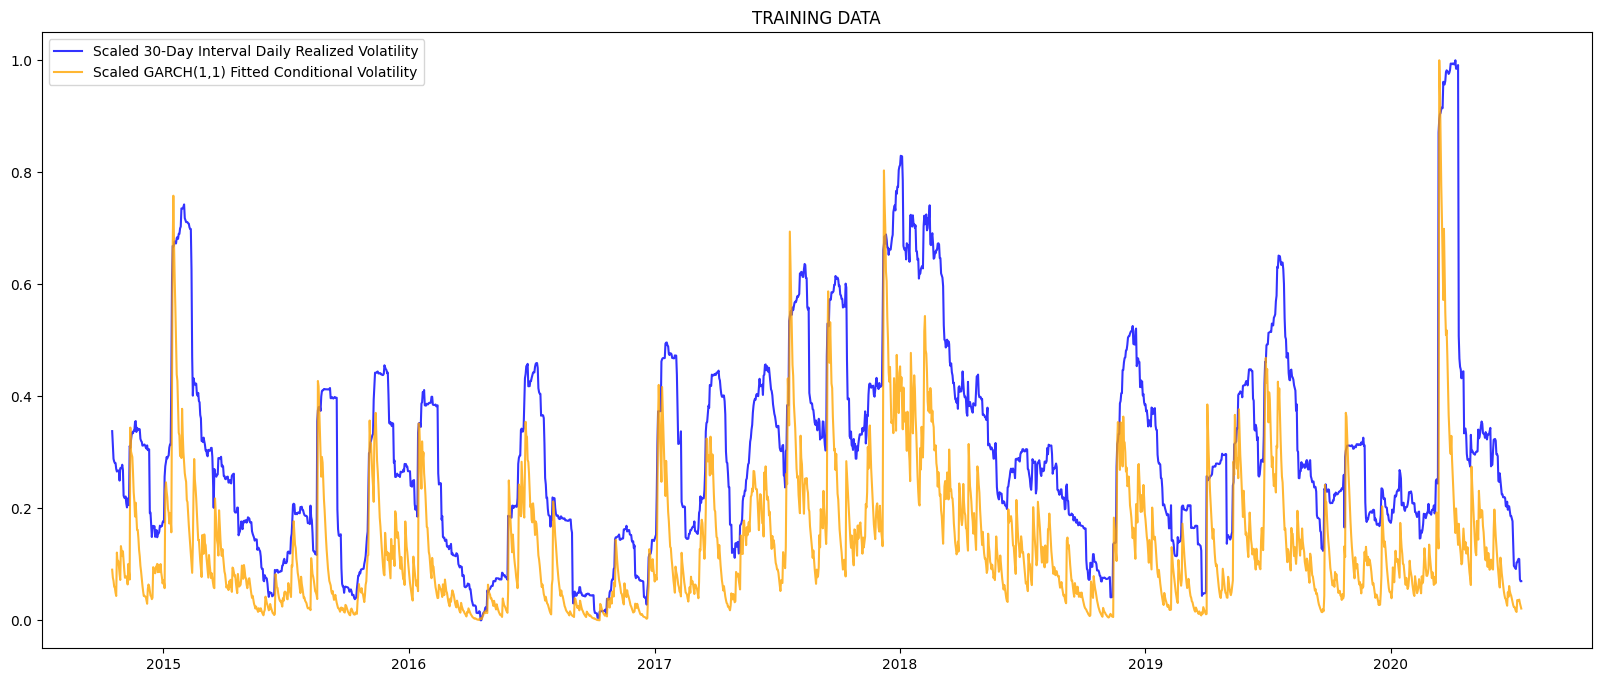

In [141]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
ax.plot(scaled_cond_vol, color='orange', alpha=0.8,
        label='Scaled GARCH(1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend()
plt.show();

#### **Analytical-based Forecasting**

(Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)

I am implementing rolling one-step forecasting here by refitting the model to ALL the datapoints available up to a certain time step before generating prediction for the next `n_future` days. For example, to make prediction on `vol_future` at time step `t`, I would fit the model to all the `returns` available up to time step `t` and then obtain the average forecasted volatility for a horizon of `n_future = 7`.

The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore I am going to normalize the forecasted volatility based on the model's `conditional_volatility` output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

In [142]:
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [143]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = pd.Series(scaler_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                              index=val_idx)

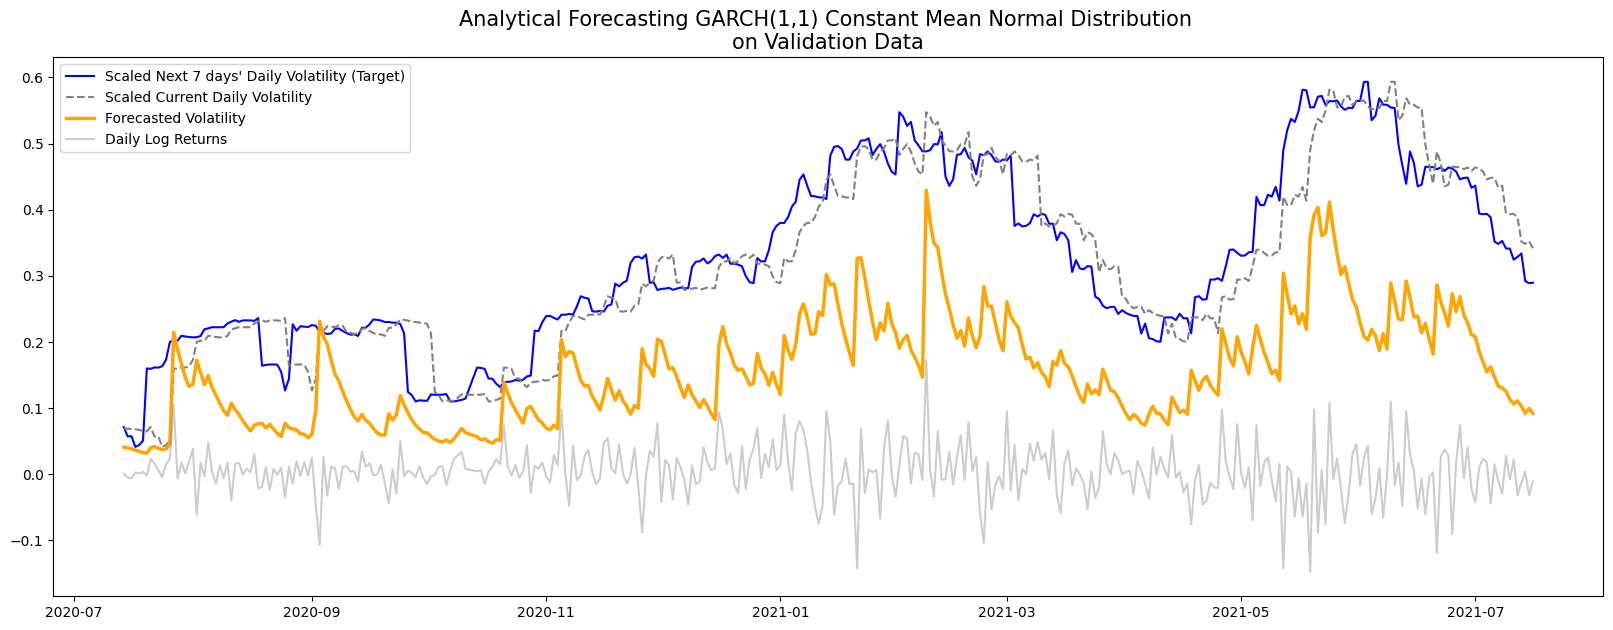

In [144]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

So 7-day horizon forecasting into the future is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalization).

In [145]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1) | Constant Mean | Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                             Mean Baseline          0.812957         0.136064
1             Random Walk Naive Forecasting          0.233755         0.052586
2  GARCH(1,1) | Constant Mean | Normal Dist          0.534194         0.185466

Next, I would inspect the estimated residuals from this first GARCH model.

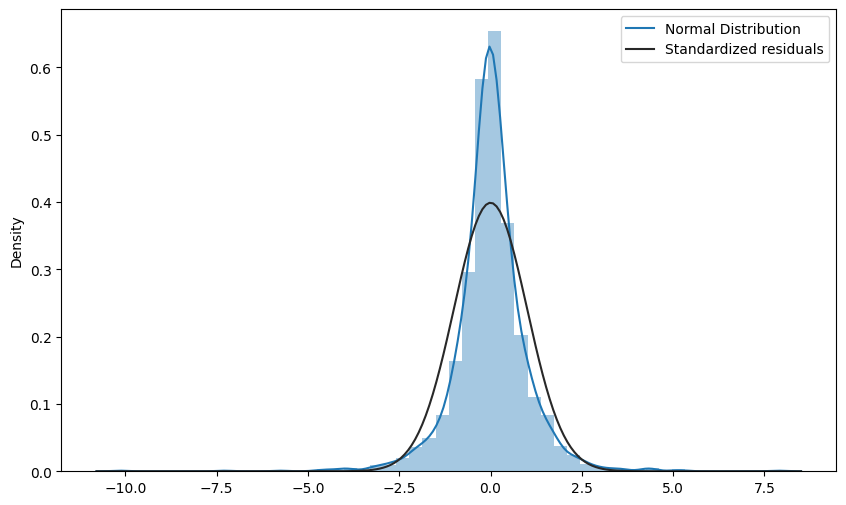

In [146]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
plt.figure(figsize=(10,6))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
plt.legend(('Normal Distribution', 'Standardized residuals'))
plt.show();

(Reference: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/)

By default, basic GARCH is based on some assumptions that the residuals and the mean return are both normally distributed. However, more often than not, financial time series data does not follow a normal distribution, and it's more likely to observe extreme positive and negative values that are far away from the mean. 

Fortunately, there're certain parameters that can be specified in the `arch_model` library to make it more representative of real financial data:
- `'dist'` can be set to `t` for Student's T or `skewt` for skewed Student's T distribution (Student's T distribution is also symmetric and bell-shaped like normal distribution; however it has higher peak and fatter tails allowing more values lying further away from the mean).

Looking at the plot above of the standardized residuals, I think I can try skewed Student's T for the next fit.



### **GARCH Model with Asymmetric Shocks Responses**

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, in reality the market tends to "*take the stairs up and the elevator down*". In other words, the impact is usually asymmetric, and negative impacts tends to affect the volatility more than positive ones.

There's another member in the GARCH family that accounts for assymmetry of shocks reponses called **GJR-GARCH** (short for **Glosten-Jagannathan-Runkle GARCH**).

Additional inputs can be used to construct other models. In this case, by setting `o` to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.

In [148]:
gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5273.90
Distribution:      Standardized Skew Student's t   AIC:                           10561.8
Method:                       Maximum Likelihood   BIC:                           10601.3
                                                   No. Observations:                 2096
Date:                           Sun, Aug 22 2021   Df Residuals:                     2095
Time:                                   18:24:01   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-likelihood has increased quite a bit. Let's see how the conditional volatility looks.

In [149]:
scaler_gjr_garch_vol = MinMaxScaler()

gjr_cond_vol_arr = result_2.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
scaler_gjr_garch_vol = scaler_gjr_garch_vol.fit(gjr_cond_vol_arr)
scaled_gjr_cond_vol = pd.Series(scaler_gjr_garch_vol.transform(gjr_cond_vol_arr)[:,0],
                                index=train_idx)

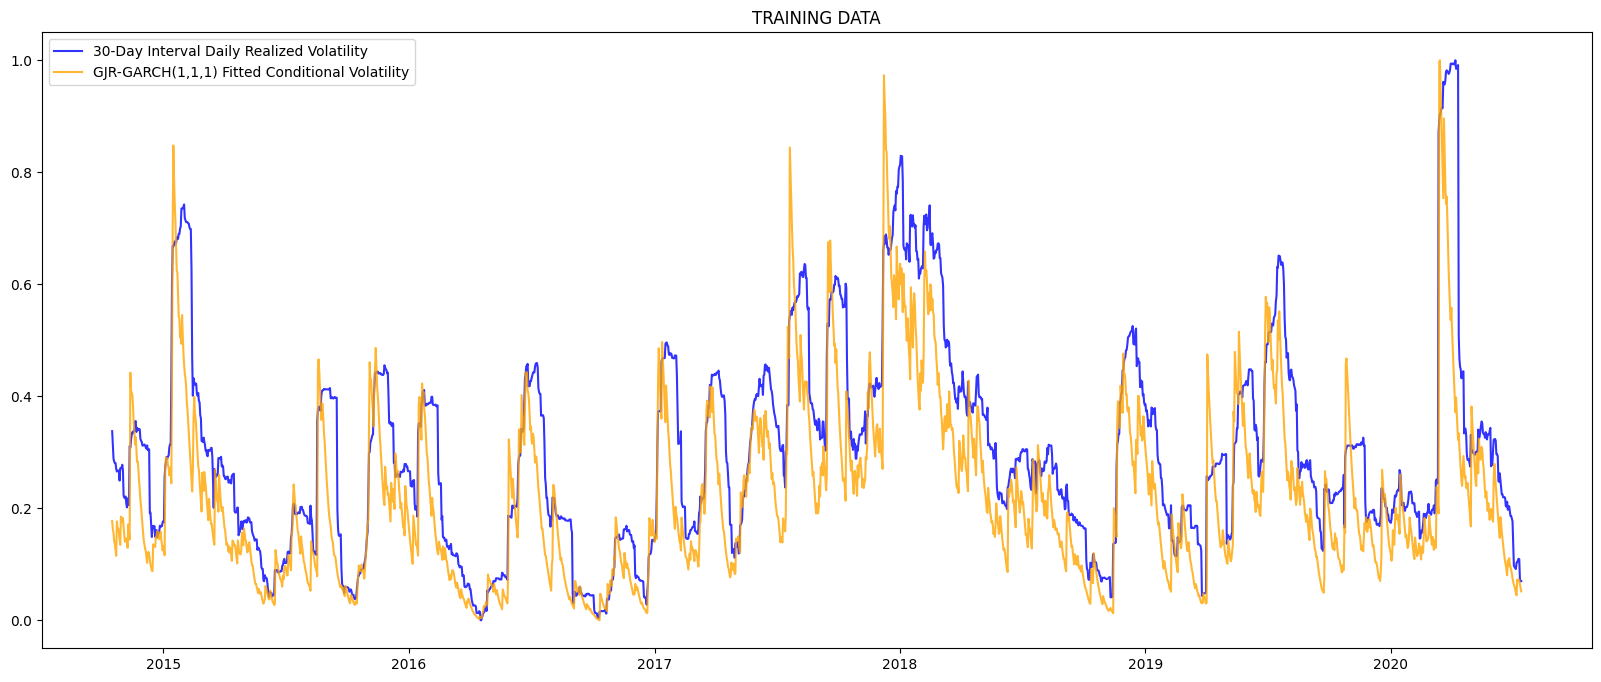

In [151]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'{INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
ax.plot(scaled_gjr_cond_vol, color='orange', alpha=0.8,
        label='GJR-GARCH(1,1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend()
plt.show();

In [152]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_gm_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [153]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_gm_1_preds_scaled = pd.Series(scaler_gjr_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                  index=val_idx)

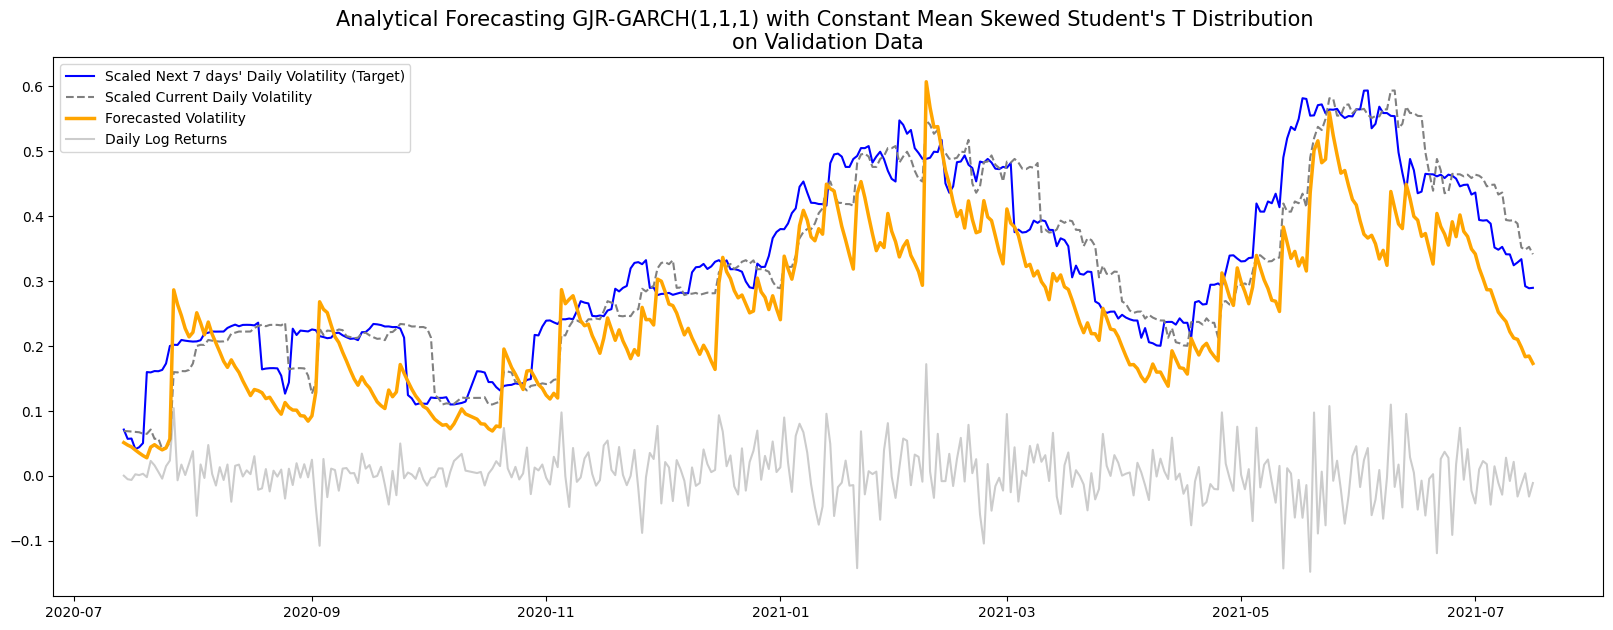

In [154]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_gm_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [155]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_gm_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136064
1                             Random Walk Naive Forecasting  ...         0.052586
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3  Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072

[4 rows x 3 columns]

Compared to GARCH(1,1) with Normal Distribution setting, GJR-GARCH with Skewed Student's T forecasts have moved up quite a bit and shortened the gap between target values and model's predictions. This is also reflected in an improvement in both Validation RMSPE and RMSE.

Unfortunately I still haven't been able to get close to Naive Forecasting.

### **TARCH**

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Specifying-Common-Models)

There's another member in the GARCH family called **TARCH**, which is short for **Threshold Autoregressive Conditional Heteroskedasticity** (and also known as **ZARCH**). TARCH models the volatility using absolute values (instead of squares). This model is specified using `power=1.0` since the default power, `2.0`, corresponds to variance processes that evolve in squares. In addition, asymmetric impact is also incorporated into the GARCH framework by using a dummy variable

The volatility process in a TARCH(1,1) model is given by:

\begin{align*}
\sigma_{t} = \omega + \alpha|\epsilon_{t-1}| + \gamma|\epsilon_{t-1}|I_{[\epsilon_{t-1}<0]} + \beta\sigma_{t-1}
\end{align*}

In [156]:
t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -5272.32
Distribution:      Standardized Skew Student's t   AIC:                           10558.6
Method:                       Maximum Likelihood   BIC:                           10598.2
                                                   No. Observations:                 2096
Date:                           Sun, Aug 22 2021   Df Residuals:                     2095
Time:                                   18:30:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-likelihood and AIC/BIC are quite similar to the GJR-GARCH model. Next I'll inspect the estimated conditional volatility compared to the scaled `vol_current`.

In [157]:
scaler_tarch_vol = MinMaxScaler()

tarch_cond_vol_arr = result_3.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
scaler_tarch_vol = scaler_tarch_vol.fit(tarch_cond_vol_arr)
scaled_tarch_cond_vol = pd.Series(scaler_tarch_vol.transform(tarch_cond_vol_arr)[:,0],
                             index=train_idx)

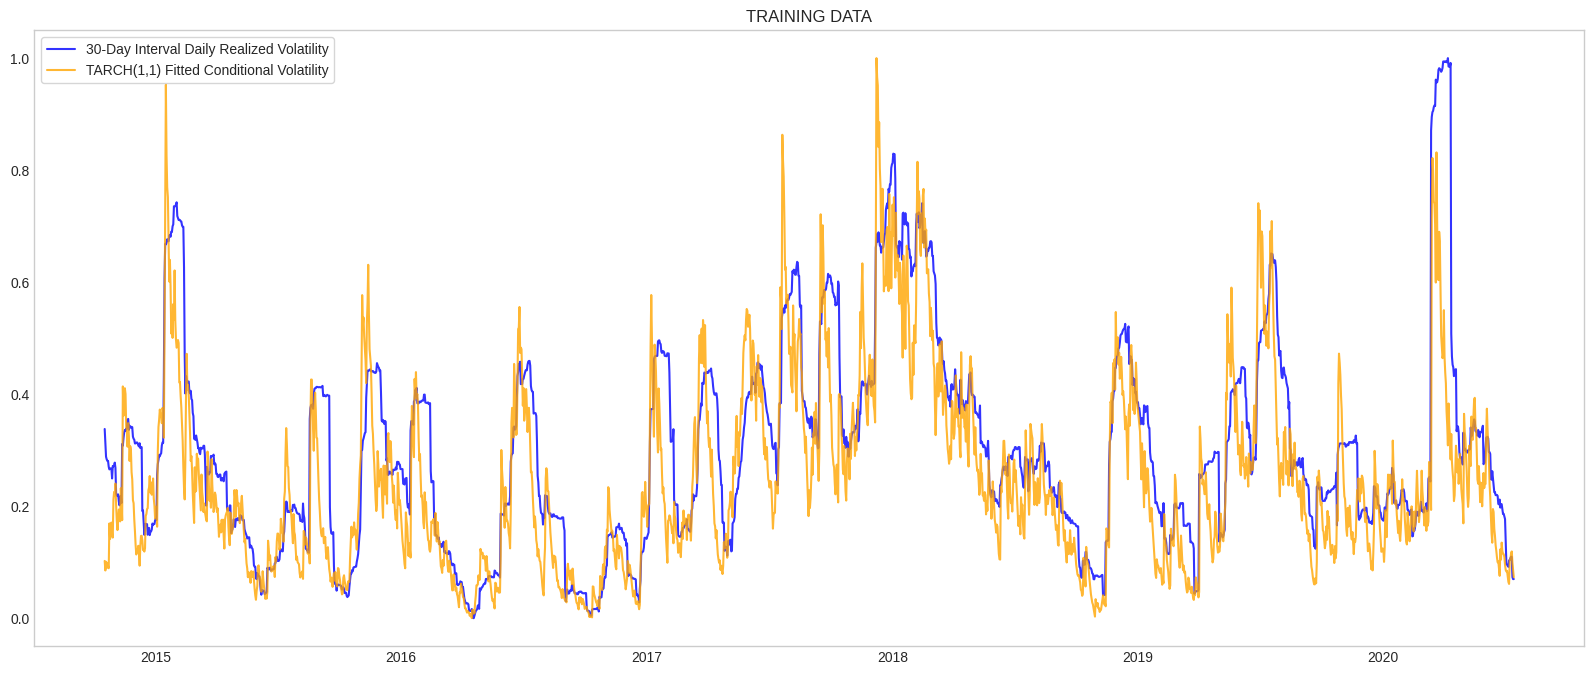

In [490]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'{INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
ax.plot(scaled_tarch_cond_vol, color='orange', alpha=0.8,
        label='TARCH(1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend(frameon=True)
plt.savefig(os.path.join(directory_to_img, 'tarch_cond_vol.jpg'), dpi=300, bbox_inches='tight')
plt.show();

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#TARCH)

TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required.

Bootstrap-based forecasts are nearly identical to simulation-based forecasts except that the values used to simulate the process are computed from historical data rather than using the assumed distribution of the residuals. Forecasts produced using this method also return an `ARCHModelForecastSimulation` containing information about the simulated paths.

In [165]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_gm_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  Converge

TARCH one-step forecasting seems to produce some convergence issues. I still want to look at the results though.

In [166]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_gm_1_preds_scaled = pd.Series(scaler_tarch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                index=val_idx)

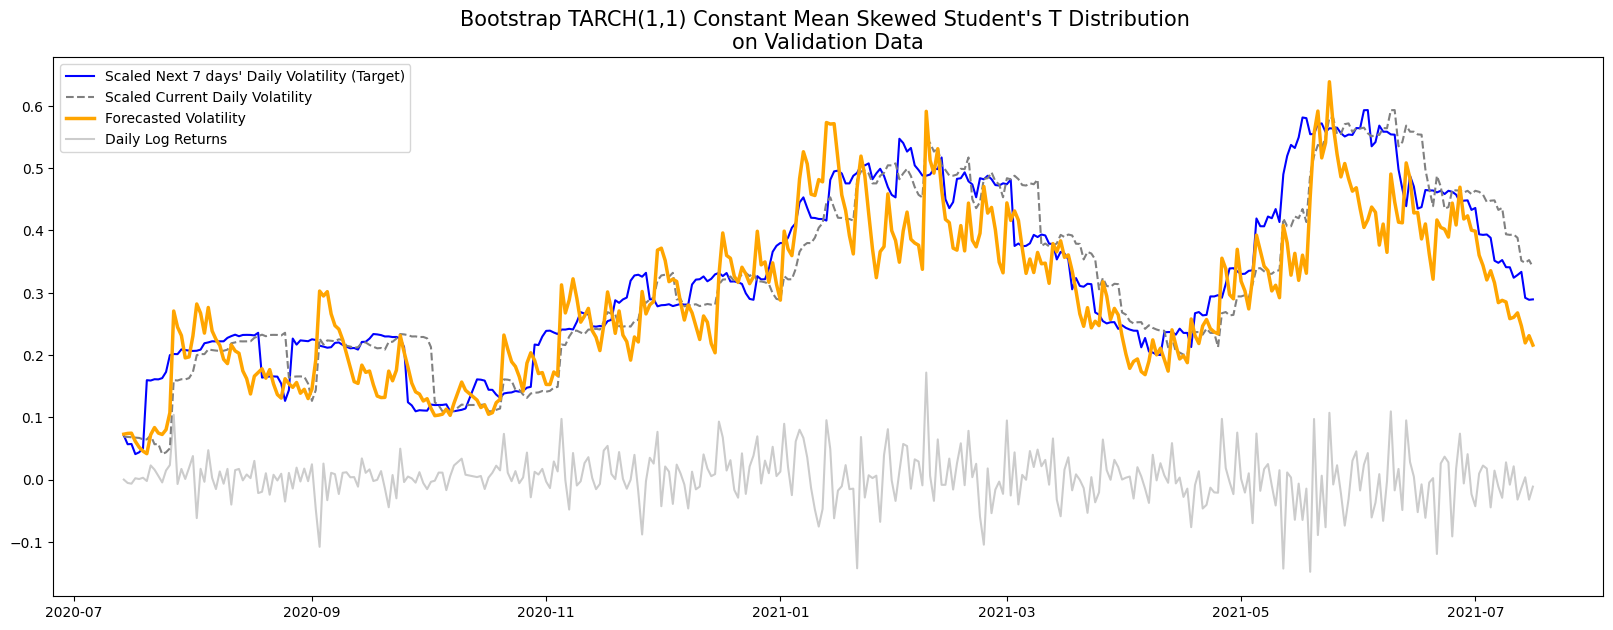

In [168]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_gm_1_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

The forecasted volatility does sync up more nicely with target than all other models. This is promising...

In [169]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_gm_1_preds_scaled, 
         "Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136064
1                             Random Walk Naive Forecasting  ...         0.052586
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3  Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652

[5 rows x 3 columns]

Bootstrap TARCH(1,1) has managed to achieve a lower Validation RMSPE than Naive Forecasting!!! Even RMSE is only a bit higher, but so far this has been the best model among all GARCH family members that I've found. 

(I'm not liking the ConvergenceWarning messages that TARCH produces during training though...)

#### **Simulation-based Forecasting for TARCH(1,1)**



In [170]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_gm_2_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  Converge

In [171]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_gm_2_preds_scaled = pd.Series(scaler_tarch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                index=val_idx)

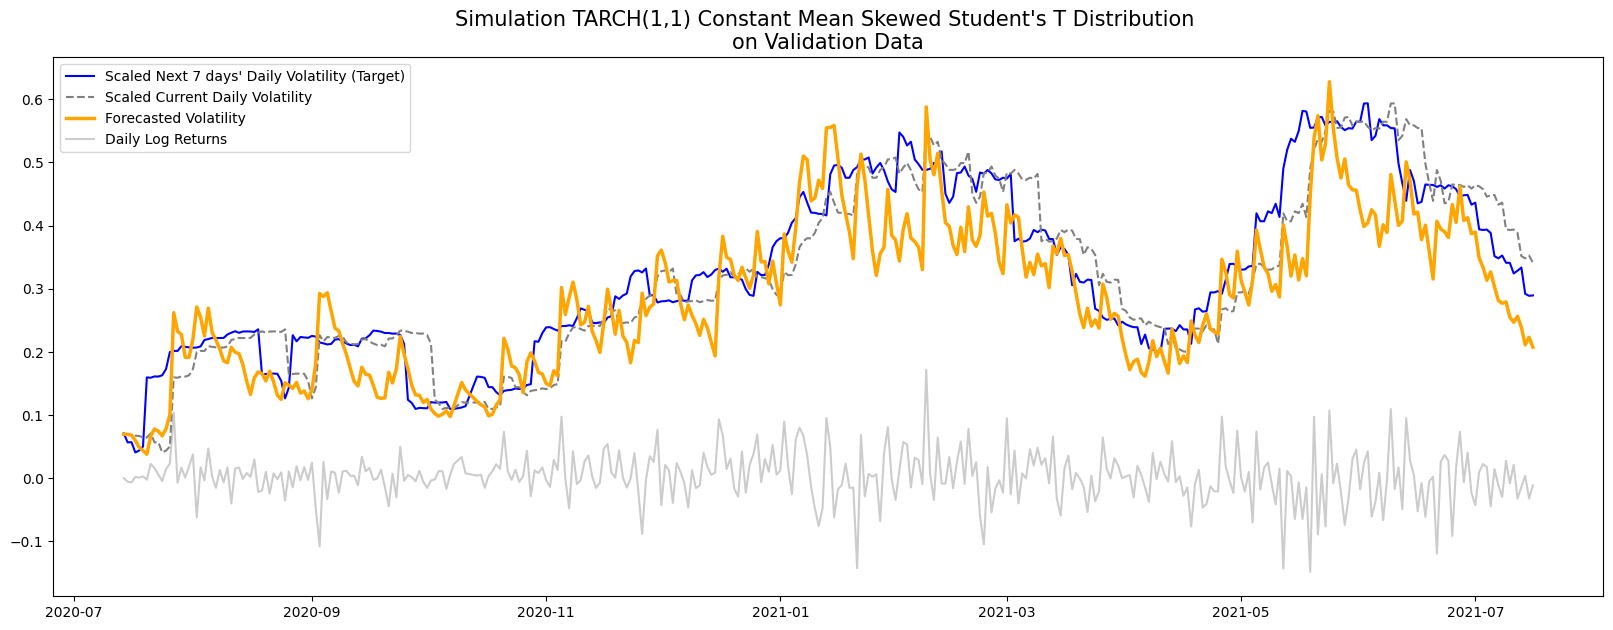

In [172]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_gm_2_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [173]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_gm_2_preds_scaled, 
         "Simulation TARCH(1,1) | Constant Mean | Skewt Dist")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136064
1                             Random Walk Naive Forecasting  ...         0.052586
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3  Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5        Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170

[6 rows x 3 columns]

Among the 2 forecasting methods, bootstrap seems to perform better on TARCH(1,1). It's probably because bootstrap uses historical data in to compute rather than using the assumed distribution of the residuals.

### **p/q/o Tuning for TARCH**

Next, I'll create a range of values for p, q and o from 0 to 2 (inclusive), and then record each's model's performance on unseen data using RMSPE. Since `p` cannot take a value of `0`, I'll eliminate that from the list of permutations. 

In [174]:
import itertools

In [ ]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = pd.Series(sclr.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                               index=val_idx)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

In [185]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.21308298179184104 using TARCH(2, 2, 0)


In [186]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

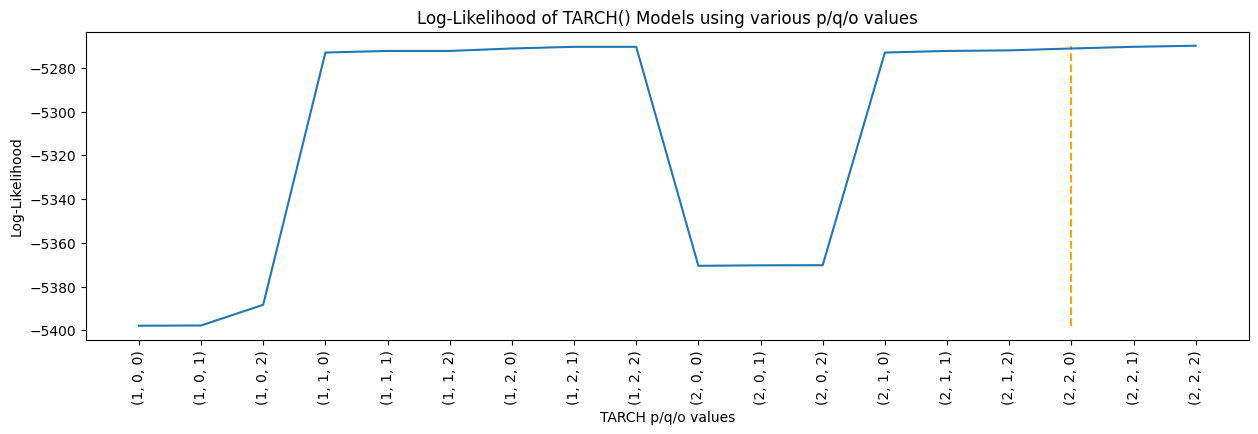

In [194]:
plt.figure(figsize=(15,4))
plt.plot([str(v) for v in pqo_s], LLH_s)
plt.xticks(rotation=90)

plt.vlines(x=str(best_pqo), 
           ls='--', color='orange',
           ymin=np.min(LLH_s), ymax=np.max(LLH_s))

plt.xlabel('TARCH p/q/o values')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood of TARCH() Models using various p/q/o values')
plt.show();

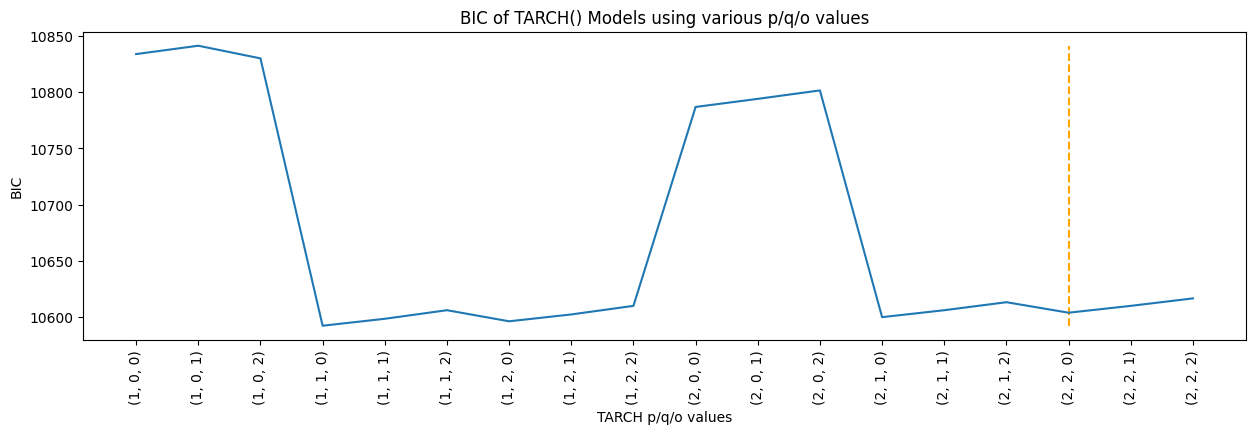

In [195]:
plt.figure(figsize=(15,4))
plt.plot([str(v) for v in pqo_s], bic_s)
plt.xticks(rotation=90)

plt.vlines(x=str(best_pqo), 
           ls='--', color='orange',
           ymin=np.min(bic_s), ymax=np.max(bic_s))

plt.xlabel('TARCH p/q/o values')
plt.ylabel('BIC')
plt.title('BIC of TARCH() Models using various p/q/o values')
plt.show();

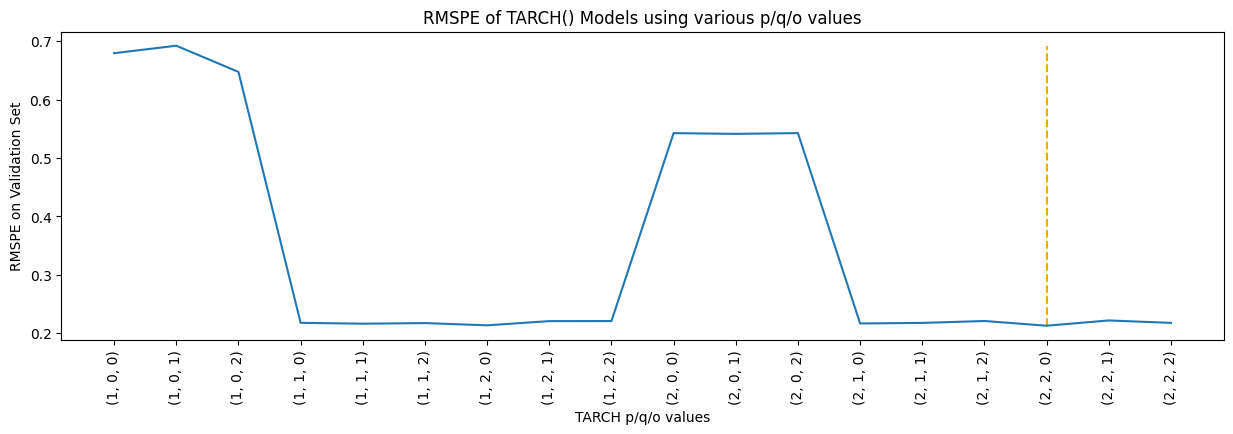

In [193]:
plt.figure(figsize=(15,4))
plt.plot([str(v) for v in pqo_s], rmspe_s)
plt.xticks(rotation=90)

plt.vlines(x=str(best_pqo), 
           ls='--', color='orange',
           ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))

plt.xlabel('TARCH p/q/o values')
plt.ylabel('RMSPE on Validation Set')
plt.title('RMSPE of TARCH() Models using various p/q/o values')
plt.show();

So it seems (2,2,0) yields lowest RMPSE on validation set among all the variants I've tried. I'm going to create another TARCH model with this paramaters to see how the results would look like.

### **TARCH(2,2)**

In [190]:
t_gm_220 = arch_model(r_train, p=2, q=2, o=0, power=1.0,
                  dist='skewt')
result_4 = t_gm_220.fit(disp='off')
print(result_4.summary())

                          Constant Mean - AVGARCH Model Results                          
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                               AVGARCH   Log-Likelihood:               -5271.20
Distribution:      Standardized Skew Student's t   AIC:                           10558.4
Method:                       Maximum Likelihood   BIC:                           10603.6
                                                   No. Observations:                 2096
Date:                           Sun, Aug 22 2021   Df Residuals:                     2095
Time:                                   20:16:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [191]:
scaler_t_gm_220_vol = MinMaxScaler()

t_gm_220_cond_vol_arr = result_4.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
scaler_t_gm_220_vol = scaler_t_gm_220_vol.fit(t_gm_220_cond_vol_arr)
scaled_t_gm_220_cond_vol = pd.Series(scaler_t_gm_220_vol.transform(t_gm_220_cond_vol_arr)[:,0],
                                     index=train_idx)

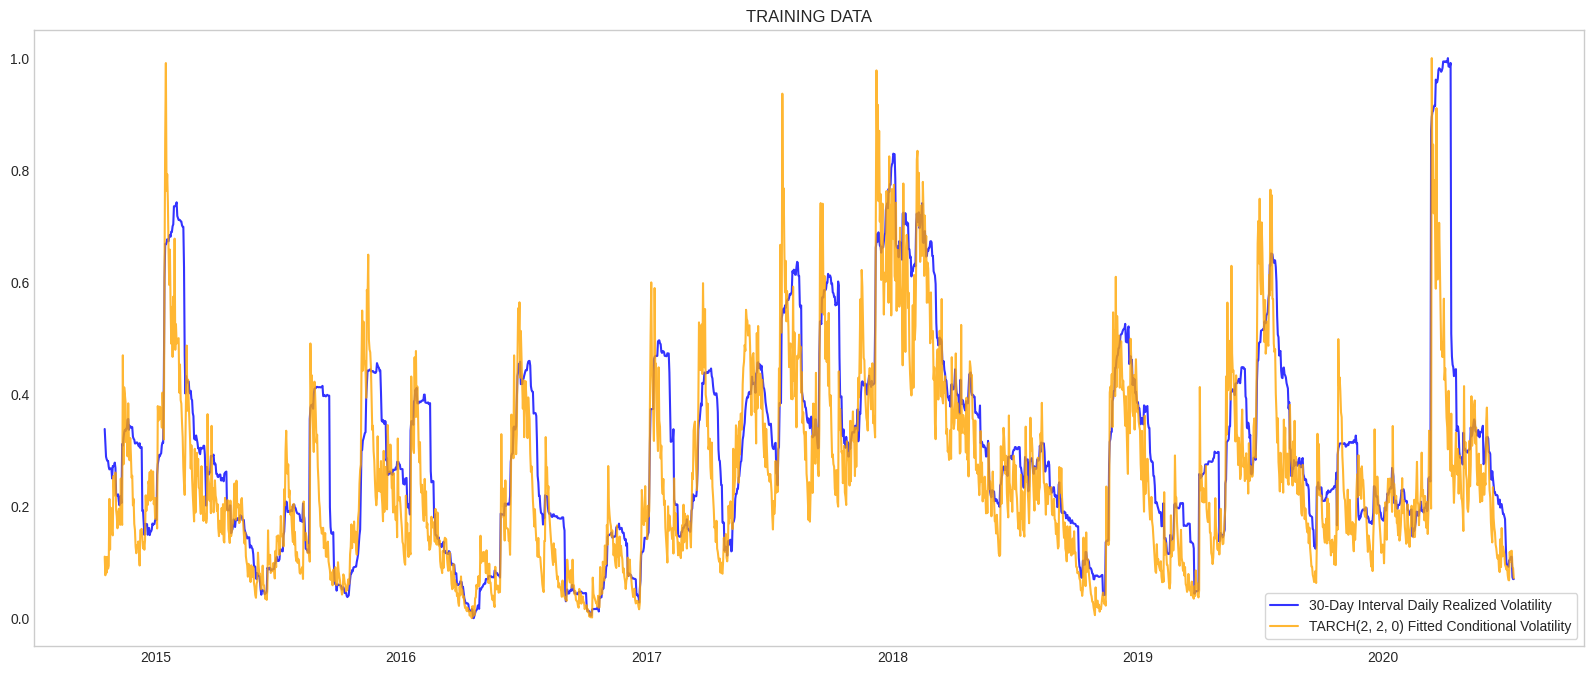

In [491]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'{INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
ax.plot(scaled_t_gm_220_cond_vol, color='orange', alpha=0.8,
        label=f'TARCH{best_pqo} Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend(frameon=True, loc='best')
plt.savefig(os.path.join(directory_to_img, 'tarch_cond_vol.jpg'), dpi=300, bbox_inches='tight')

plt.show();

In [197]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=2, q=2, o=0, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_gm_220_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [198]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_gm_220_preds_scaled = pd.Series(scaler_t_gm_220_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                  index=val_idx)

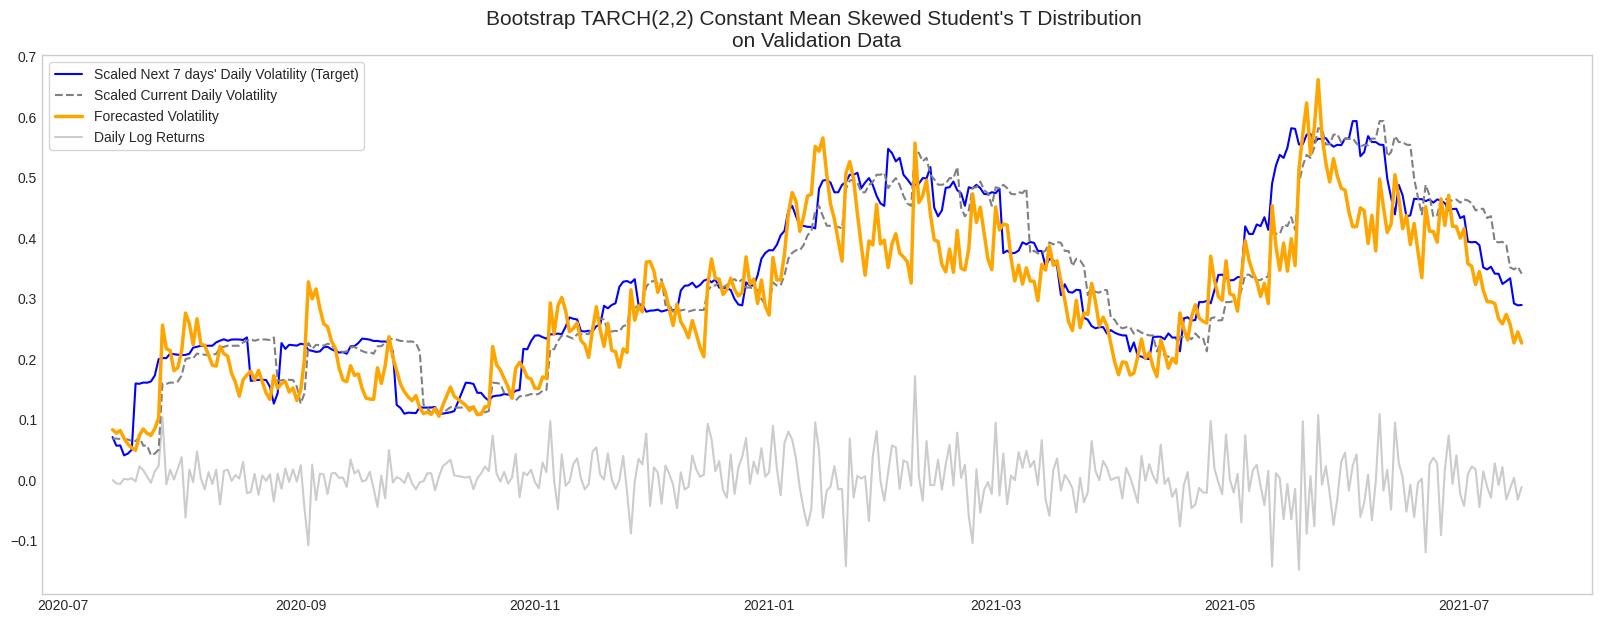

In [492]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_gm_220_preds_scaled, 
          "Bootstrap TARCH(2,2) Constant Mean Skewed Student's T Distribution")
plt.savefig(os.path.join(directory_to_img, 'tarch_22_preds.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [200]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_gm_220_preds_scaled, 
         "Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136064
1                             Random Walk Naive Forecasting  ...         0.052586
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3  Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5        Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6         Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847

[7 rows x 3 columns]

## **Model #4 - Neural Networks**

While GARCH remains the gold standard for volatility prediction within traditional financial institutions, there has been an increasing numbers of professionals and researchers turning to Machine Learning, especially Neural Networks, to gain insights into the financial markets in recent years.

(Reference: **Positional Option Trading** - Euan Sinclair)

Traders' theory of the market being inherently efficient (Efficient Market Hypothesis or EHM) states that share prices reflects all information and consistently outperforming the overall market is impossible. The more efficient a market is, the more random and unpredictable the returns will be, and thus **a perfectly efficient market will be completely unpredictable**. 

There are other arguments against EMH, and ones of the most prominent one is based on **Behavioral Finance**: compared to the human history of 200,000 years, the market has not been around for that long. For example, equity options have only been traded in liquid, transparent market since the CBOE opened in 1973; and the average lifetime of an S&P500 company is approx. 20 years. It means that some psychological tendencies of human beings have 200,000 years of evidence behind them, and that a lot of the movements of the markets that were driven by participants' behaviors will likely repeat itself at a later point. Therefore the market system cannot be totally random, it must have some patterns. Those patterns are extremely difficult to exploit due to the multitude of factors that interact and drive the market. 

And what could be better than Neural Networks for that?

In [201]:
import tensorflow as tf

In [202]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        from_idx = x_series.index[i-lookback_window+1]
        to_idx = x_series.index[i]
        a = x_series[from_idx:to_idx].values
        dataX.append(a)
        dataY.append(y_series[to_idx])

    return np.array(dataX), np.array(dataY)

In [203]:
from keras import backend as K

In [204]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [205]:
def val_forecast(model):
    forecast = []
    idx = df.index

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(val_idx)):
        # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
        # (including current value)
        from_idx = idx[split_time_1 + i - n_past + 1]
        to_idx = idx[split_time_1 + i]
        pred = model.predict(df.vol_current[from_idx:to_idx].values[np.newaxis])
        forecast.append(pred)

    forecast = np.array(forecast)[:, 0, 0]
    preds = pd.Series(forecast, index=val_idx)

    preds_scaled = pd.Series(scaler_vol.transform(preds.values.reshape(-1,1))[:,0],
                                index=val_idx)
    return preds_scaled

In [214]:
def viz_train_val_metrics(model_hist):
    fig, ax = plt.subplots(figsize=(20,8))

    # PLOT MSE - LEFT Y-AXIS
    # TRAINING
    ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['loss'], color='lightblue',
                label='Training MSE')
    # VALIDATION
    ln12 = ax.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['val_loss'], color='darkblue',
                label='Validation MSE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['rmspe'], color='pink',
                label='Training RMSPE')
    ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['val_rmspe'], color='red',
                label='Validation RMSPE')
    ax2.set_ylabel('RMSPE')

    # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
    lns = ln11 + ln12 + ln21 + ln22
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best')

    ax.set_title('Training vs. Validation Loss Metrics', fontsize=15)
    plt.show();

### **Neural Network Baseline Metrics - Fully Connected Network**

This is essentially Linear Regression.

(Training directly using scaled volatility produces `inf` RMSPE, so I'll stick with the original volatility, and scale the forecasts later).

I will start with using a lookback window `n_past` of 14, and then gradually adjust that value based on the outcomes of my models.

In [207]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 14)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


In [208]:
# FIT MODEL TO TRAINING DATASET
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100, verbose=1,
                      validation_data=(mat_X_val, mat_y_val),
                      batch_size=batch_size, shuffle=True)

Epoch 1/100
33/33 [==============================] - 1s 6ms/step - loss: 1.4515e-04 - rmspe: 0.3353 - val_loss: 4.3891e-05 - val_rmspe: 0.1942
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 1.3225e-04 - rmspe: 0.3325 - val_loss: 4.5474e-05 - val_rmspe: 0.1989
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 1.2435e-04 - rmspe: 0.3292 - val_loss: 4.0628e-05 - val_rmspe: 0.1878
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 1.1807e-04 - rmspe: 0.3248 - val_loss: 4.0929e-05 - val_rmspe: 0.1844
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 1.1197e-04 - rmspe: 0.3129 - val_loss: 3.7295e-05 - val_rmspe: 0.1779
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 1.0675e-04 - rmspe: 0.3074 - val_loss: 3.6008e-05 - val_rmspe: 0.1747
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 1.0212e-04 - rmspe: 0.3038 - val_loss: 3.4593e-05 - val_rmspe: 0.1710

In [209]:
snn_1_preds_scaled = val_forecast(snn_1)

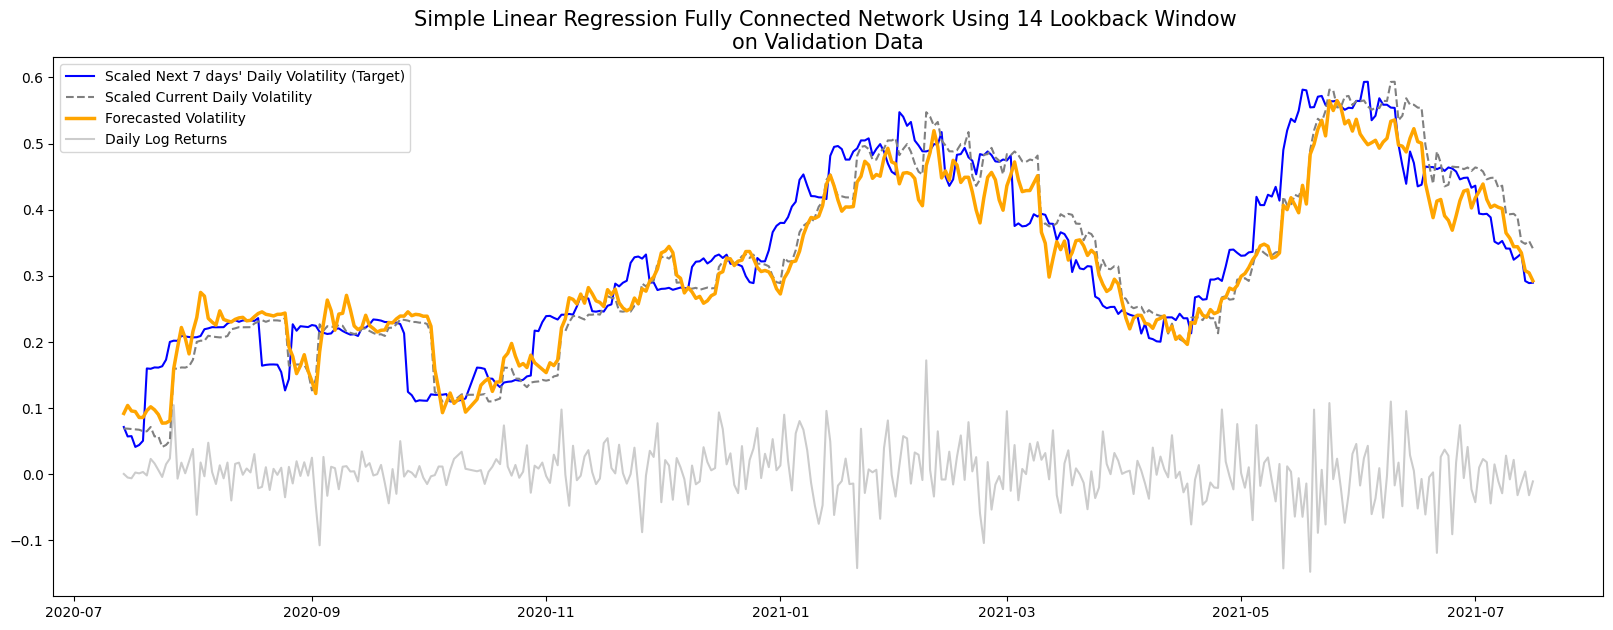

In [210]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")

The forecast is tracing the current volatility line very closely, but is definitely lagging behind compared to my target values.

In [211]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN | n_past={n_past}")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136064
1                             Random Walk Naive Forecasting  ...         0.052586
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3  Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5        Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6         Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                  Simple LR Fully Connected NN | n_past=14  ...         0.052628

[8 rows x 3 columns]

A simple Fully Connected NN doesn't perform too bad. Validation RMSPE after 100 epochs of training and barely any tuning is a bit higher than best TARCH(2,2) model, while RMSE is actually lower. 

### **Univariate Long Short-Term Memory (LSTM)**

(Reference: Geron(2019))

There's a class of Neural Networks called **Recurrent Neural Networks (RNN)** that can "predict the future". RNN works well with time series data, such as stock prices, and can even process sentences, documents, audio samples as inputs. Another application of RNN is in autonomic driving systems, where they're used to anticipate vehicle trajectories and help avoid accidents.

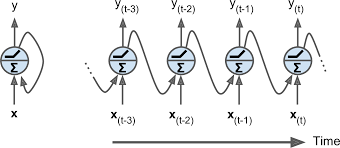

At each time step `t`, the recurrent neuron receives input $x_{t}$ as well as its own output from the previous time step $y_{t-1}$. Since the output of a Recurrent Neuron is a function of all the inputs from the previous time steps, it has a form of *memory* and able to preserve some information through time.

However, due to certain transformations that the data goes through when traversing down RNN, some information is lost at each time step, and for a long sequence, the RNN's state contains virtually no information from the first inputs. 

**Long Short-Term Memory (LSTM)** was proposed in 1997 by Sepp Hochreiter and Jurgen Schmidhuber. The key part of LSTM is that the network can learn what's important and needs to be stored in the long-term state, and what can be ignored. LSTM looks very similar to a regular RNN cell, but its state is split into 2 vectors:
- $h_{t}$ - for short term state
- $c_{t}$ - for long term state

LSTM is a black box, and can be used like a basic Recurrent Neural Network (RNN) cell. However, it tends to perform much better, helps training converge faster, and also detect long-term dependencies in the data.

LSTM uses an **optimized implementation when running on a GPU**, that's why it's highly recommended to run this second part of the notebook on **Google Colab**.


In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

First, I'm going to use the same lookback window `n_past` as the previous Neural Networks (14), and then depending on the result, I'll try to fine tune that value later. The purpose of switching to Neural Networks is to extend that lookback window so that hopefully the models can learn to pick up long-term patterns as well.

The first LSTM model would be very simple with only 1 hidden LSTM layer of 20 units. I am using the standard `adam` optimizer here, and would later experiment with other optimizers if needed.

In [213]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
33/33 [==============================] - 3s 24ms/step - loss: 4.7499e-04 - rmspe: 0.8457 - val_loss: 1.0871e-04 - val_rmspe: 0.2810
Epoch 2/200
33/33 [==============================] - 0s 9ms/step - loss: 2.0014e-04 - rmspe: 0.6129 - val_loss: 6.8058e-05 - val_rmspe: 0.1973
Epoch 3/200
33/33 [==============================] - 0s 10ms/step - loss: 1.3908e-04 - rmspe: 0.4247 - val_loss: 4.4022e-05 - val_rmspe: 0.1760
Epoch 4/200
33/33 [==============================] - 0s 9ms/step - loss: 1.3112e-04 - rmspe: 0.3728 - val_loss: 5.0262e-05 - val_rmspe: 0.1702
Epoch 5/200
33/33 [==============================] - 0s 9ms/step - loss: 1.2476e-04 - rmspe: 0.3620 - val_loss: 3.8572e-05 - val_rmspe: 0.1856
Epoch 6/200
33/33 [==============================] - 0s 10ms/step - loss: 1.2190e-04 - rmspe: 0.3616 - val_loss: 4.4395e-05 - val_rmspe: 0.1659
Epoch 7/200
33/33 [==============================] - 0s 10ms/step - loss: 1.1709e-04 - rmspe: 0.3545 - val_loss: 3.8856e-05 - val_rmspe: 0.

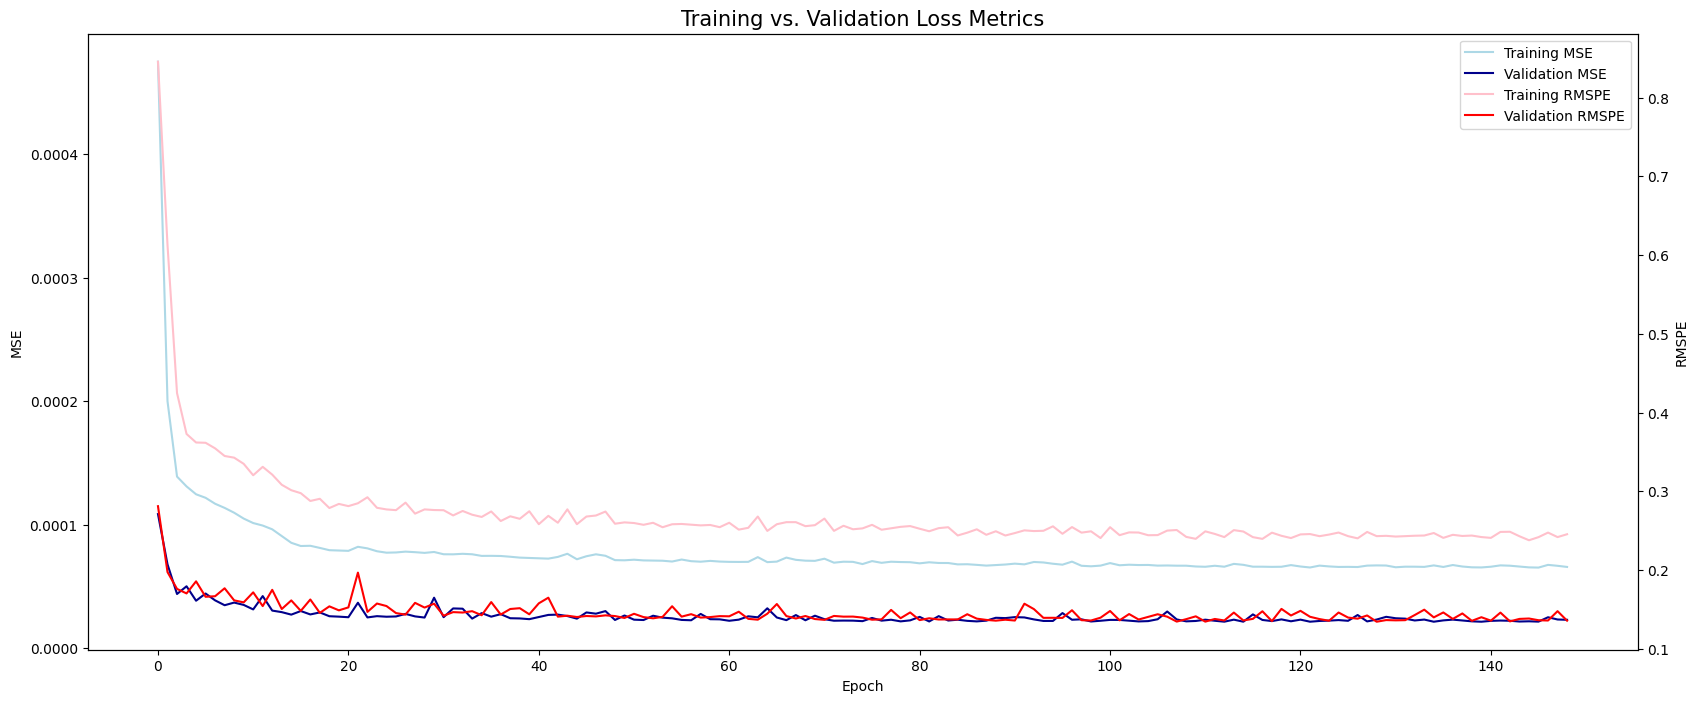

In [215]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

Validation loss has been on the lower side compared to Training, which is not a bad thing. Although all 4 lines look relatively unstable, a general downward trend can be observed.

In [216]:
# FORECASTING ON VALIDATION SET
lstm_1_preds_scaled = val_forecast(lstm_1)

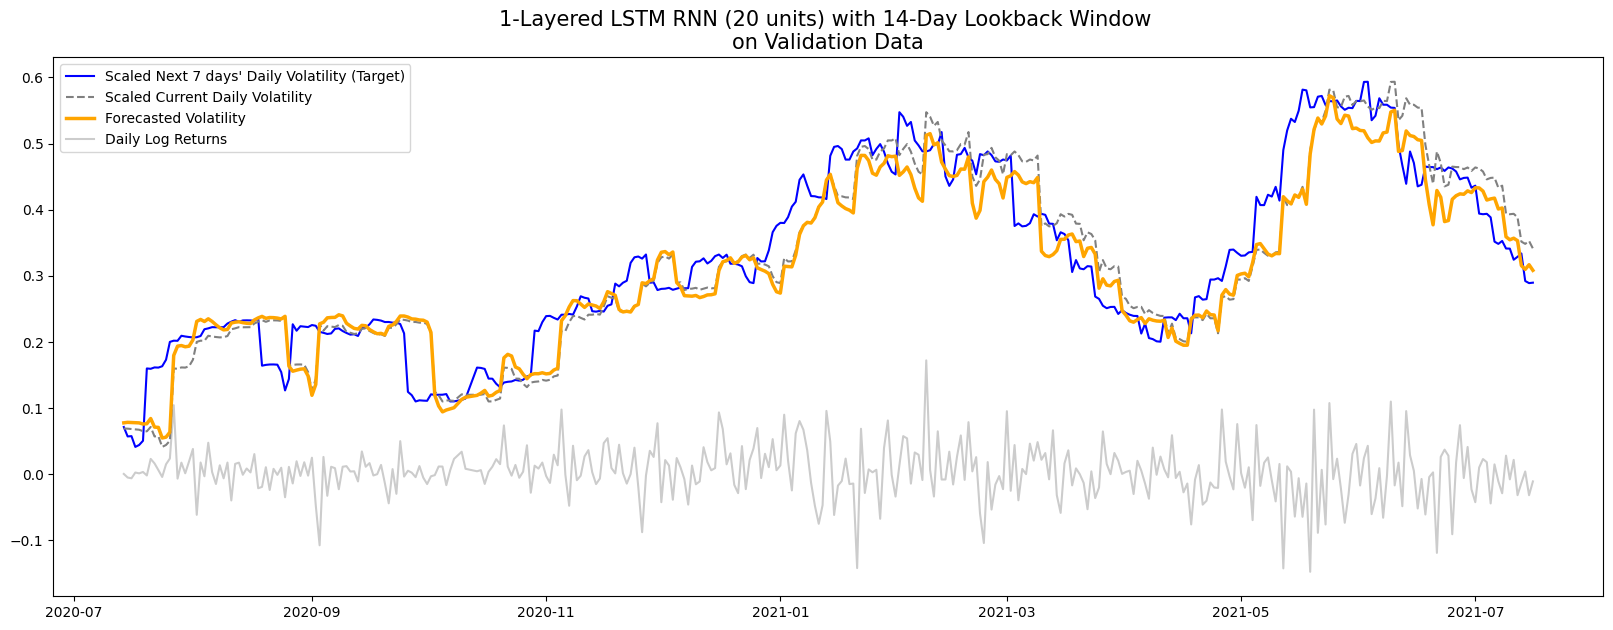

In [217]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")

Again, predictions traces `vol_current` very closely, and is lagging behind compared to desired target. Performance metrics would probably be very similar to those of Naive Forecasting.

In [218]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units | n_past={n_past}")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136064
1                             Random Walk Naive Forecasting  ...         0.052586
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3  Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5        Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6         Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                  Simple LR Fully Connected NN | n_past=14  ...         0.052628
8                         LSTM 1 layer 20 units | n_past=14  ...         0.051179

[9 rows x 3 columns]

### **Bidirectional LSTM**

(Reference: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence)

Further research shows that there's an extension of LSTM cell called **Bidirectional LSTM**, which could potentially be better in this case by providing additional context to the models. Since all timesteps of the input sequence are already available, Bidirectional LSTM could train 2 instead of 1 LSTMs on the same input sequence:
- 1st one on the inputs as-is
- 2nd one on the reversed copy of the inputs

This could help provide additional context to the networks, and usually produces faster and fuller learning on the problem.

LSTM allows the maintenance of certain long-term memories across time, thereofore I'll extend `n_past` to 1 month, and also increase the number of hidden layers to see if the model can capture more patterns.

In [219]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________
None


In [220]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
33/33 [==============================] - 9s 91ms/step - loss: 4.1412e-04 - rmspe: 0.7971 - val_loss: 1.3179e-04 - val_rmspe: 0.2319
Epoch 2/200
33/33 [==============================] - 2s 48ms/step - loss: 1.8546e-04 - rmspe: 0.5175 - val_loss: 5.9262e-05 - val_rmspe: 0.1788
Epoch 3/200
33/33 [==============================] - 2s 49ms/step - loss: 1.3510e-04 - rmspe: 0.3998 - val_loss: 3.8285e-05 - val_rmspe: 0.1791
Epoch 4/200
33/33 [==============================] - 2s 48ms/step - loss: 1.1031e-04 - rmspe: 0.3641 - val_loss: 3.1898e-05 - val_rmspe: 0.1413
Epoch 5/200
33/33 [==============================] - 2s 47ms/step - loss: 9.9457e-05 - rmspe: 0.3395 - val_loss: 2.5748e-05 - val_rmspe: 0.1425
Epoch 6/200
33/33 [==============================] - 2s 47ms/step - loss: 9.3991e-05 - rmspe: 0.3222 - val_loss: 2.5043e-05 - val_rmspe: 0.1382
Epoch 7/200
33/33 [==============================] - 2s 49ms/step - loss: 8.8347e-05 - rmspe: 0.3101 - val_loss: 2.4534e-05 - val_rmspe:

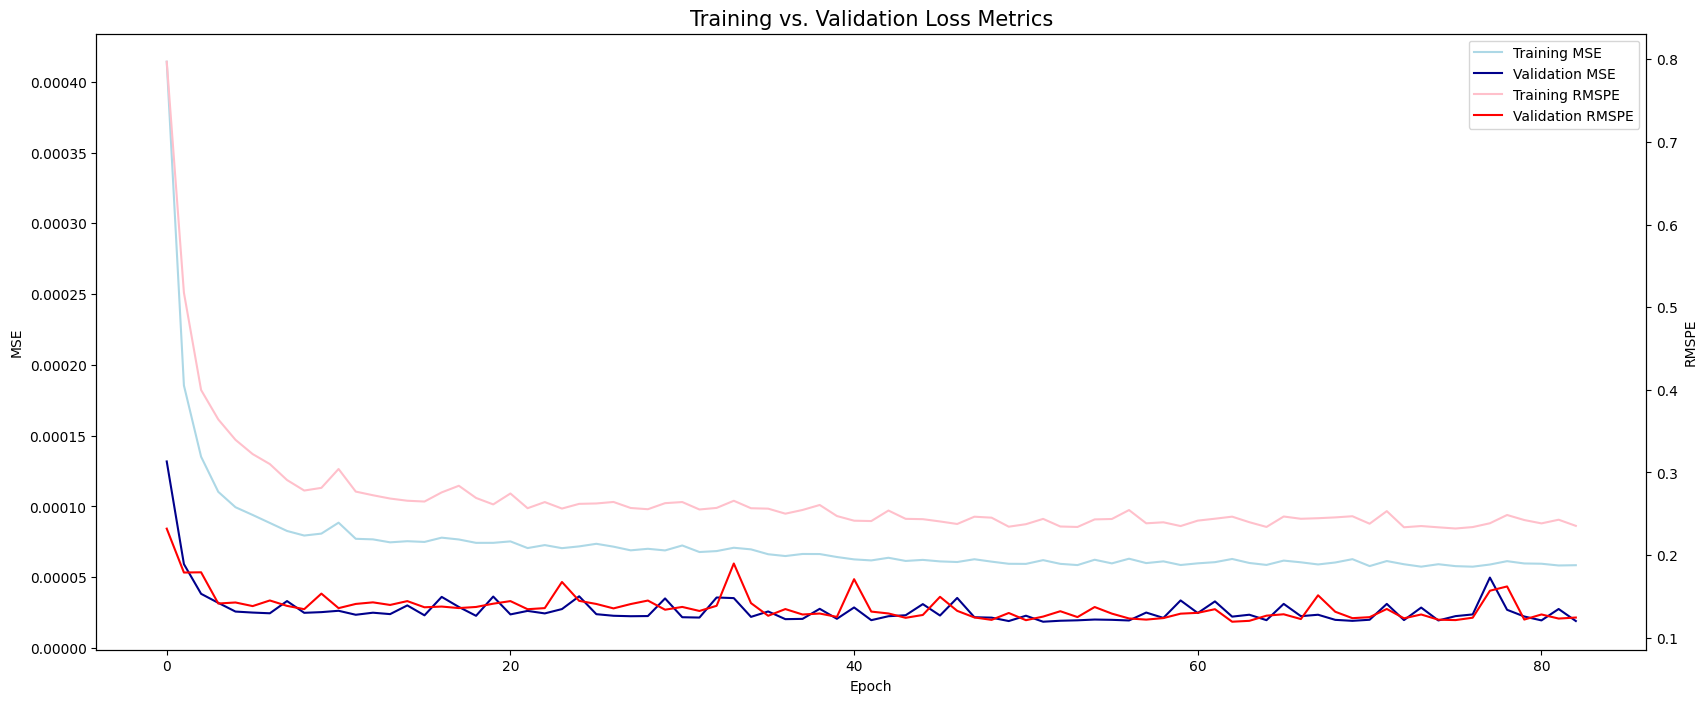

In [221]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [223]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_2_preds_scaled = val_forecast(lstm_2)

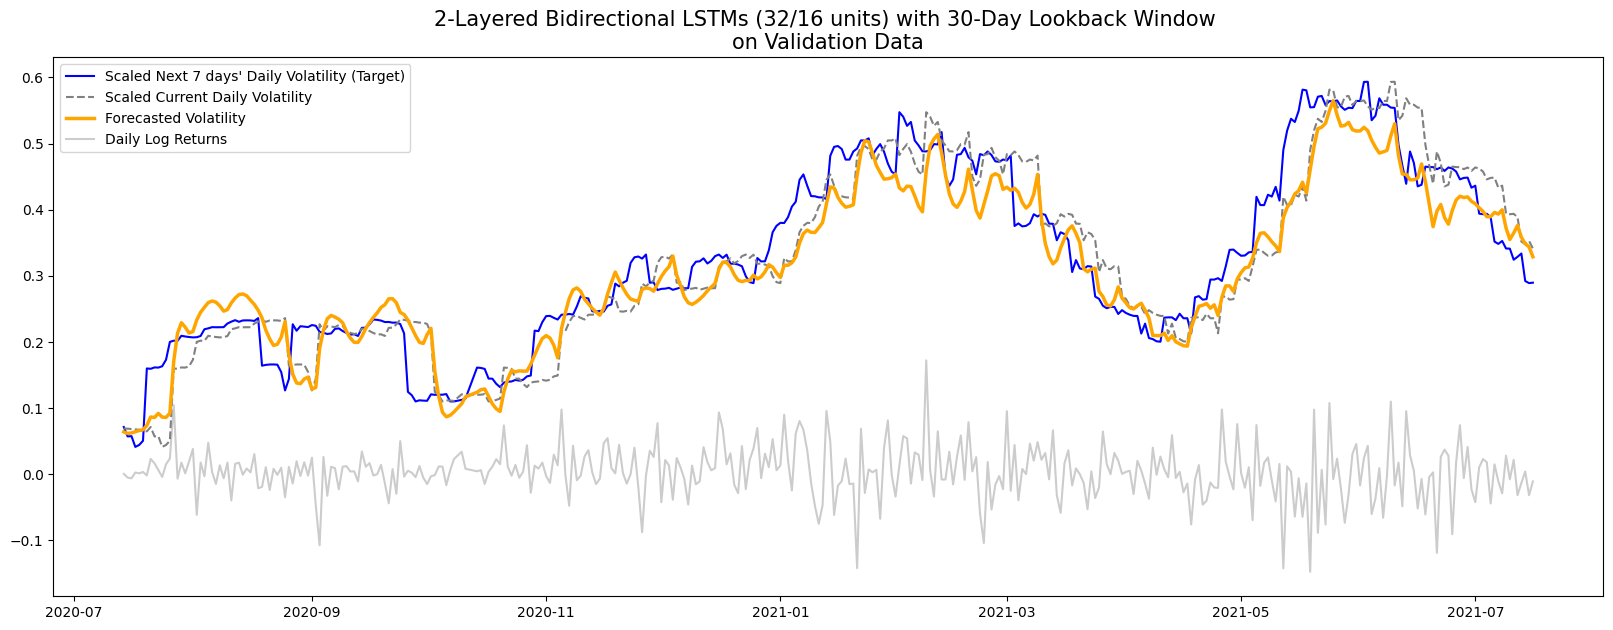

In [224]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")

In [225]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units) | n_past={n_past}")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136064
1                             Random Walk Naive Forecasting  ...         0.052586
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3  Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5        Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6         Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                  Simple LR Fully Connected NN | n_past=14  ...         0.052628
8                         LSTM 1 layer 20 units | n_past=14  ...         0.051179
9          2 layers Bidirect LSTM (32/16 units) | n_past=30  ...         0.048534

[10 rows x 3 columns]

2 Layered Bidirectional LSTMs with a lookback window of 30 days has managed to beat the best GARCH model (TARCH(2,2)) found above, which means I'm probably heading in the right direction!

In my other Exploratory Notebooks I have experimented with different activation functions and network structures, such as:
- using `activation='relu'` or `activation='sigmoid'`
- increasing the number of hidden LSTM layers
- increasing number of units in each LSTM layer
- adding in Dropout layer with different dropout percentage
- changing `batch_size`

However, none of them have outperform the simple architecture above (2 layers of Bidirectional LSTMs with 32 and 16 units, and `n_past=30`). 

### **Adding 1D Convolutional Layers**

(Reference: Geron (2019))

A 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). 

Convolutional layers are supposed to allow lookback window extension, and help the model pick up patterns further in the past. That's why I want to try it here.

In [228]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# INCREASING n_past TO 2 MONTHS
n_past = 60
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          160       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 27,201
Trainable params: 27,201
Non-trainable params: 0
_________________________________________________________________
None


In [229]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
32/32 [==============================] - 7s 78ms/step - loss: 3.9942e-04 - rmspe: 0.8011 - val_loss: 1.7483e-04 - val_rmspe: 0.2995
Epoch 2/200
32/32 [==============================] - 2s 58ms/step - loss: 2.7136e-04 - rmspe: 0.6904 - val_loss: 1.3063e-04 - val_rmspe: 0.2766
Epoch 3/200
32/32 [==============================] - 2s 58ms/step - loss: 2.3604e-04 - rmspe: 0.6098 - val_loss: 1.0167e-04 - val_rmspe: 0.2523
Epoch 4/200
32/32 [==============================] - 2s 58ms/step - loss: 2.0946e-04 - rmspe: 0.5310 - val_loss: 8.3295e-05 - val_rmspe: 0.2287
Epoch 5/200
32/32 [==============================] - 2s 57ms/step - loss: 1.8846e-04 - rmspe: 0.4919 - val_loss: 6.8774e-05 - val_rmspe: 0.2074
Epoch 6/200
32/32 [==============================] - 2s 57ms/step - loss: 1.7292e-04 - rmspe: 0.4444 - val_loss: 5.7293e-05 - val_rmspe: 0.2025
Epoch 7/200
32/32 [==============================] - 2s 58ms/step - loss: 1.5092e-04 - rmspe: 0.4349 - val_loss: 5.8437e-05 - val_rmspe:

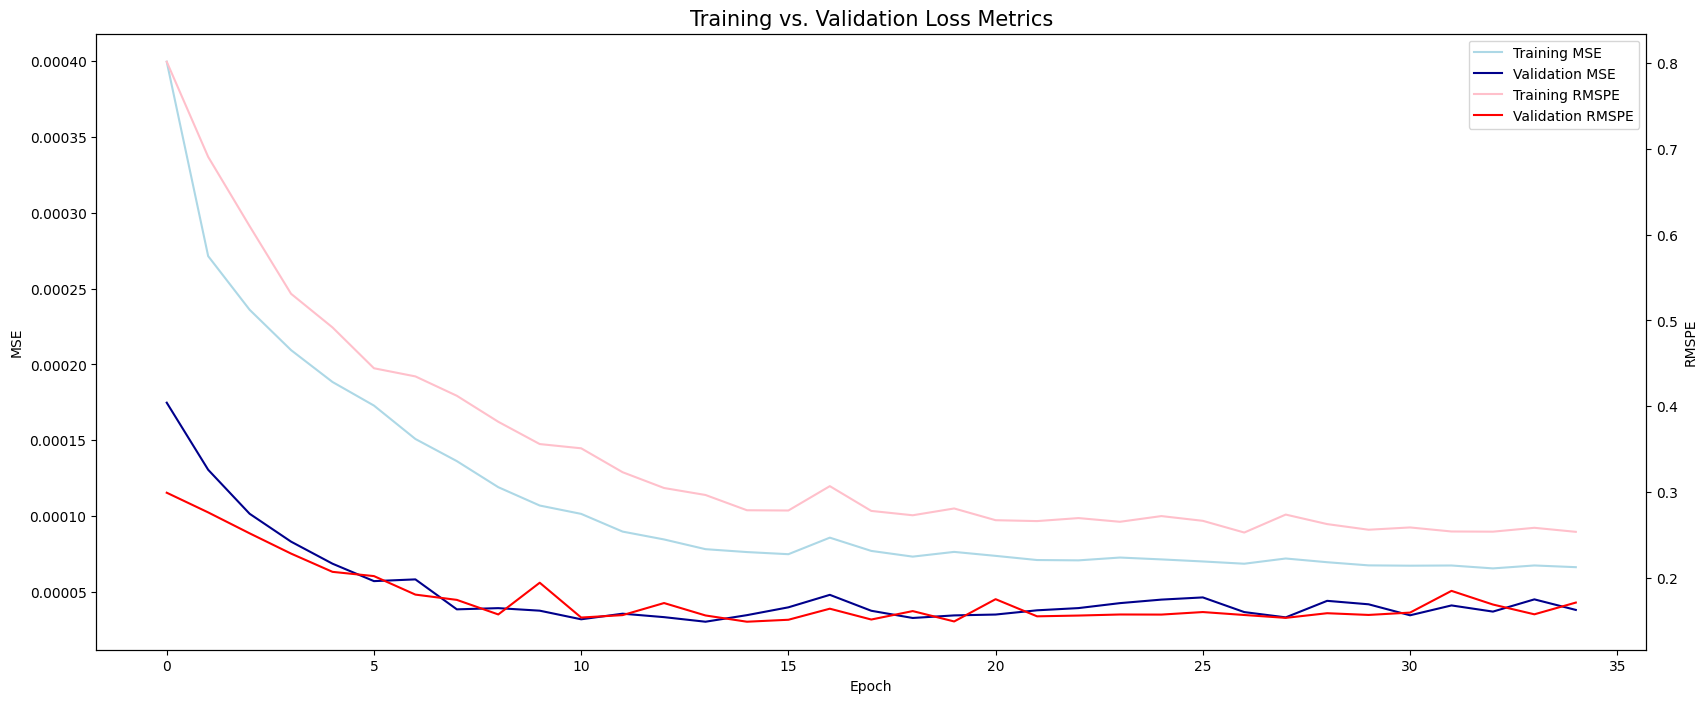

In [230]:
# VISUALIZING TRAINING/VALIDATION METRICS
viz_train_val_metrics(lstm_3_res)

Convolutional layers has helped smoothing out the learning curves quite a bit.

In [232]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_3_preds_scaled = val_forecast(lstm_3)

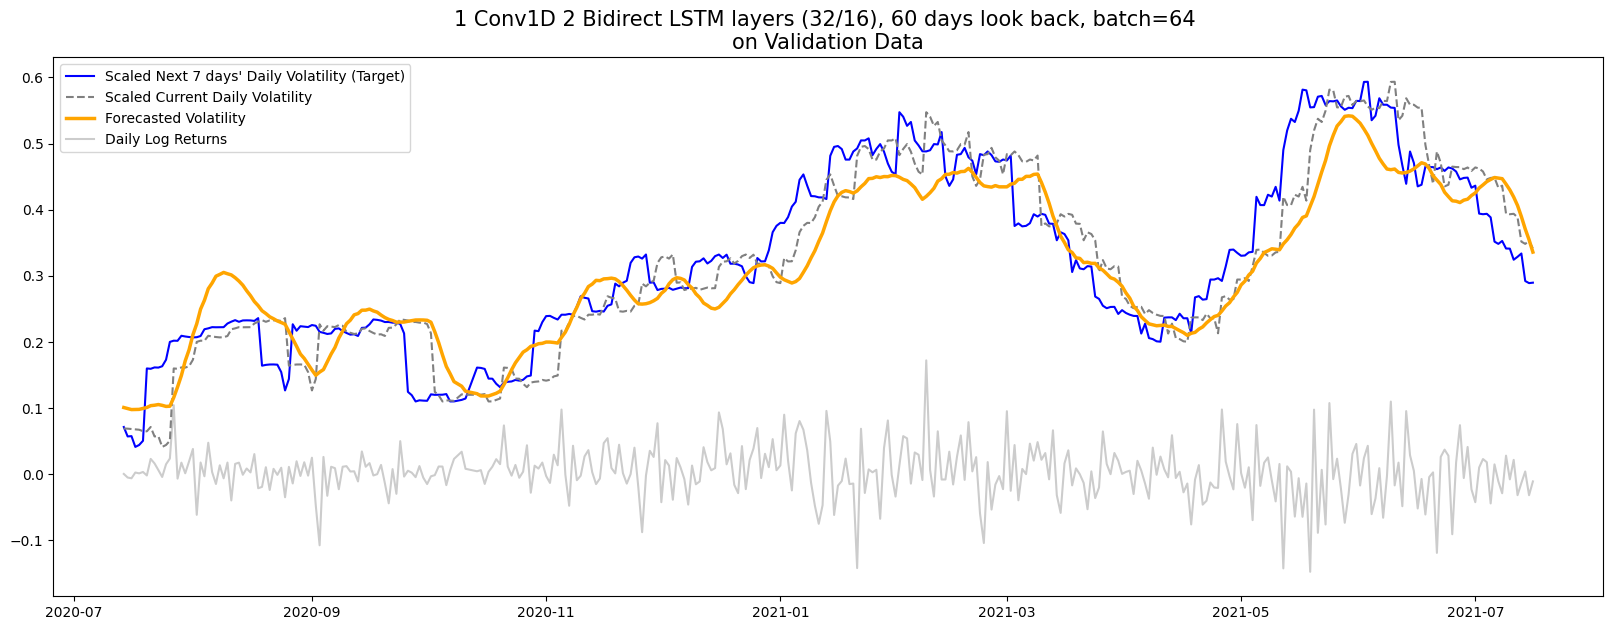

In [233]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")

In [234]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past={n_past} | batch={batch_size}")

Model  ...  Validation RMSE
0                                                    Mean Baseline  ...         0.136064
1                                    Random Walk Naive Forecasting  ...         0.052586
2                         GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3         Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4                Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5               Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6                Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                         Simple LR Fully Connected NN | n_past=14  ...         0.052628
8                                LSTM 1 layer 20 units | n_past=14  ...         0.051179
9                 2 layers Bidirect LSTM (32/16 units) | n_past=30  ...         0.048534
10  1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=60 | batch=64  ...         0.060564

[11 rows x 3 columns]

This setup of Convolutional layers aren't really helping here. 

(Reference: Geron (2019))

In my other Exploratory Notebooks I have also experimented with a simplified version of **WaveNet**, an architecture proposed by Aaron van den Oord and other DeepMind researchers in 2016.

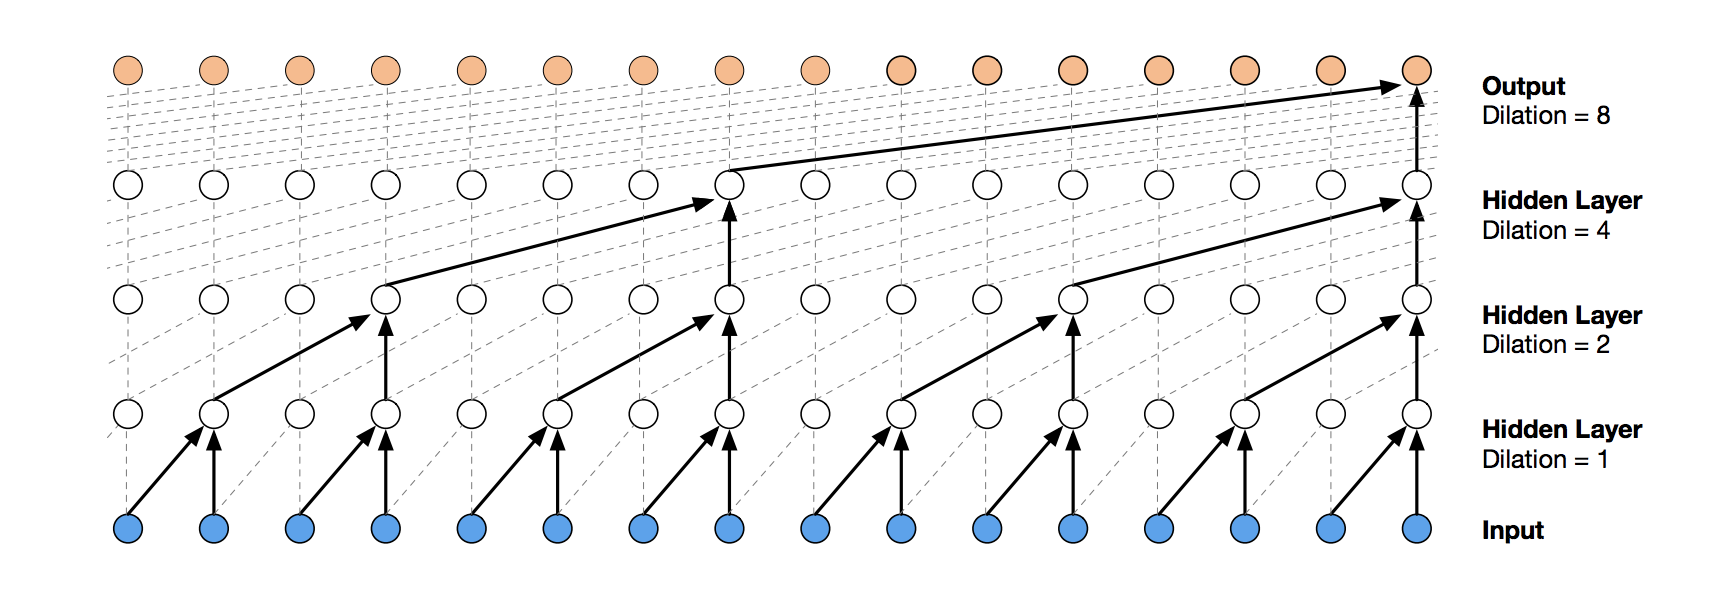

WaveNet was created by stacking 1D convolutional layers on top of each other, doubling dilation rate at each layer (dilation rate represents the distance between each neuron's inputs or how spread apart each neuron's inputs are). That way:
- the lower layers learn short-term patterns
- and the higher layers can learn long-term patterns

WaveNet works very well with extremely large sequences, especially audio samples (hence the name), but it's also been found to be very successful with financial time series data in which "significant" events are usually sporadic and rare (meaning the time periods between those events tend to vary).

My version of WaveNet wasn't very successful at picking up more subtle changes in volatility. Honestly I don't think this architecture is not good for this type of data, it's more likely I haven't figured out how to properly implement it yet. This would definitely be one of the potential ideas to further explore in the future.

### **Learning Rate Tuning**

So far I have only used the standard `adam` optimizer. It'd be interesting to see how the model performs on a more customizable optimizer like **Stochastic Gradient Descent (SGD)**. I will continue this with the most successful LSTM architecture so far (2 layers of Bidirectional LSTMs with 32 and 16 units and a lookback window of 30 days).

In [494]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

# EXPONENTIALLY INCREASE LEARNING RATE 
# BY THE POWER OF 10 EVERY 20 EPOCHS
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=160,
                        callbacks=[lr_schedule],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/160
33/33 [==============================] - 10s 100ms/step - loss: 0.0018 - rmspe: 1.0424 - val_loss: 0.0019 - val_rmspe: 1.0429
Epoch 2/160
33/33 [==============================] - 2s 50ms/step - loss: 0.0018 - rmspe: 1.0424 - val_loss: 0.0019 - val_rmspe: 1.0428
Epoch 3/160
33/33 [==============================] - 2s 50ms/step - loss: 0.0018 - rmspe: 1.0424 - val_loss: 0.0019 - val_rmspe: 1.0428
Epoch 4/160
33/33 [==============================] - 2s 50ms/step - loss: 0.0018 - rmspe: 1.0424 - val_loss: 0.0019 - val_rmspe: 1.0428
Epoch 5/160
33/33 [==============================] - 2s 51ms/step - loss: 0.0018 - rmspe: 1.0424 - val_loss: 0.0019 - val_rmspe: 1.0427
Epoch 6/160
33/33 [==============================] - 2s 52ms/step - loss: 0.0018 - rmspe: 1.0422 - val_loss: 0.0019 - val_rmspe: 1.0427
Epoch 7/160
33/33 [==============================] - 2s 50ms/step - loss: 0.0018 - rmspe: 1.0422 - val_loss: 0.0019 - val_rmspe: 1.0426
Epoch 8/160
33/33 [===========================

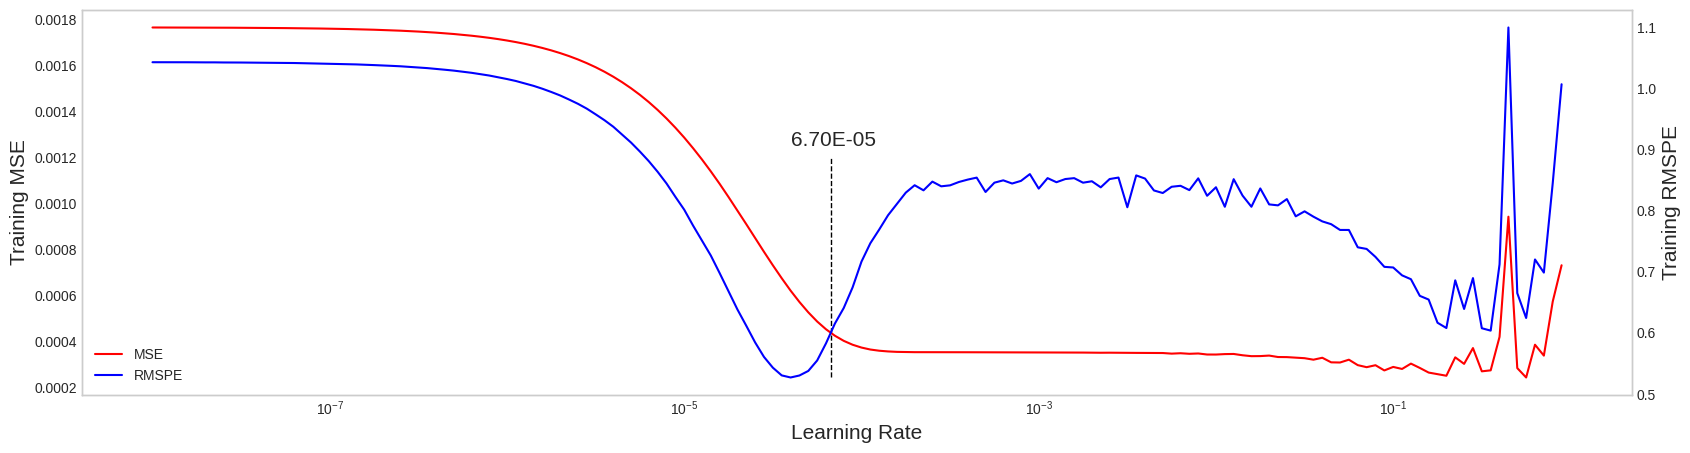

In [500]:
fig, ax = plt.subplots(figsize=(20,5))

# PLOT MSE - LEFT Y-AXIS
ln1 = ax.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['loss'], 
            color='red', label='MSE')
ax.set_xlabel('Learning Rate', fontsize=15)
ax.set_ylabel('Training MSE', fontsize=15)

# PLOT RMSE - RIGHT Y-AXIS
ax2 = ax.twinx()
ln2 = ax2.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['rmspe'],
             color='blue', label='RMSPE')
ax2.set_ylabel('Training RMSPE', fontsize=15)

# COMBINING LALBELS FOR 2 LINES INTO 1 LEGEND
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower left')

best_lr = 6.7e-5

ax.vlines(x=best_lr, ls='--', lw=1,
           ymin=np.min(lstm_4_res.history["loss"]),
           ymax=0.0012)

ax.text(4e-5, 0.00125, '%.2E' % Decimal(best_lr), fontsize=15)

plt.show();

The best learning rate would likely be `6.7e-5` which is the intersection between the RMSE and RMSPE lines. RMSE continues to go down even when Learning Rate approaches `1e-1`, but RMSPE started going up around `4e-5` and gets very unstable quickly after. Next I am going to re-train the model using the best learning rate found above.

In [242]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_4.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
33/33 [==============================] - 9s 93ms/step - loss: 0.0016 - rmspe: 0.9741 - val_loss: 0.0015 - val_rmspe: 0.9064
Epoch 2/200
33/33 [==============================] - 2s 48ms/step - loss: 0.0012 - rmspe: 0.7842 - val_loss: 0.0011 - val_rmspe: 0.7548
Epoch 3/200
33/33 [==============================] - 2s 48ms/step - loss: 9.4211e-04 - rmspe: 0.6390 - val_loss: 8.4768e-04 - val_rmspe: 0.6305
Epoch 4/200
33/33 [==============================] - 2s 47ms/step - loss: 7.4873e-04 - rmspe: 0.5546 - val_loss: 6.6076e-04 - val_rmspe: 0.5312
Epoch 5/200
33/33 [==============================] - 2s 47ms/step - loss: 6.1618e-04 - rmspe: 0.5169 - val_loss: 5.2736e-04 - val_rmspe: 0.4549
Epoch 6/200
33/33 [==============================] - 2s 46ms/step - loss: 5.2529e-04 - rmspe: 0.5154 - val_loss: 4.3333e-04 - val_rmspe: 0.4028
Epoch 7/200
33/33 [==============================] - 2s 48ms/step - loss: 4.6308e-04 - rmspe: 0.5419 - val_loss: 3.6570e-04 - val_rmspe: 0.3697
Epoch 8/

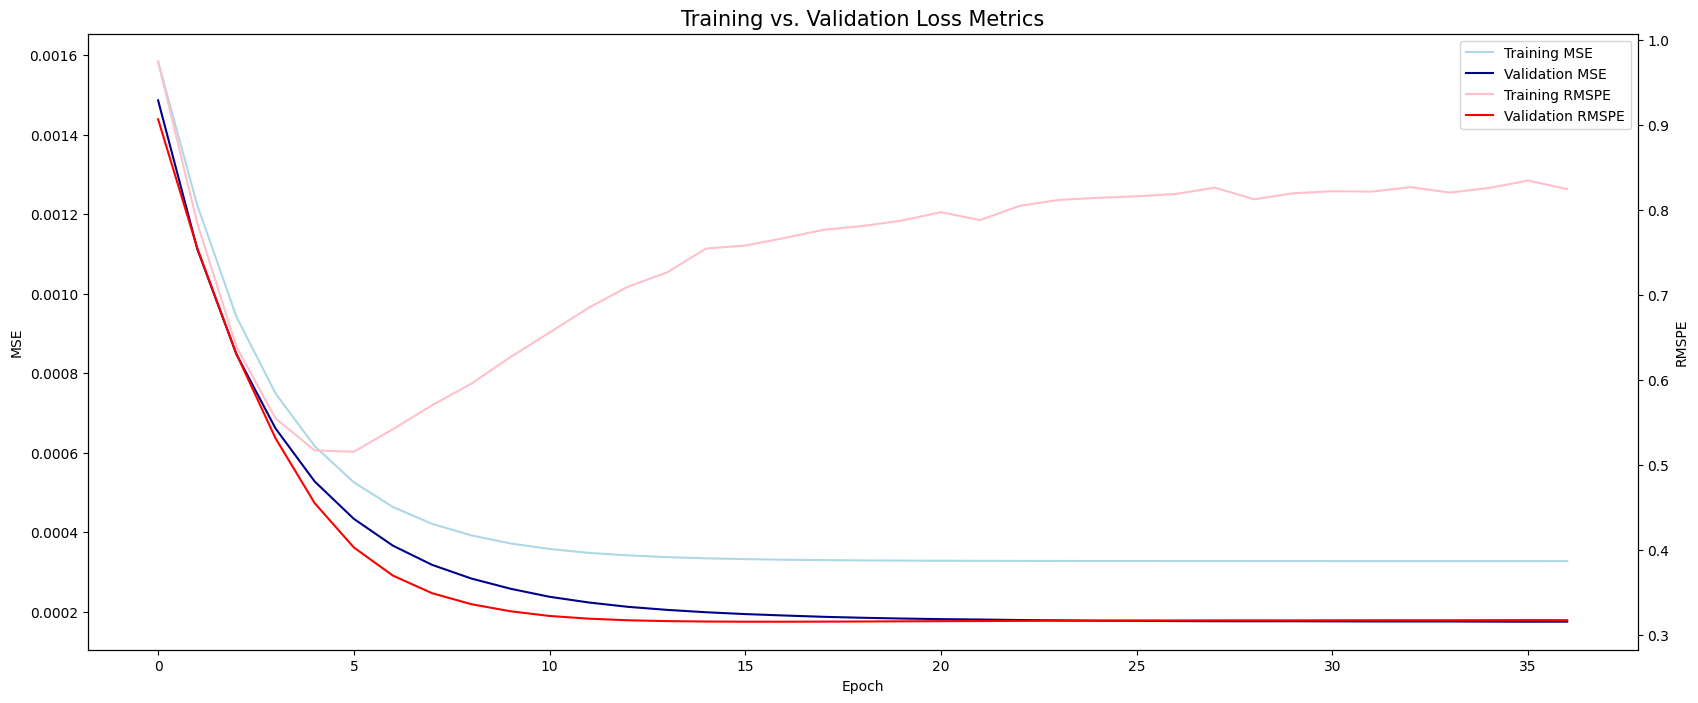

In [243]:
# VISUALIZING TRAINING/VALIDATION LEARNING CURVES
viz_train_val_metrics(lstm_4_res)

Training RMSPE started going up after epoch 5, but surprisingly everything else (including Validation RMSPE) continues to go down until epoch 35 where performance stopped progressing.

In [246]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_4_preds_scaled = val_forecast(lstm_4)

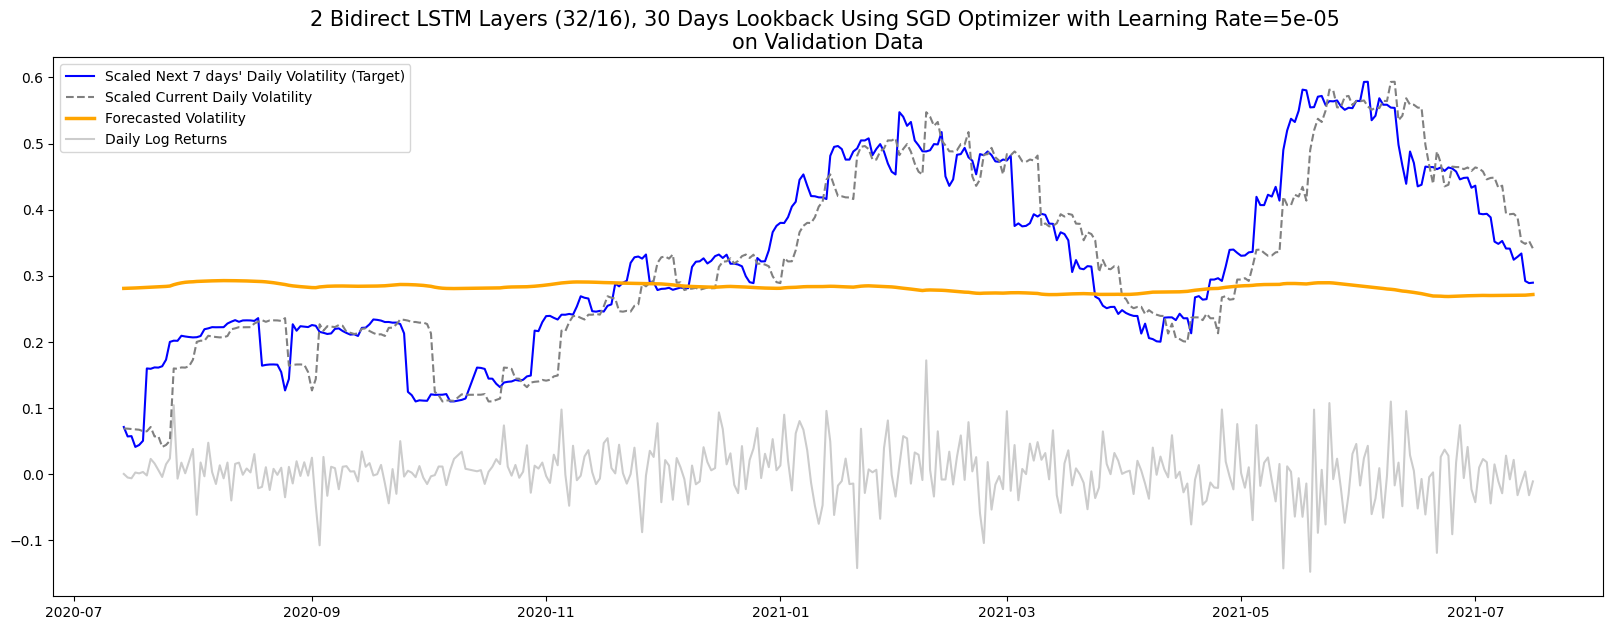

In [247]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_4_preds_scaled, 
          f"2 Bidirect LSTM Layers (32/16), {n_past} Days Lookback Using SGD Optimizer with Learning Rate={best_lr}")

This customized optimizer seems to prioritize volatility's long-term tendency to revert to the mean. Hence the predictions hovers right where the mean is.

In [248]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_4_preds_scaled, 
         f"2 Bidirect LSTMs (32/16) | n_past={n_past} | batch={batch_size} | SGD lr={best_lr}")

Model  ...  Validation RMSE
0                                                    Mean Baseline  ...         0.136064
1                                    Random Walk Naive Forecasting  ...         0.052586
2                         GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3         Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4                Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5               Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6                Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                         Simple LR Fully Connected NN | n_past=14  ...         0.052628
8                                LSTM 1 layer 20 units | n_past=14  ...         0.051179
9                 2 layers Bidirect LSTM (32/16 units) | n_past=30  ...         0.048534
10  1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=60 | batch=64  ...         0.060564
11  2 Bidirect LSTMs (32/16) | n_past=30 | batch=64 | SGD lr=5e-05  ...         0.141783

[12 rows x 3 columns]

It's not a surprise that this model's performance metrics on validation set are quite similar to those of the Baseline model using mean volatility.

## **Multivariate LSTM**

So far I have only using simple 1-dimensional inputs for all of my models, and for financial data, this is likely insufficient. That could be the reason why most of the above models failed to yield better result than Naive Forecasting. It doesn't matter how many neurons or hidden layers are used, or how complex the model's architectures are, inadequate data is not going to produce the best results.

For the next section, I'll attempt to create Multivariate Neural Networks to see if additional features could help improve performance.

In [249]:
df.head()

Open        High  ...  vol_current  vol_future
Date                                ...                         
2014-10-17  382.756012  385.477997  ...     0.039872    0.032900
2014-10-18  383.976013  395.157990  ...     0.037566    0.033009
2014-10-19  391.253998  393.938995  ...     0.035089    0.033083
2014-10-20  389.230988  390.084015  ...     0.034629    0.033017
2014-10-21  382.420990  392.645996  ...     0.034362    0.031334

[5 rows x 9 columns]

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2491 entries, 2014-10-17 to 2021-08-15
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         2491 non-null   float64
 1   High         2491 non-null   float64
 2   Low          2491 non-null   float64
 3   Close        2491 non-null   float64
 4   Volume       2491 non-null   int64  
 5   returns      2491 non-null   float64
 6   log_returns  2491 non-null   float64
 7   vol_current  2491 non-null   float64
 8   vol_future   2491 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 274.6 KB


In [251]:
df.describe()

Open          High  ...  vol_current   vol_future
count   2491.000000   2491.000000  ...  2491.000000  2491.000000
mean    8539.861440   8785.563944  ...     0.036373     0.036375
std    12524.532332  12917.107299  ...     0.017264     0.017263
min      176.897003    211.731003  ...     0.007228     0.007228
25%      581.625000    588.421997  ...     0.024461     0.024461
50%     5247.726074   5358.490723  ...     0.033957     0.033967
75%     9474.383789   9655.598633  ...     0.046099     0.046099
max    63523.753906  64863.097656  ...     0.103878     0.103878

[8 rows x 9 columns]

### Feature Engineering

The Open/High/Low/Close prices are usually very similar and highly correlated to each other. Therefore, instead of keeping all of them in the dataset, I would add 2 more features:
- **High-Low Spread** - which is the logarithm of the difference between the Highest and Lowest prices intraday as a percentage of the Closing price
- **Open-Close Spread** - which is the difference between the Close and Open prices intraday as a percentage of the Closing price

and then for Volume:
- Volume column has very large values that are billions/millions of times larger than the other features. Therefore I'm going to the get `np.log()` of it, and hopefully transform it into a more normal looking distribution.

and eliminate the three `Close`, `Open`, `High`, `Low` columns.

In [252]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [253]:
df.head()

Open        High         Low  ...  vol_future   HL_sprd   CO_sprd
Date                                            ...                                
2014-10-17  382.756012  385.477997  375.389008  ...    0.032900 -3.638567  0.002618
2014-10-18  383.976013  395.157990  378.971008  ...    0.033009 -3.185630  0.019444
2014-10-19  391.253998  393.938995  386.457001  ...    0.033083 -3.952483 -0.004365
2014-10-20  389.230988  390.084015  378.252014  ...    0.033017 -3.476822 -0.016407
2014-10-21  382.420990  392.645996  380.834015  ...    0.031334 -3.487953  0.010601

[5 rows x 11 columns]

These numeric features will need to be normalized since LSTM uses `sigmoid` and `tanh` activation functions, which is very sensitive magnitude.

Since `vol_current` is already derived from `log_returns`, I am not going to include `log_returns` in my model.

In [269]:
num_features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

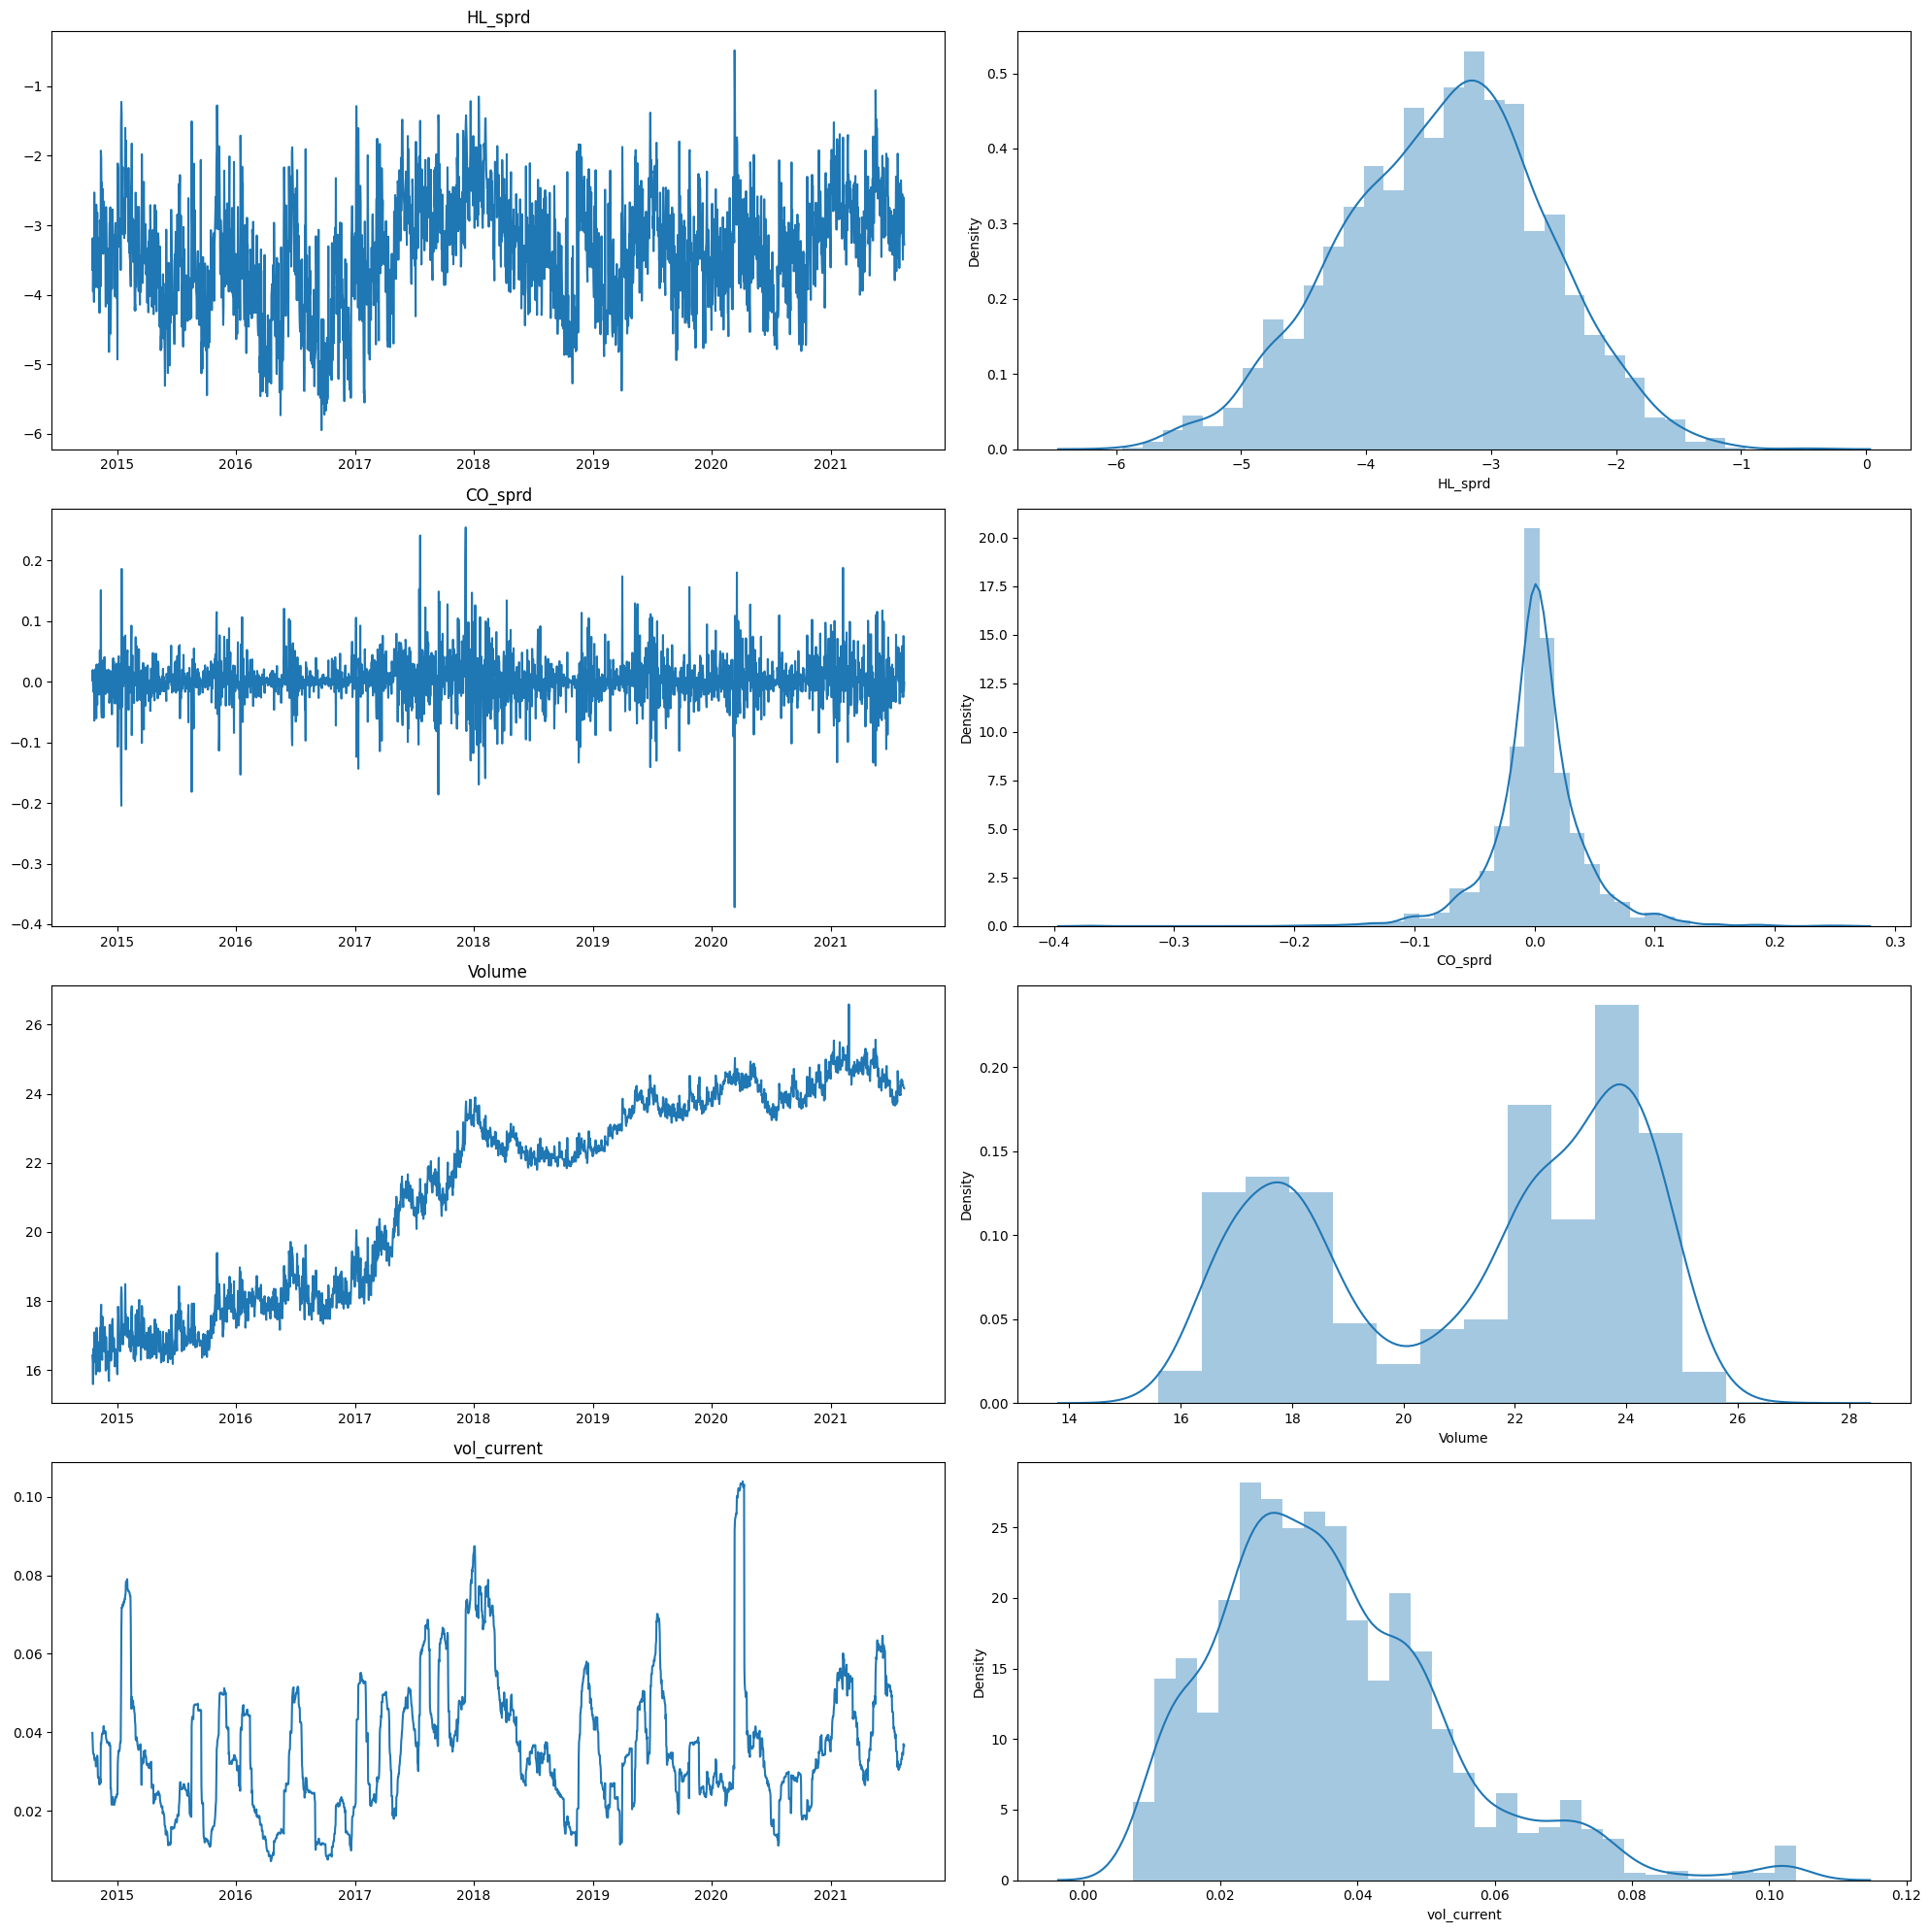

In [270]:
# PLOT EACH NUMERICAL COLUMN
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

for i, c in enumerate(num_features):
    ax1, ax2 = axes[i][0], axes[i][1]
    ax1.plot(df[c])
    ax1.set_title(c)

    sns.distplot(df[c], ax=ax2)

plt.tight_layout()
plt.show();

### Numerical Features Normalizing

In [275]:
cols_to_scale = ['HL_sprd', 'CO_sprd', 'Volume']

# FITTING SCALER TO TRAINING DATA
scaler = MinMaxScaler()
scaler = scaler.fit(df.loc[train_idx][cols_to_scale])

# TRANSFORMING TRAINING DATAFRAME
num_train_dt_scaled = scaler.transform(df.loc[train_idx][cols_to_scale])
num_train_df_scaled = pd.DataFrame(num_train_dt_scaled, 
                                   columns=cols_to_scale,
                                   index=train_idx) 
num_train_df_scaled = pd.concat([num_train_df_scaled, df.vol_current[train_idx]], axis=1)

# TRANSFORMING VALIDATION DATAFRAME
num_val_dt_scaled = scaler.transform(df.loc[val_idx][cols_to_scale])
num_val_df_scaled = pd.DataFrame(num_val_dt_scaled, 
                                 columns=cols_to_scale,
                                 index=val_idx) 
num_val_df_scaled = pd.concat([num_val_df_scaled, df.vol_current[val_idx]], axis=1)

# TRANSFORMING TEST DATAFRAME
num_test_dt_scaled = scaler.transform(df.loc[test_idx][cols_to_scale])
num_test_df_scaled = pd.DataFrame(num_test_dt_scaled, 
                                  columns=cols_to_scale,
                                  index=test_idx) 
num_test_df_scaled = pd.concat([num_test_df_scaled, df.vol_current[test_idx]], axis=1)

In [323]:
num_train_df_scaled.head()

HL_sprd   CO_sprd    Volume  vol_current
Date                                                 
2014-10-17  0.422619  0.597677  0.088243     0.039872
2014-10-18  0.505475  0.624531  0.069694     0.037566
2014-10-19  0.365194  0.586532  0.000000     0.035089
2014-10-20  0.452207  0.567314  0.108199     0.034629
2014-10-21  0.450171  0.610418  0.092729     0.034362

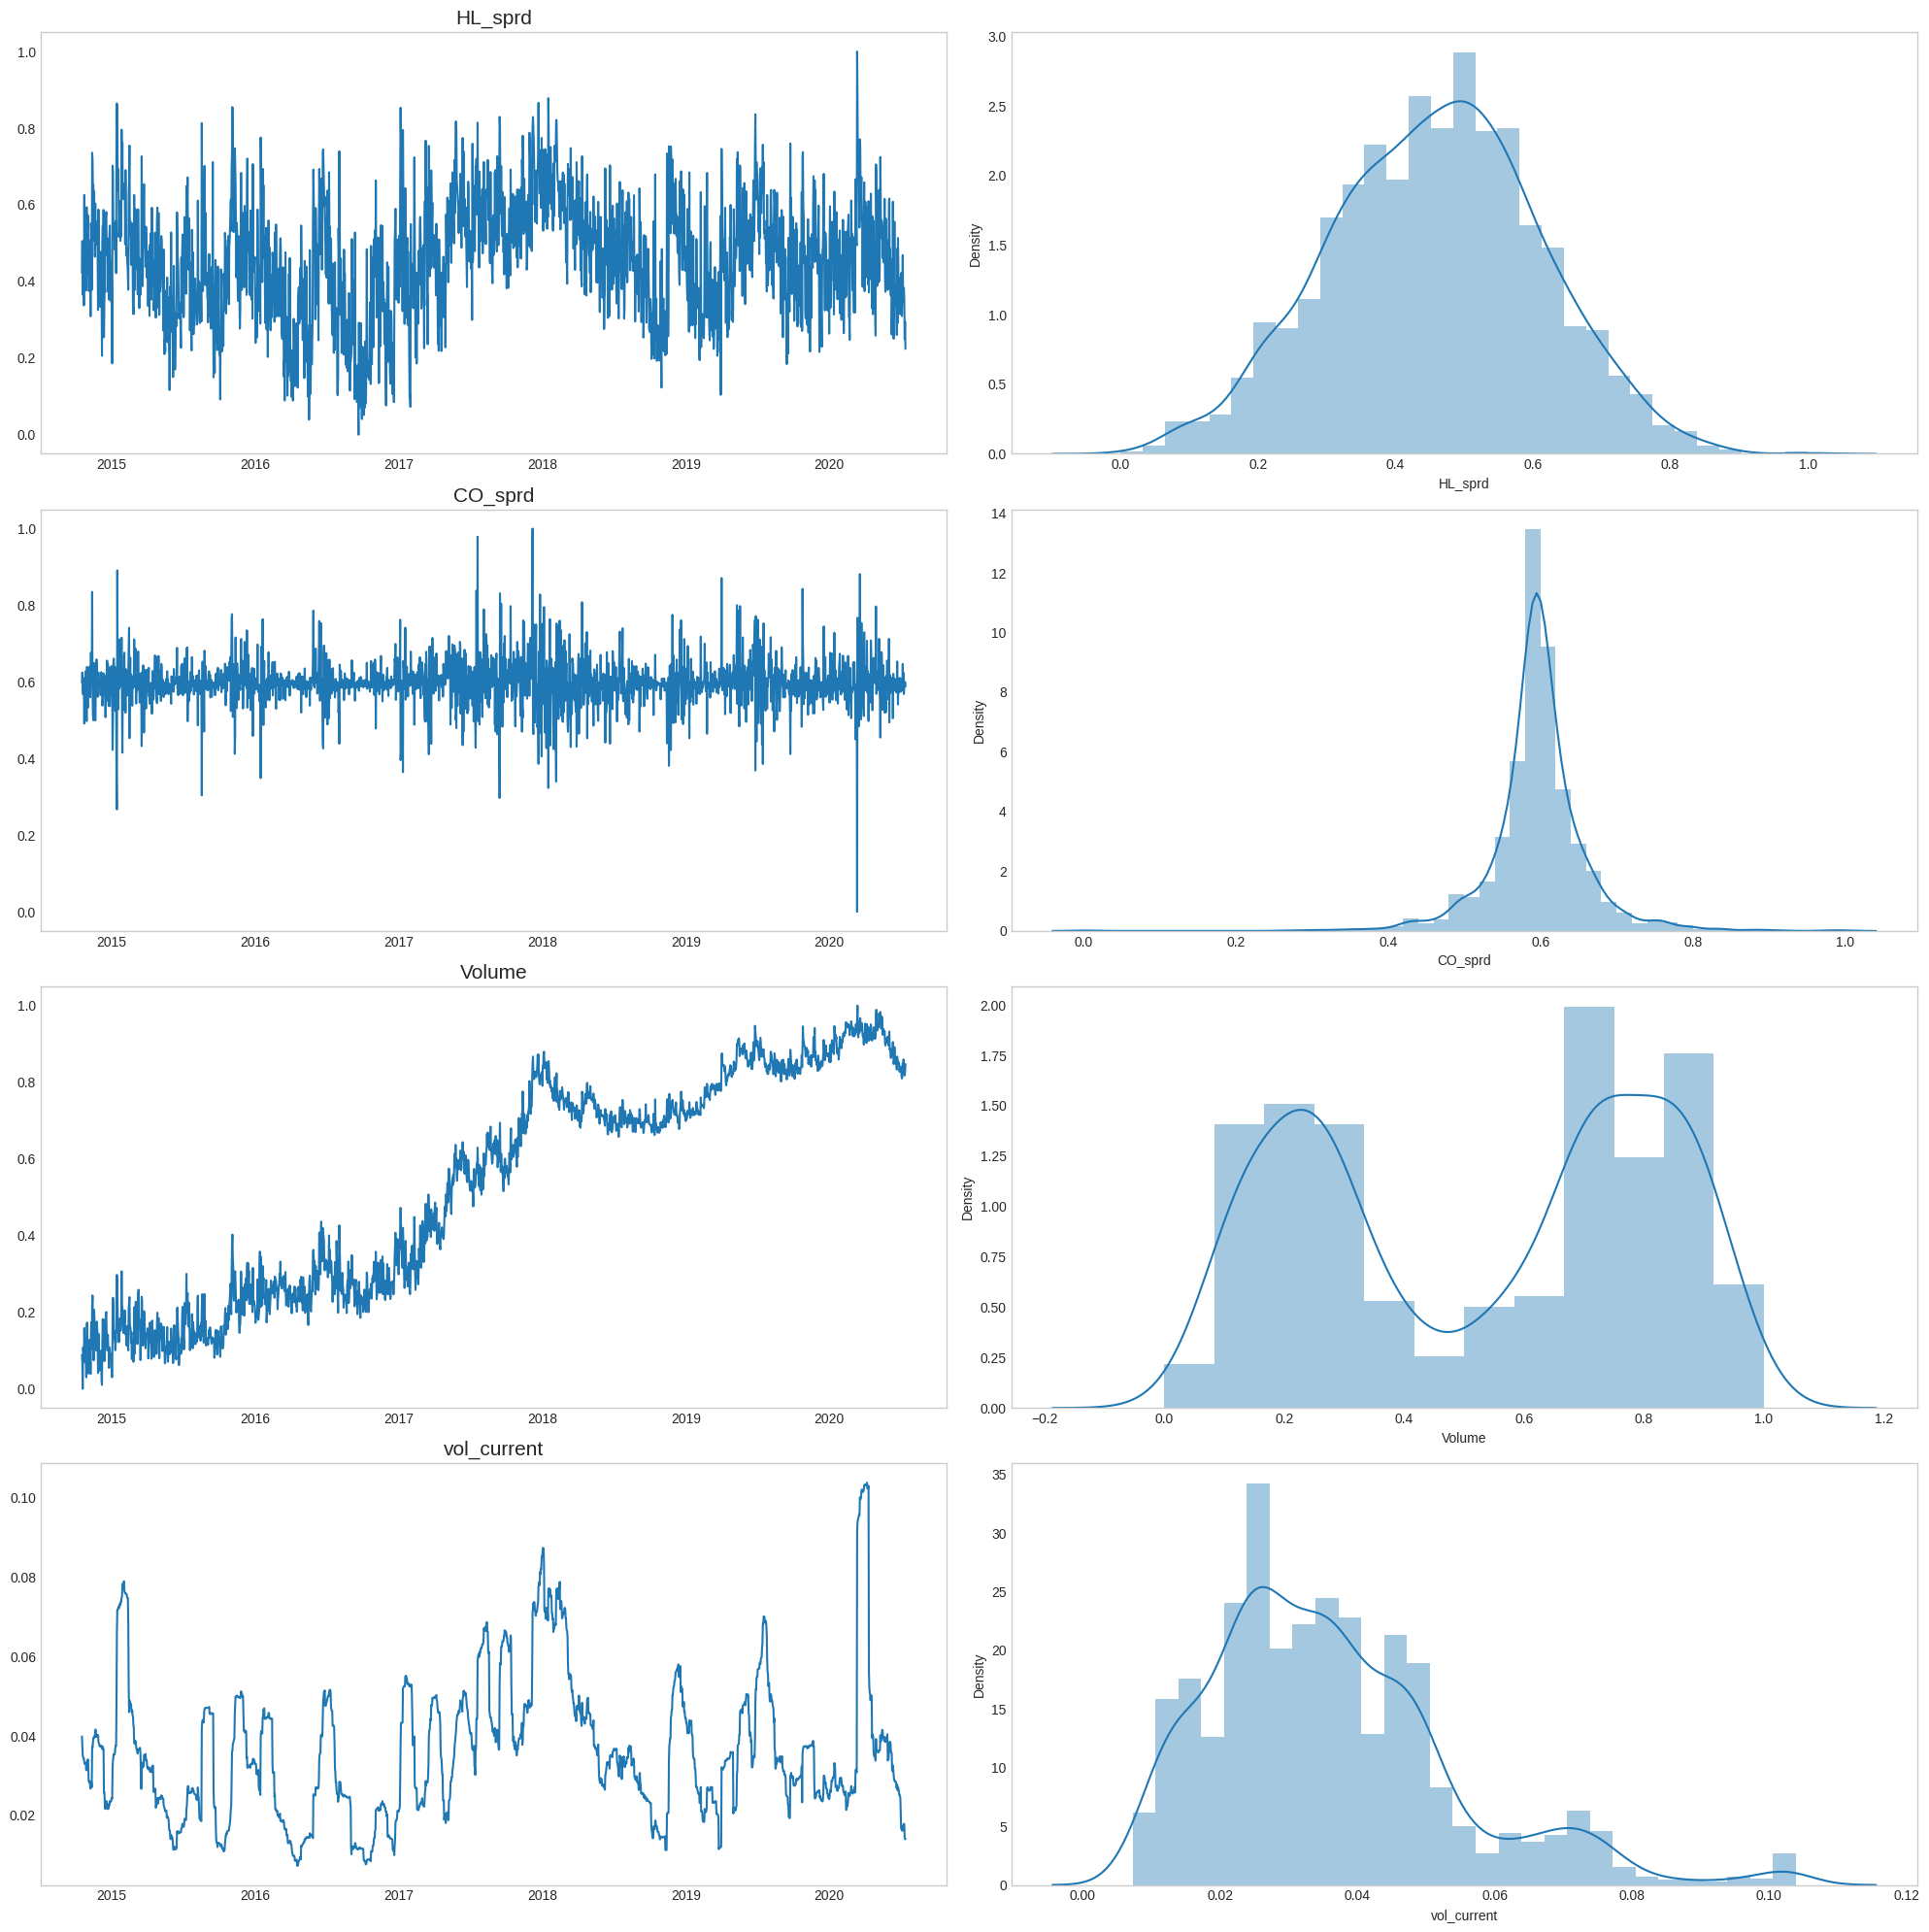

In [504]:
# PLOT NUMERICAL COLUMNS AFTER NORMALIZATION
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

for i, c in enumerate(num_features):
    ax1, ax2 = axes[i][0], axes[i][1]
    ax1.plot(num_train_df_scaled[c])
    ax1.set_title(c, fontsize=15)

    sns.distplot(train_df_scaled[c], ax=ax2)

plt.tight_layout()
plt.savefig('scaled_num_feats.jpg', dpi=300, bbox_inches='tight')
plt.show();

The predict here would be to predict next 7 days' volatility (`vol_future`) column using 4 input variables:
1. `HL_sprd`
2. `CO_sprd`
3. `Volume`
4. `vol_current`

Reshaping the inputs is the meat of Multivariate LSTM. Inputs for LSTM should have the following shape:


**`[batch_size, n_past, input_dims]`**



in which:

- **`batch_size`** is the number of datapoints in each batch
- **`n_past`** is the number of past time steps to be used for prediction (I'll use the same value as above for now).
- **`input_dims`** is the number of input features (which is 4 in this case)  

In [361]:
# COMBINING TRAIN / VALIDATION / TEST INPUTS INTO 1 DATAFRAME
input_df = pd.concat([num_train_df_scaled, num_val_df_scaled, num_test_df_scaled], axis=0)

In [325]:
# CREATE ANOTHER FORECASTING FUNCTION ON VALIDATION SET
# SPECIFICALLY FOR MULTIVARIATE 
def multi_val_forecast(model):
    forecast = []
    idx = df.index

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(val_idx)):
        # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
        # (including current value)
        from_idx = idx[split_time_1 + i - n_past + 1]
        to_idx = idx[split_time_1 + i]
        pred = model.predict(input_df[from_idx:to_idx].values[np.newaxis])
        forecast.append(pred)

    forecast = np.array(forecast)[:, 0, 0]
    preds = pd.Series(forecast, index=val_idx)
    preds_scaled = pd.Series(scaler_vol.transform(preds.values.reshape(-1,1))[:,0],
                                index=val_idx)

    return preds_scaled

### **First Simple Multivariate Bidirectional LSTM**

In [326]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64
n_dims = num_train_df_scaled.shape[1]

mat_X_train, mat_y_train = windowed_dataset(num_train_df_scaled, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(num_val_df_scaled, y_val, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),                         
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
33/33 [==============================] - 6s 47ms/step - loss: 0.0022 - rmspe: 1.5667 - val_loss: 2.9474e-04 - val_rmspe: 0.4339
Epoch 2/200
33/33 [==============================] - 1s 22ms/step - loss: 2.8754e-04 - rmspe: 0.6460 - val_loss: 1.3725e-04 - val_rmspe: 0.3099
Epoch 3/200
33/33 [==============================] - 1s 21ms/step - loss: 1.8055e-04 - rmspe: 0.4745 - val_loss: 8.6171e-05 - val_rmspe: 0.2459
Epoch 4/200
33/33 [==============================] - 1s 23ms/step - loss: 1.5523e-04 - rmspe: 0.4341 - val_loss: 7.0930e-05 - val_rmspe: 0.2248
Epoch 5/200
33/33 [==============================] - 1s 22ms/step - loss: 1.3871e-04 - rmspe: 0.4015 - val_loss: 9.0459e-05 - val_rmspe: 0.2765
Epoch 6/200
33/33 [==============================] - 1s 22ms/step - loss: 1.2955e-04 - rmspe: 0.3712 - val_loss: 5.7054e-05 - val_rmspe: 0.2132
Epoch 7/200
33/33 [==============================] - 1s 22ms/step - loss: 1.2259e-04 - rmspe: 0.3627 - val_loss: 5.2416e-05 - val_rmspe: 0.1

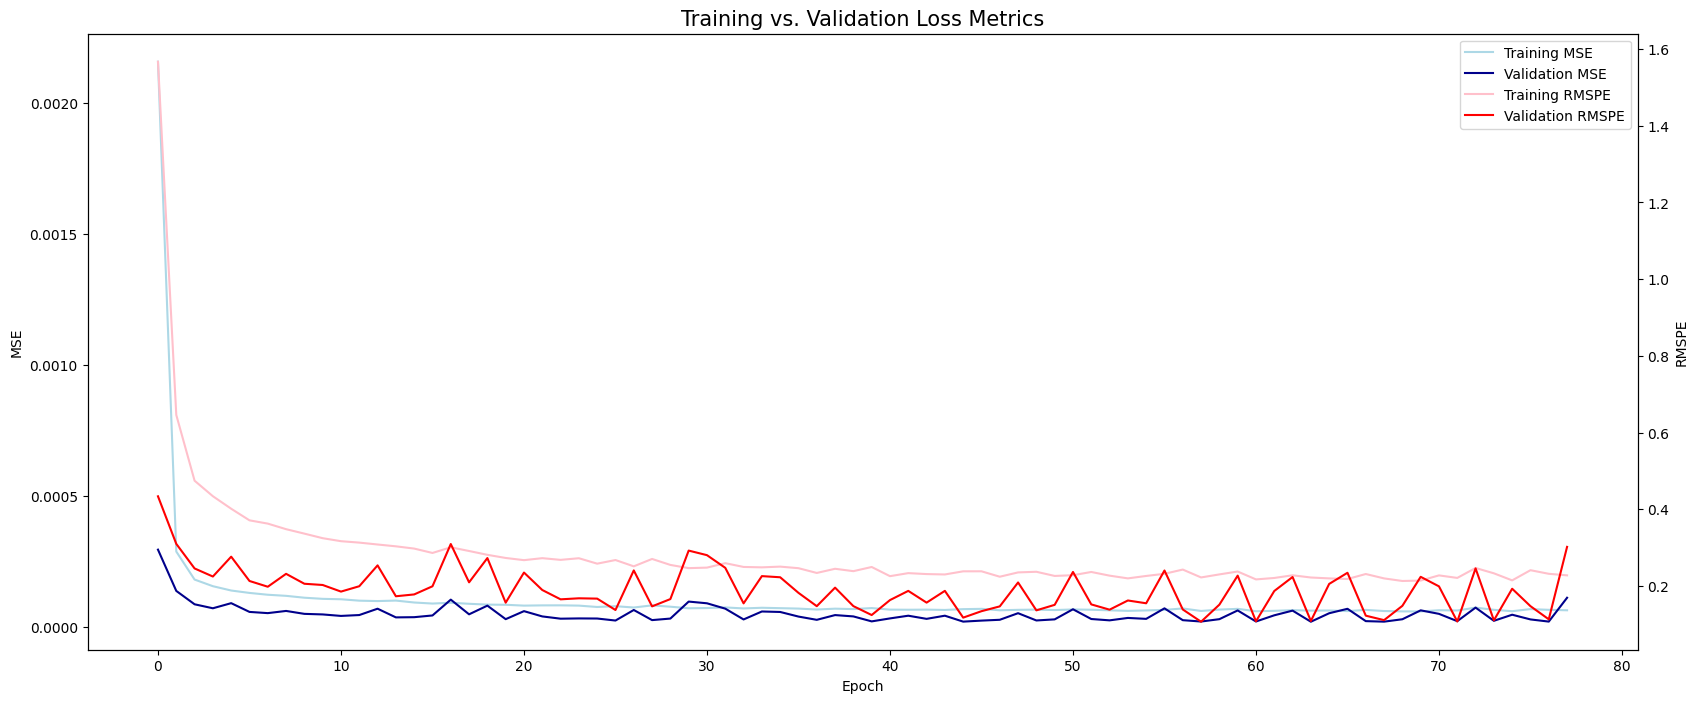

In [327]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

Validation Losses are quite unstable, but still overall a bit below Training Losses.

In [328]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_5_preds_scaled = multi_val_forecast(lstm_5)

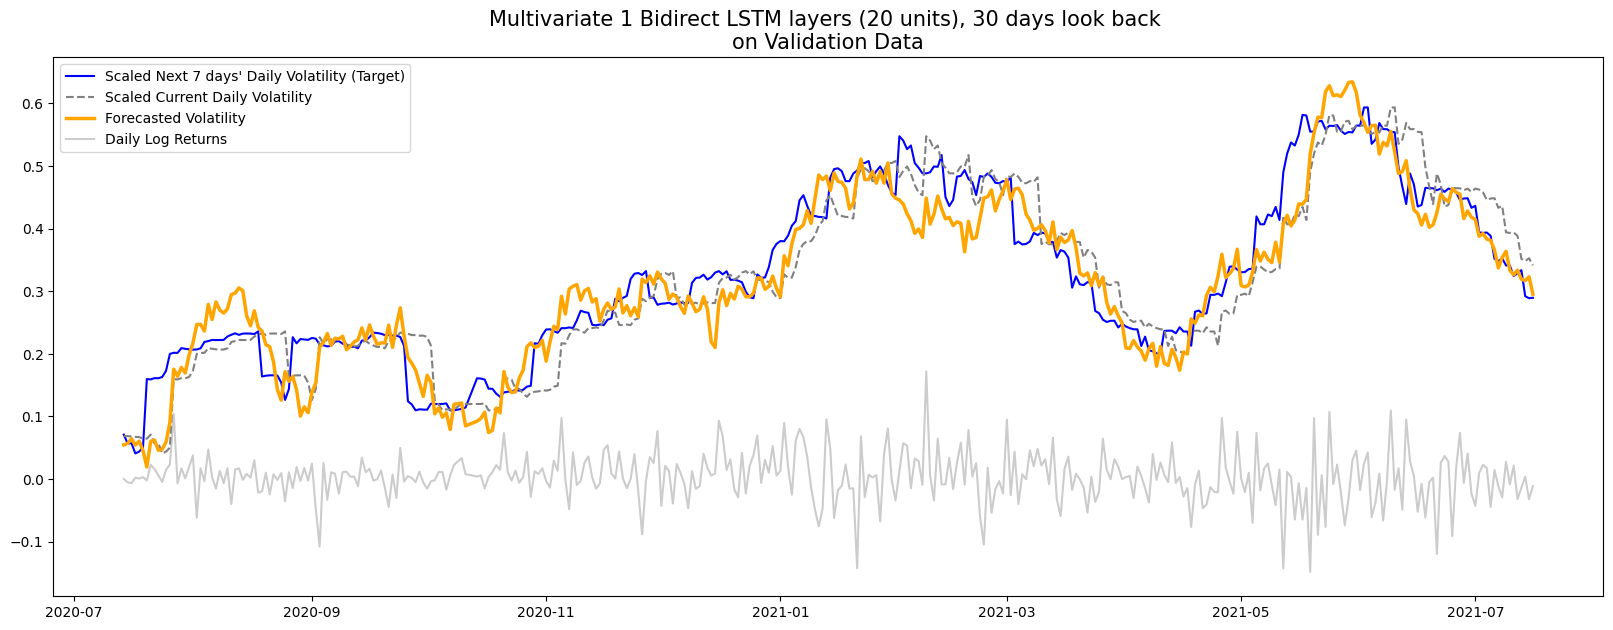

In [329]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 1 Bidirect LSTM layers (20 units), {n_past} days look back")

The prediction line has moved towards target lines a bit closer horizontally. It's still lagging behind a bit, but has managed to stay closer to desired output than a lot of the previous models. Overall still looks a bit noisy.

In [330]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 1 layer (20 units) | n_past={n_past}")

Model  ...  Validation RMSE
0                                                    Mean Baseline  ...         0.136064
1                                    Random Walk Naive Forecasting  ...         0.052586
2                         GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3         Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4                Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5               Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6                Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                         Simple LR Fully Connected NN | n_past=14  ...         0.052628
8                                LSTM 1 layer 20 units | n_past=14  ...         0.051179
9                 2 layers Bidirect LSTM (32/16 units) | n_past=30  ...         0.048534
10  1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=60 | batch=64  ...         0.060564
11  2 Bidirect LSTMs (32/16) | n_past=30 | batch=64 | SGD lr=5e-05  ...         0.141783
12       Multivariate Bidirect LSTM 1 layer (20 units) | n_past=30  ...         0.048264

[13 rows x 3 columns]

<img src="https://bluejaysnation.com/wp-content/uploads/sites/8/2019/09/im-not-crying-youre-crying.jpg " width="200" />

This is the first model with a Validation RMSPE sub 0.2!!! 

Next I am going to add more LSTM layers. 

(I have also experimented with adding 1D convolutional layers to this Multivariate LSTM models, which is available in the Exploratory Notebooks folder, but it did not produce better results, so I am going to omit that version here).

### **Multivariate 3-Layered Bidirectional LSTM**

In [331]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64
n_dims = num_train_df_scaled.shape[1]

mat_X_train, mat_y_train = windowed_dataset(num_train_df_scaled, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(num_val_df_scaled, y_val, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/500
33/33 [==============================] - 15s 163ms/step - loss: 0.0014 - rmspe: 1.0241 - val_loss: 3.9531e-05 - val_rmspe: 0.1652
Epoch 2/500
33/33 [==============================] - 3s 96ms/step - loss: 1.1427e-04 - rmspe: 0.3324 - val_loss: 7.0162e-05 - val_rmspe: 0.2461
Epoch 3/500
33/33 [==============================] - 3s 95ms/step - loss: 9.6142e-05 - rmspe: 0.3184 - val_loss: 3.7984e-05 - val_rmspe: 0.1735
Epoch 4/500
33/33 [==============================] - 3s 95ms/step - loss: 9.2514e-05 - rmspe: 0.3029 - val_loss: 4.9663e-05 - val_rmspe: 0.2003
Epoch 5/500
33/33 [==============================] - 3s 95ms/step - loss: 8.9770e-05 - rmspe: 0.2959 - val_loss: 5.1533e-05 - val_rmspe: 0.2063
Epoch 6/500
33/33 [==============================] - 3s 96ms/step - loss: 8.4978e-05 - rmspe: 0.2797 - val_loss: 7.4049e-05 - val_rmspe: 0.2476
Epoch 7/500
33/33 [==============================] - 3s 98ms/step - loss: 8.3029e-05 - rmspe: 0.2789 - val_loss: 2.4760e-05 - val_rmspe: 0

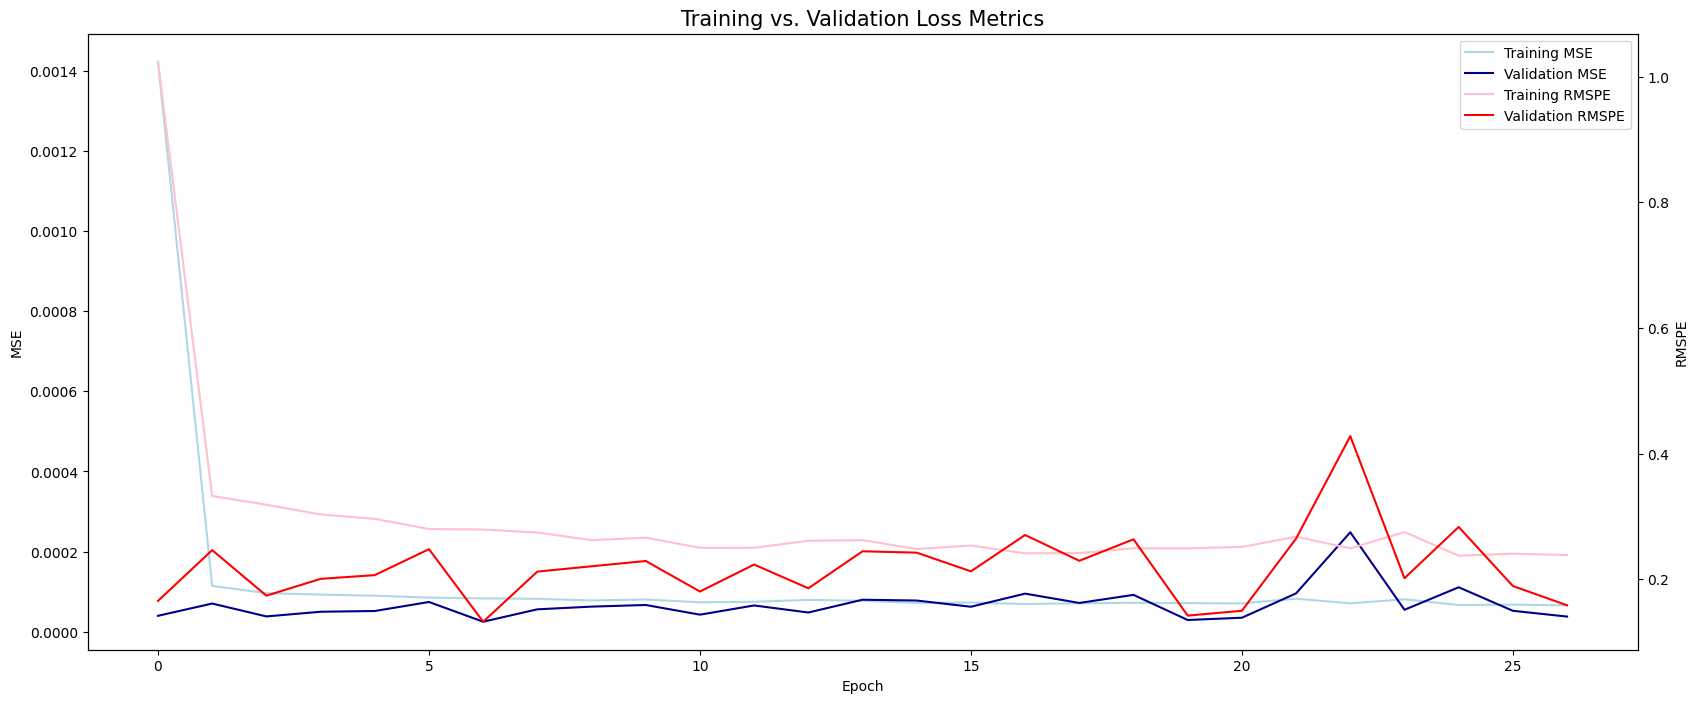

In [332]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)

In [333]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_6_preds_scaled = multi_val_forecast(lstm_6)

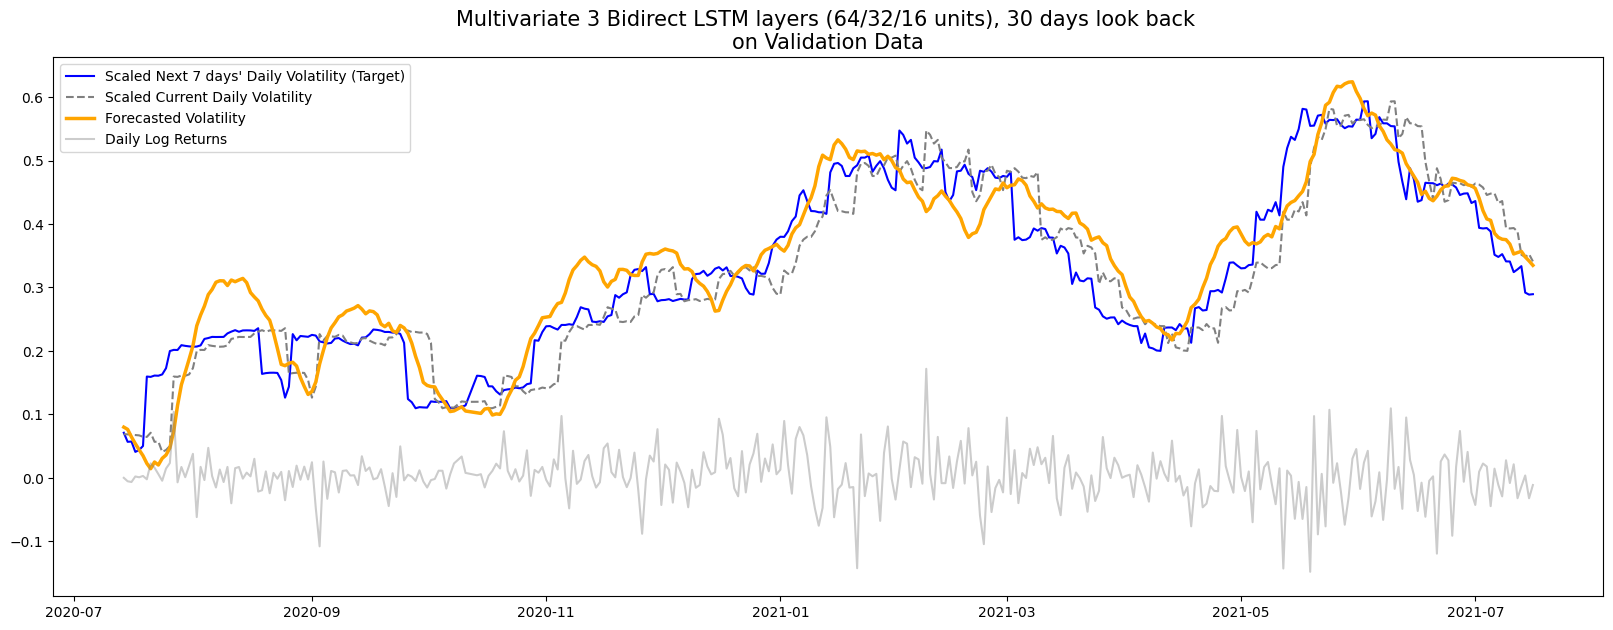

In [334]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_6_preds_scaled, 
          f"Multivariate 3 Bidirect LSTM layers (64/32/16 units), {n_past} days look back")

In [335]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units) | n_past={n_past}")

Model  ...  Validation RMSE
0                                                      Mean Baseline  ...         0.136064
1                                      Random Walk Naive Forecasting  ...         0.052586
2                           GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3           Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4                  Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5                 Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6                  Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                           Simple LR Fully Connected NN | n_past=14  ...         0.052628
8                                  LSTM 1 layer 20 units | n_past=14  ...         0.051179
9                   2 layers Bidirect LSTM (32/16 units) | n_past=30  ...         0.048534
10    1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=60 | batch=64  ...         0.060564
11    2 Bidirect LSTMs (32/16) | n_past=30 | batch=64 | SGD lr=5e-05  ...         0.141783
12         Multivariate Bidirect LSTM 1 layer (20 units) | n_past=30  ...         0.048264
13  Multivariate Bidirect LSTM 3 layers (64/32/16 units) | n_past=30  ...         0.055167

[14 rows x 3 columns]

Using 3 LSTM layers with 64/32/16 units seem a bit like an overkill. I'll reduce to 2 layers with less neurons to see if that'd help.

### **Multivariate 2-Layered Bidirectional LSTM**

In [336]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64
n_dims = num_train_df_scaled.shape[1]

mat_X_train, mat_y_train = windowed_dataset(num_train_df_scaled, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(num_val_df_scaled, y_val, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/500
33/33 [==============================] - 9s 88ms/step - loss: 0.0066 - rmspe: 2.6077 - val_loss: 5.8482e-04 - val_rmspe: 0.7578
Epoch 2/500
33/33 [==============================] - 1s 43ms/step - loss: 5.8567e-04 - rmspe: 1.1097 - val_loss: 1.9176e-04 - val_rmspe: 0.4358
Epoch 3/500
33/33 [==============================] - 1s 43ms/step - loss: 2.8198e-04 - rmspe: 0.6968 - val_loss: 8.0330e-05 - val_rmspe: 0.2762
Epoch 4/500
33/33 [==============================] - 1s 42ms/step - loss: 1.8607e-04 - rmspe: 0.4794 - val_loss: 6.6493e-05 - val_rmspe: 0.2582
Epoch 5/500
33/33 [==============================] - 1s 45ms/step - loss: 1.4127e-04 - rmspe: 0.3711 - val_loss: 6.2211e-05 - val_rmspe: 0.2420
Epoch 6/500
33/33 [==============================] - 1s 43ms/step - loss: 1.1724e-04 - rmspe: 0.3224 - val_loss: 5.5207e-05 - val_rmspe: 0.2204
Epoch 7/500
33/33 [==============================] - 1s 45ms/step - loss: 1.0640e-04 - rmspe: 0.3074 - val_loss: 6.9862e-05 - val_rmspe: 0.2

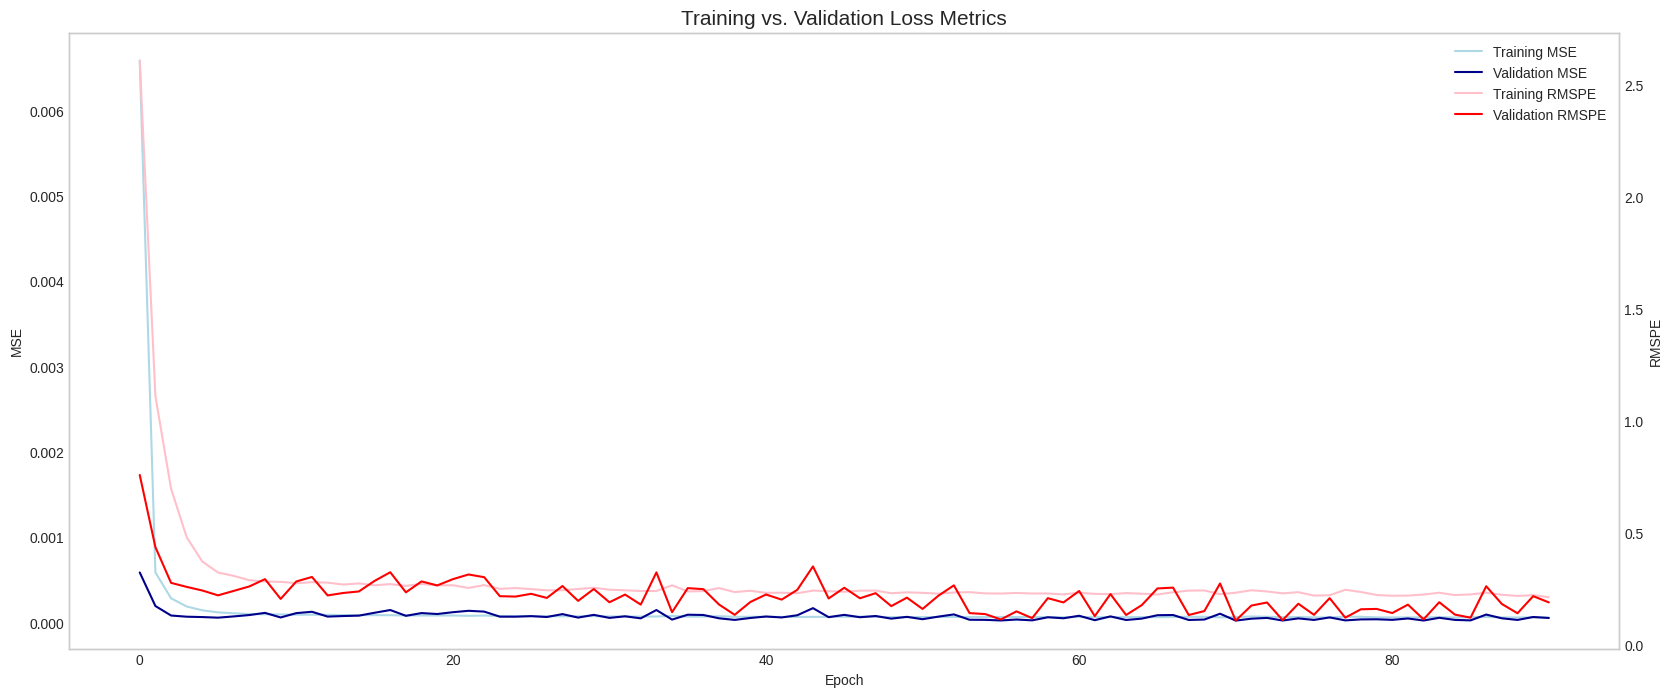

<Figure size 640x480 with 0 Axes>

In [507]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_7_res)
plt.savefig('lstm_7_learning_curves.jpg', dpi=300, bbox_inches='tight')

In [340]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_7_preds_scaled = multi_val_forecast(lstm_7)

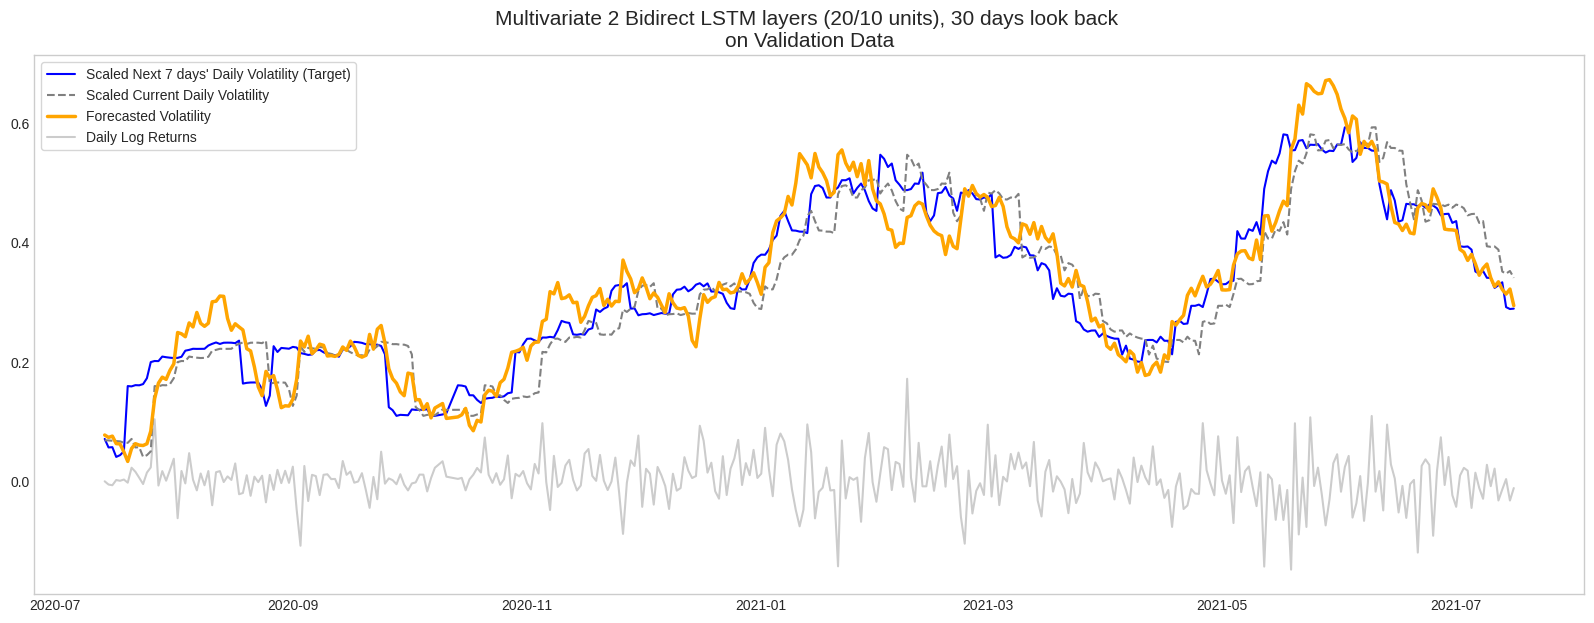

In [508]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_7_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (20/10 units), {n_past} days look back")
plt.savefig(os.path.join(directory_to_img, 'lstm_7_preds.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [342]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled, 
         f"Multivariate 2 Bidirect LSTM layers (20/10 units) | n_past={n_past} | batch={batch_size}")

Model  ...  Validation RMSE
0                                                              Mean Baseline  ...         0.136064
1                                              Random Walk Naive Forecasting  ...         0.052586
2                                   GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3                   Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4                          Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5                         Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6                          Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                                   Simple LR Fully Connected NN | n_past=14  ...         0.052628
8                                          LSTM 1 layer 20 units | n_past=14  ...         0.051179
9                           2 layers Bidirect LSTM (32/16 units) | n_past=30  ...         0.048534
10            1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=60 | batch=64  ...         0.060564
11            2 Bidirect LSTMs (32/16) | n_past=30 | batch=64 | SGD lr=5e-05  ...         0.141783
12                 Multivariate Bidirect LSTM 1 layer (20 units) | n_past=30  ...         0.048264
13          Multivariate Bidirect LSTM 3 layers (64/32/16 units) | n_past=30  ...         0.055167
14  Multivariate 2 Bidirect LSTM layers (20/10 units) | n_past=30 | batch=64  ...         0.048788

[15 rows x 3 columns]

Adding another LSTM layer only help reduce RMSPE by a small margin (from 0.191266 to 0.191254), while RMSE has actually increased (from 0.048264 to 0.048788). 

### **Final Model**

For this final model, I'll re-create the same architecture as model #14 (Multivariate Bidirectional LSTM with 2 layers of 20/10 units) and a lookback window `n_past = 30` and `batch_size = 64`. However, I'll extend the training to include the validation set as well. This is important in time series data since the more recent time steps would most likely carry more relevant information for successful forecasting than data from a year ago.

In [363]:
# COMBINING TRAINING & VALIDATION SETS INTO 1
tv_df = pd.concat([num_train_df_scaled, num_val_df_scaled], axis=0)
tv_y = pd.concat([y_train, y_val], axis=0)

In [421]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64
n_dims = train_df_scaled.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)
mat_X_test, mat_y_test = windowed_dataset(test_df_scaled, y_test, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.15,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/500
33/33 [==============================] - 9s 87ms/step - loss: 0.0018 - rmspe: 1.2914 - val_loss: 1.7820e-04 - val_rmspe: 0.4410
Epoch 2/500
33/33 [==============================] - 1s 43ms/step - loss: 2.5957e-04 - rmspe: 0.5010 - val_loss: 1.0251e-04 - val_rmspe: 0.3443
Epoch 3/500
33/33 [==============================] - 1s 43ms/step - loss: 1.7482e-04 - rmspe: 0.4287 - val_loss: 6.6544e-05 - val_rmspe: 0.2388
Epoch 4/500
33/33 [==============================] - 1s 42ms/step - loss: 1.5045e-04 - rmspe: 0.4095 - val_loss: 5.8445e-05 - val_rmspe: 0.2277
Epoch 5/500
33/33 [==============================] - 1s 44ms/step - loss: 1.3681e-04 - rmspe: 0.4010 - val_loss: 5.3884e-05 - val_rmspe: 0.2109
Epoch 6/500
33/33 [==============================] - 1s 44ms/step - loss: 1.3125e-04 - rmspe: 0.3835 - val_loss: 6.9587e-05 - val_rmspe: 0.2555
Epoch 7/500
33/33 [==============================] - 1s 44ms/step - loss: 1.2120e-04 - rmspe: 0.3668 - val_loss: 1.1453e-04 - val_rmspe: 0.3

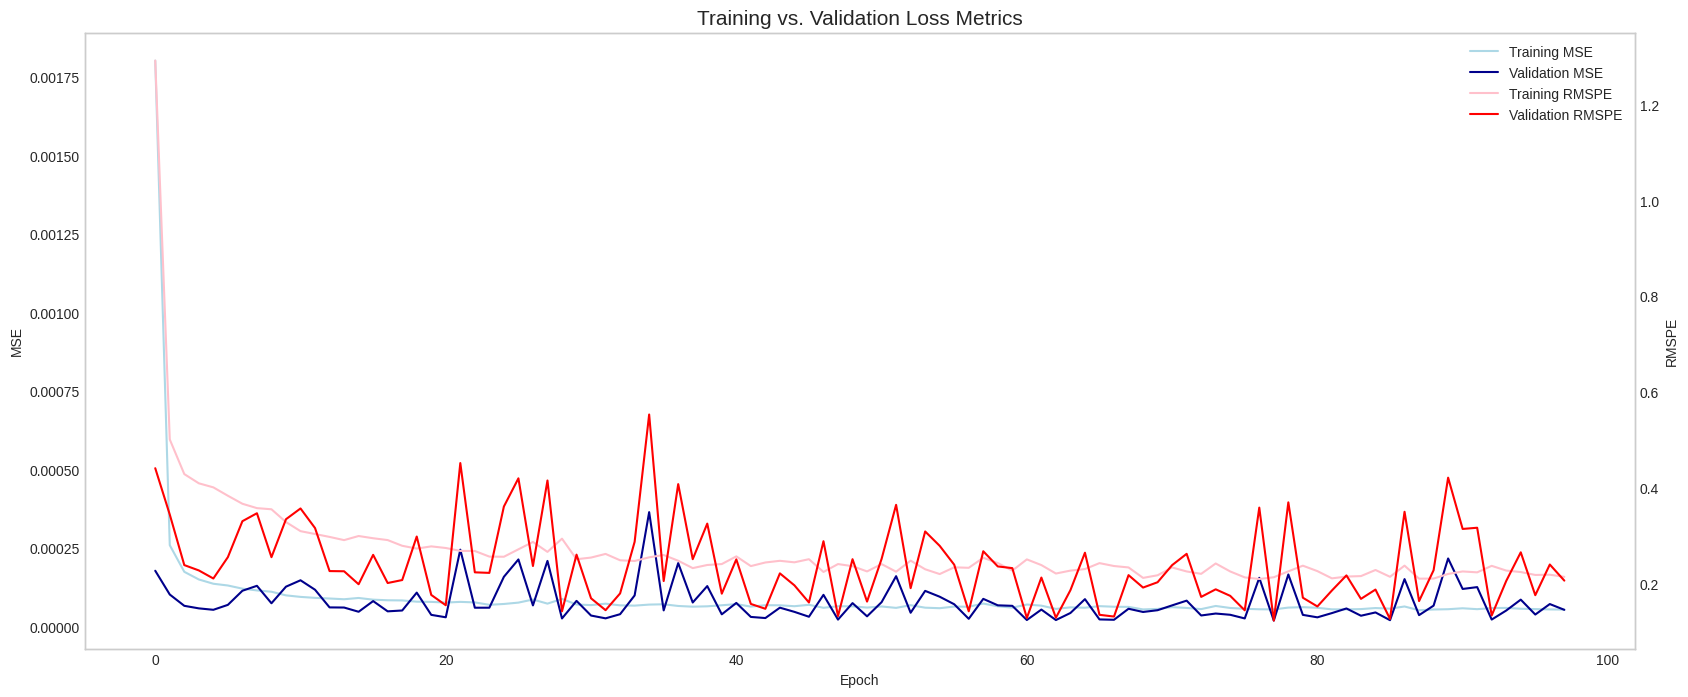

<Figure size 640x480 with 0 Axes>

In [509]:
viz_train_val_metrics(lstm_final_res)
plt.savefig(os.path.join(directory_to_img, 'final_lstm_learning_curves.jpg'), dpi=300, bbox_inches='tight')

Validation Learning Curves look quite unstable.

In [431]:
# MAKING PREDICTIONS ON TEST SET
idx = df.index
forecast = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(test_idx)):
    # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
    # (including current value)
    from_idx = idx[split_time_2 + i - n_past + 1]
    to_idx = idx[split_time_2 + i]
    pred = lstm_final.predict(input_df[from_idx:to_idx].values[np.newaxis])
    forecast.append(pred)

forecast = np.array(forecast)[:, 0, 0]
y_test_preds = pd.Series(forecast, index=test_idx)

In [432]:
y_test_preds.describe()

count    30.000000
mean      0.034106
std       0.003064
min       0.028972
25%       0.031241
50%       0.034566
75%       0.036838
max       0.039044
dtype: float64

In [433]:
y_test.describe()

count    30.000000
mean      0.033894
std       0.002244
min       0.030447
25%       0.031741
50%       0.033867
75%       0.035844
max       0.037194
Name: vol_future, dtype: float64

In [434]:
final_scaler = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN tv_df
final_scaler = final_scaler.fit(tv_df.vol_current.values.reshape(-1,1))

# TRANSFORM THE WHOLE DATA'S vol_current & vol_future
vol_current_scaled = pd.Series(final_scaler.transform(df.vol_current.values.reshape(-1,1))[:,0],
                              index=df.index)
vol_future_scaled = pd.Series(final_scaler.transform(df.vol_future.values.reshape(-1,1))[:,0],
                              index=df.index)

# TRANSFORM TEST PREDICTIONS
y_test_preds_scaled = pd.Series(final_scaler.transform(y_test_preds.values.reshape(-1,1))[:,0],
                         index=test_idx)

In [435]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = vol_current_scaled[:split_time_2].describe()['25%']

q2 = vol_current_scaled[:split_time_2].describe()['50%']

q3 = vol_current_scaled[:split_time_2].describe()['75%']

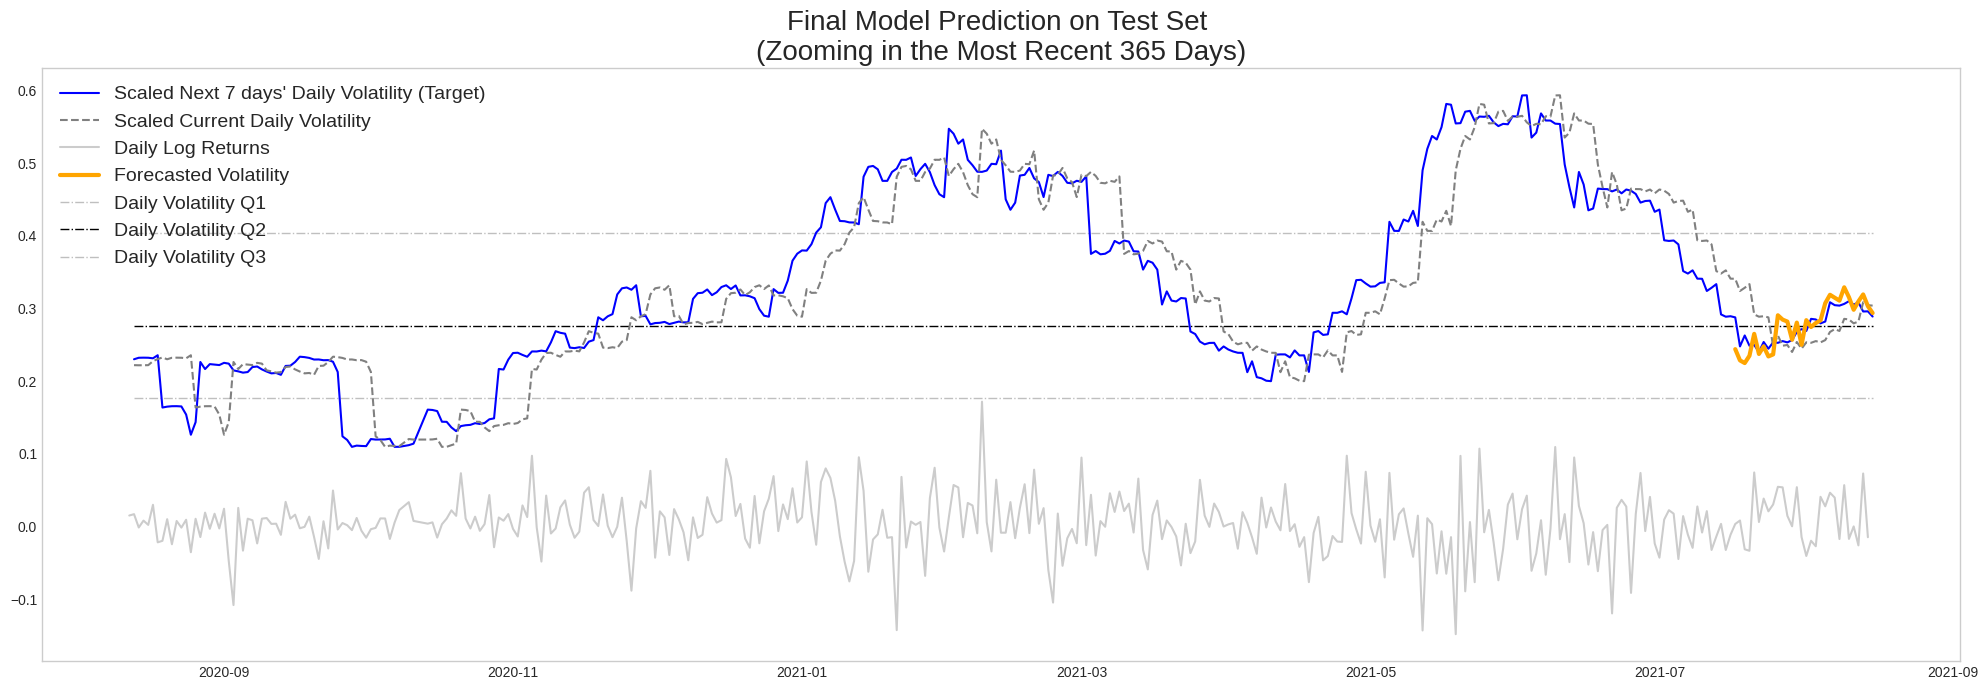

In [510]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES

fig, ax1 = plt.subplots(figsize=(20,7))
# ZOOMING IN THE LAST n_display VALUES
n_display = 365

ax1.plot(vol_future_scaled[-n_display:], color='blue', 
            label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
ax1.plot(vol_current_scaled[-n_display:], color='gray',  ls='--',
            label=f"Scaled Current Daily Volatility")
ax1.plot(df.log_returns[-n_display:], color='gray', alpha=0.4,
            label='Daily Log Returns')
ax1.plot(y_test_preds_scaled, color='orange', lw=3,
            label=f'Forecasted Volatility')

ax1.hlines(y=q1, color='gray', alpha=0.5, label='Daily Volatility Q1', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

ax1.hlines(y=q2, color='black', label='Daily Volatility Q2', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

ax1.hlines(y=q3, color='gray', alpha=0.5, label='Daily Volatility Q3', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

# ax2.plot(df.Close[-n_display:])

plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
ax1.legend(loc='upper left', prop={'size': 14})
plt.tight_layout()
plt.savefig(os.path.join(directory_to_img, 'final_lstm_test_preds.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [437]:
# FINAL MODEL'S RMSPE ON TEST DATA
RMSPE(y_test_scaled, y_test_preds_scaled)

0.07078865455136232

In [438]:
# FINAL MODEL'S RMSE ON TEST DATA
RMSE(y_test_scaled, y_test_preds_scaled)

0.019016825334989024

In [440]:
# MAKING PREDICTIONS ON THE WHOLE DATASET
idx = df.index
forecast = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(n_past-1, len(input_df)):
    # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
    # (including current value)
    from_idx = idx[i - n_past + 1]
    to_idx = idx[i]
    pred = lstm_final.predict(input_df[from_idx:to_idx].values[np.newaxis])
    forecast.append(pred)

forecast = np.array(forecast)[:, 0, 0]
y_preds = pd.Series(forecast, index=input_df.index[n_past-1:])

In [441]:
# TRANSFORM PREDICTIONS
y_preds_scaled = pd.Series(final_scaler.transform(y_preds.values.reshape(-1,1))[:,0],
                           index=input_df.index[n_past-1:])

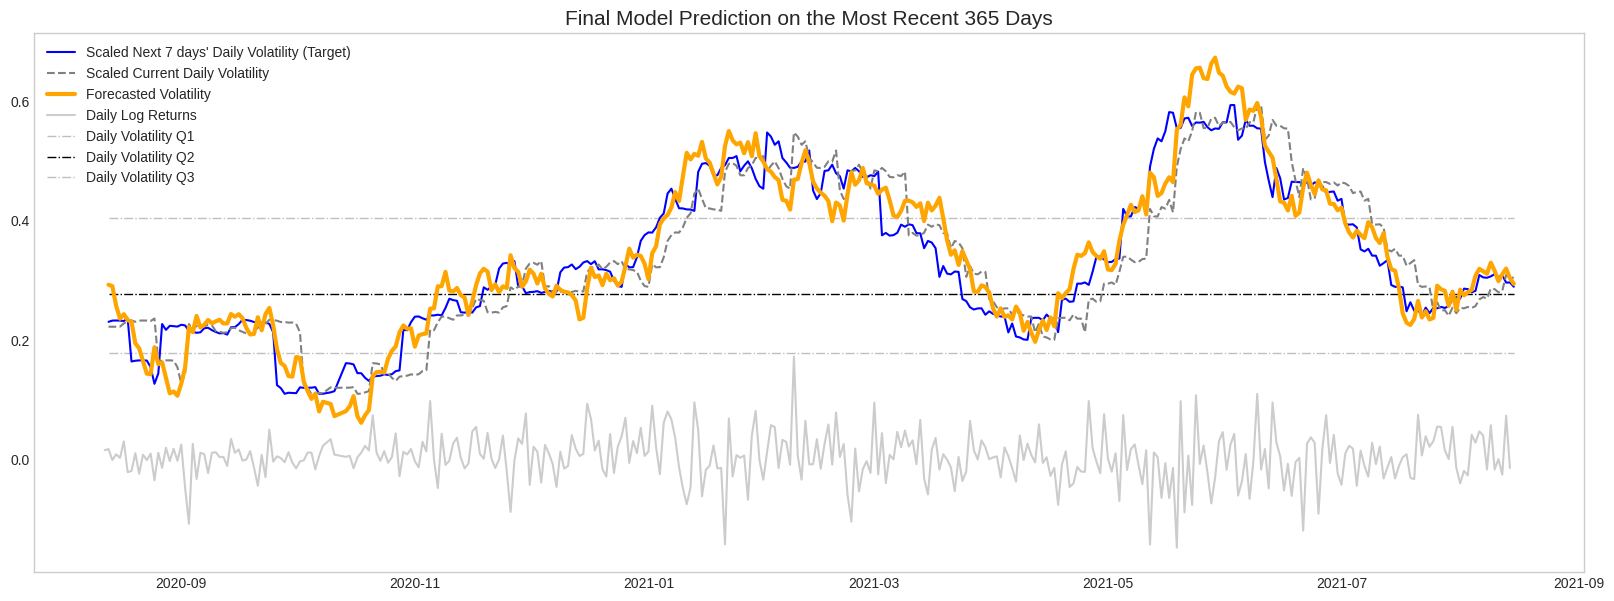

In [511]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
# ZOOMING IN THE LAST n_display VALUES
n_display = 365

plt.figure(figsize=(20,7))
plt.plot(vol_future_scaled[-n_display:], color='blue', 
            label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
plt.plot(vol_current_scaled[-n_display:], color='gray',  ls='--',
            label=f"Scaled Current Daily Volatility")
plt.plot(y_preds_scaled[-n_display:], color='orange', lw=3,
            label=f'Forecasted Volatility')

plt.hlines(y=q1, color='gray', alpha=0.5, label='Daily Volatility Q1', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.hlines(y=q2, color='black', label='Daily Volatility Q2', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.hlines(y=q3, color='gray', alpha=0.5, label='Daily Volatility Q3', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.plot(df.log_returns[-n_display:], color='gray', alpha=0.4,
            label='Daily Log Returns')

plt.title(f'Final Model Prediction on the Most Recent {n_display} Days', fontsize=15)
plt.legend(loc='upper left')
plt.savefig(os.path.join(directory_to_img, 'final_lstm_preds.jpg'), dpi=300, bbox_inches='tight')

plt.show();

In [450]:
perf_df

Model  ...  Validation RMSE
0                                                              Mean Baseline  ...         0.136064
1                                              Random Walk Naive Forecasting  ...         0.052586
2                                   GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185466
3                   Analytical GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091072
4                          Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.069652
5                         Simulation TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.073170
6                          Bootstrap TARCH(2,2) | Constant Mean | Skewt Dist  ...         0.066847
7                                   Simple LR Fully Connected NN | n_past=14  ...         0.052628
8                                          LSTM 1 layer 20 units | n_past=14  ...         0.051179
9                           2 layers Bidirect LSTM (32/16 units) | n_past=30  ...         0.048534
10            1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=60 | batch=64  ...         0.060564
11            2 Bidirect LSTMs (32/16) | n_past=30 | batch=64 | SGD lr=5e-05  ...         0.141783
12                 Multivariate Bidirect LSTM 1 layer (20 units) | n_past=30  ...         0.048264
13          Multivariate Bidirect LSTM 3 layers (64/32/16 units) | n_past=30  ...         0.055167
14  Multivariate 2 Bidirect LSTM layers (20/10 units) | n_past=30 | batch=64  ...         0.048788

[15 rows x 3 columns]

In [512]:
perf_df.to_pickle("performance_df.pkl")

In [452]:
test_idx

DatetimeIndex(['2021-07-17', '2021-07-18', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-24',
               '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28',
               '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09',
               '2021-08-10', '2021-08-11', '2021-08-12', '2021-08-13',
               '2021-08-14', '2021-08-15'],
              dtype='datetime64[ns]', name='Date', freq=None)

# **Conclusion**

A trader does not need to make perfectly accurate forecast to have a positive expectation when participating in the markets, he/she just needs to make a forecast that is both correct (ie. bullish or bearish) and **more correct than the consensus**. 

My final LSTM model has an RMSPE of 0.0708 on the Test set (which is the most recent 30 days of which future volatility data is available for comparison). Since RMSPE indicates the average magnitude of the error in relation to the actual values, that translates to **a magnitude accuracy of 93% on the average 7 days forward-looking daily volatility forecasting within the period of 07/17/2021 to 08/15/2021**, which is part of some more quiet months for volatility historically.  

In terms of performance on the validation set, LSTM model has an RMSPE of 0.191254, which is **roughly 10% better than the best performing variant of the GARCH models** - TARCH(2,2) with an RMSPE of 0.213242.

However, since financial time series data are constantly evolving, no model would be able to consistently forecast with high accuracy level forever. The average lifetime of a model is between 6 months to 5 years, and there's a phenomenon in quant trading that is called **alpha decay**, which is the loss in predictive power of an alpha model over time. In addition, researchers have proved that the publication of a new "edge" or anomaly in the markets lessens its returns by up to 58%. 

These models therfore require constant tweaking and tuning based on the most recent information available to make sure the model stays up-to-date and learn to evolve with the markets. 



# **Next Steps**

As briefly mentioned above, I think there's potential application of WaveNet in the forecasting of volatility, and would like to explore that option in the future.

In addition, it's common knowledge that economic events could affect markets' dynamics. Since cryptocurrencies have cerain nuances that are different from other stocks and commodities', adding in regular economic calendars' events might not be the most relevant. I am currently still doing more research on the types of events that could have driven Bitcoin movements, and would like to incorporate that in another set of Multivariate LSTM models in the future to hopefully improve predictive power even more.